# Understanding the Trends and Forecasting Global Health Expenditure

Submitted by: Roja Annamalai Rajanbabu (Reg. No.: 2320904)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.cm import viridis
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cycler import cycler
import geopandas as gpd

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Loading the DataSet

In [ ]:
GHED_master = pd.read_excel('GHED_data.xlsx', sheet_name='Data')
GHED_master.head()
GHED_master.info()

# Removing Columns with High Missing Values

In [4]:
GHED_master.isnull().sum()

country                  0
code                     0
region                   0
income                   0
year                     0
                      ... 
hk_ext_usd2021_pc     3510
hk_pvtd_usd2021_pc    3911
gdp_usd2021_pc         113
pfc_usd2021_pc         115
gge_usd2021_pc         113
Length: 3923, dtype: int64

In [5]:
GHED_dp = GHED_master.loc[:, GHED_master.notnull().sum() > 4000]

# Removing columns with Less Statistical IMportance

In [6]:
columns_to_remove = [
    # 1. NCU as units
    "che", "gghed", "pvtd", "fs", "fs1", "fs11", "fs6", "fs61", "hf", "hf1", "hf11", "hf13", "hf2", "hf3", "gdp", "pfc", "gge", "che_ncu_pc", "gghed_ncu_pc", "pvtd_ncu_pc", "fs_ncu_pc",
    "fs1_ncu_pc", "fs11_ncu_pc", "fs6_ncu_pc", "fs61_ncu_pc", "hf_ncu_pc", "hf1_ncu_pc", "hf11_ncu_pc", "hf13_ncu_pc", "hf2_ncu_pc", "hf3_ncu_pc", "gdp_ncu_pc", "pfc_ncu_pc",
    "gge_ncu_pc", "che_ncu2021", "gghed_ncu2021", "pvtd_ncu2021", "fs_ncu2021", "fs1_ncu2021", "fs11_ncu2021", "fs6_ncu2021", "fs61_ncu2021", "hf_ncu2021", "hf1_ncu2021", "hf11_ncu2021",
    "hf13_ncu2021", "hf2_ncu2021", "hf3_ncu2021", "gdp_ncu2021", "pfc_ncu2021", "gge_ncu2021", "che_ncu2021_pc", "gghed_ncu2021_pc", "pvtd_ncu2021_pc", "fs_ncu2021_pc", "fs1_ncu2021_pc",
    "fs11_ncu2021_pc", "fs6_ncu2021_pc", "fs61_ncu2021_pc", "hf_ncu2021_pc", "hf1_ncu2021_pc", "hf11_ncu2021_pc", "hf13_ncu2021_pc", "hf2_ncu2021_pc", "hf3_ncu2021_pc", "gdp_ncu2021_pc",
    "pfc_ncu2021_pc", "gge_ncu2021_pc",
    # 2. 2021 constant US$ as units
    "che_usd2021", "gghed_usd2021", "pvtd_usd2021", "fs_usd2021", "fs1_usd2021", "fs11_usd2021", "fs6_usd2021", "fs61_usd2021", "hf_usd2021", "hf1_usd2021", "hf11_usd2021", "hf13_usd2021", 
    "hf2_usd2021", "hf3_usd2021", "gdp_usd2021", "pfc_usd2021", "gge_usd2021", "che_usd2021_pc", "gghed_usd2021_pc", "pvtd_usd2021_pc", "fs_usd2021_pc", "fs1_usd2021_pc", "fs11_usd2021_pc", 
    "fs6_usd2021_pc", "fs61_usd2021_pc", "hf_usd2021_pc", "hf1_usd2021_pc", "hf11_usd2021_pc", "hf13_usd2021_pc", "hf2_usd2021_pc", "hf3_usd2021_pc", "gdp_usd2021_pc", "pfc_usd2021_pc", 
    "gge_usd2021_pc",
    # 3. Purchasing power parity variables
    "che_ppp_pc", "gghed_ppp_pc", "pvtd_ppp_pc", "fs_ppp_pc", "fs1_ppp_pc", "fs11_ppp_pc", "fs6_ppp_pc", "fs61_ppp_pc", "hf_ppp_pc", "hf1_ppp_pc", "hf11_ppp_pc", "hf13_ppp_pc",
    "hf2_ppp_pc", "hf3_ppp_pc", "gdp_ppp_pc", "pfc_ppp_pc", "gge_ppp_pc",
    # 4. Calculated Variables (multi-colliear) 
    "che_gdp", "che_pc_usd", "dom_che", "gghed_che", "pvtd_che", "oops_che", "gghed_gdp", "gghed_gge", "gghed_pc_usd", "pvtd_pc_usd", "oop_pc_usd",
    "cfa_che", "gfa_che", "vfa_che", "gge_gdp", "gdp_pc_usd", "gdpd", "fs_usd_pc", "fs1_usd_pc", "fs11_usd_pc", "fs6_usd_pc", "fs61_usd_pc",
    "hf_usd_pc", "hf1_usd_pc", "hf11_usd_pc", "hf13_usd_pc", "hf2_usd_pc", "hf3_usd_pc", "pfc_usd_pc", "gge_usd_pc", "pvtd_gdp", "fs_gdp", "fs1_gdp",
    "fs11_gdp", "fs6_gdp", "fs61_gdp", "hf_gdp", "hf1_gdp", "hf11_gdp", "hf13_gdp", "hf2_gdp", "hf3_gdp", "pfc_gdp", "fs1_gge", "fs11_gge",
    "hf11_gge", "fs1_che", "fs11_che", "fs6_che", "fs61_che", "hf1_che", "hf11_che", "hf13_che", "hf2_che", "hf3_che",
    # 5. Variables as they are less relevant to the study
    "pfc_usd", "gge_usd", "hf_usd","fs_usd",
    # 6. hf13_usd as 95% of values are Zero
    'hf13_usd'
]

GHED_dp = GHED_dp.drop(columns=columns_to_remove)
GHED_dp.head()

country code region        income  year        ppp        xrt         pop  \
0  Algeria  DZA    AFR  Lower-middle  2000  15.744428  75.259789  30774.6210   
1  Algeria  DZA    AFR  Lower-middle  2001  15.324636  77.215019  31200.9855   
2  Algeria  DZA    AFR  Lower-middle  2002  15.288708  79.681900  31624.6955   
3  Algeria  DZA    AFR  Lower-middle  2003  16.241821  77.394974  32055.8835   
4  Algeria  DZA    AFR  Lower-middle  2004  17.754457  72.060654  32510.1860   

       che_usd    gghed_usd    pvtd_usd      fs1_usd     fs11_usd     fs6_usd  \
0  1911.648551  1375.687961  534.962960   877.642581   877.642581  519.323814   
1  2101.027653  1601.550815  498.504457  1060.319208  1060.319208  480.697134   
2  2117.197412  1593.798099  522.457058  1044.661463  1044.661463  502.251752   
3  2443.795446  1874.249404  568.318560  1239.174625  1239.174625  544.350595   
4  3024.238369  2157.899911  864.922962  1424.979119  1424.979119  821.209848   

     fs61_usd      hf1_usd     hf11_usd    hf2_usd     hf3_usd       gdp_usd  
0  493.100456  1375.754398   877.709017  42.793716  493.100456  54790.215089  
1  455.261714  1601.615570  1060.383962  44.150452  455.261714  54744.530820  
2  476.896259  1593.860849  1044.724213  46.440352  476.896259  56760.694698  
3  516.829428  1874.572422  1239.497643  52.393583  516.829428  67863.580095  
4  789.154651  2158.342849  1425.422057  76.740908  789.154651  85332.281698

# Removing Rows with Less Statistical Importance

In [7]:
# Out of scope Year = 2022
GHED_dp = GHED_dp[GHED_dp['year'] != 2022]

# Countries with no data for 10 or more years
countries_to_remove = ['South Sudan', 'Venezuela (Bolivarian Republic of)', 'Libya', 'Zimbabwe']
GHED_dp = GHED_dp[~GHED_dp['country'].isin(countries_to_remove)]

# Handling the Missing Values

In [8]:
GHED_dp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4136 entries, 0 to 4243
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    4136 non-null   object 
 1   code       4136 non-null   object 
 2   region     4136 non-null   object 
 3   income     4136 non-null   object 
 4   year       4136 non-null   int64  
 5   ppp        4101 non-null   float64
 6   xrt        4115 non-null   float64
 7   pop        4101 non-null   float64
 8   che_usd    4100 non-null   float64
 9   gghed_usd  4100 non-null   float64
 10  pvtd_usd   4100 non-null   float64
 11  fs1_usd    4100 non-null   float64
 12  fs11_usd   4093 non-null   float64
 13  fs6_usd    4100 non-null   float64
 14  fs61_usd   4099 non-null   float64
 15  hf1_usd    4100 non-null   float64
 16  hf11_usd   4089 non-null   float64
 17  hf2_usd    4061 non-null   float64
 18  hf3_usd    4100 non-null   float64
 19  gdp_usd    4100 non-null   float64
dtypes: float64(15

In [9]:
ghed_train = GHED_dp[GHED_dp['year'] < 2017]
ghed_test = GHED_dp[GHED_dp['year'] >= 2017]

print("Train dataset rows:", len(ghed_train))
print("Test dataset rows:", len(ghed_test))

Train dataset rows: 3196
Test dataset rows: 940


In [10]:
missing_train = ghed_train.isnull().sum()
missing_train = missing_train[missing_train > 0]  

missing_test = ghed_test.isnull().sum()
missing_test = missing_test[missing_test > 0]  

print("Missing values in GHED_train:")
print(missing_train)

print("\nMissing values in GHED_test:")
print(missing_test)


Missing values in GHED_train:
ppp          25
xrt          20
pop          25
che_usd      25
gghed_usd    25
pvtd_usd     25
fs1_usd      25
fs11_usd     25
fs6_usd      25
fs61_usd     25
hf1_usd      25
hf11_usd     36
hf2_usd      59
hf3_usd      25
gdp_usd      25
dtype: int64

Missing values in GHED_test:
ppp          10
xrt           1
pop          10
che_usd      11
gghed_usd    11
pvtd_usd     11
fs1_usd      11
fs11_usd     18
fs6_usd      11
fs61_usd     12
hf1_usd      11
hf11_usd     11
hf2_usd      16
hf3_usd      11
gdp_usd      11
dtype: int64


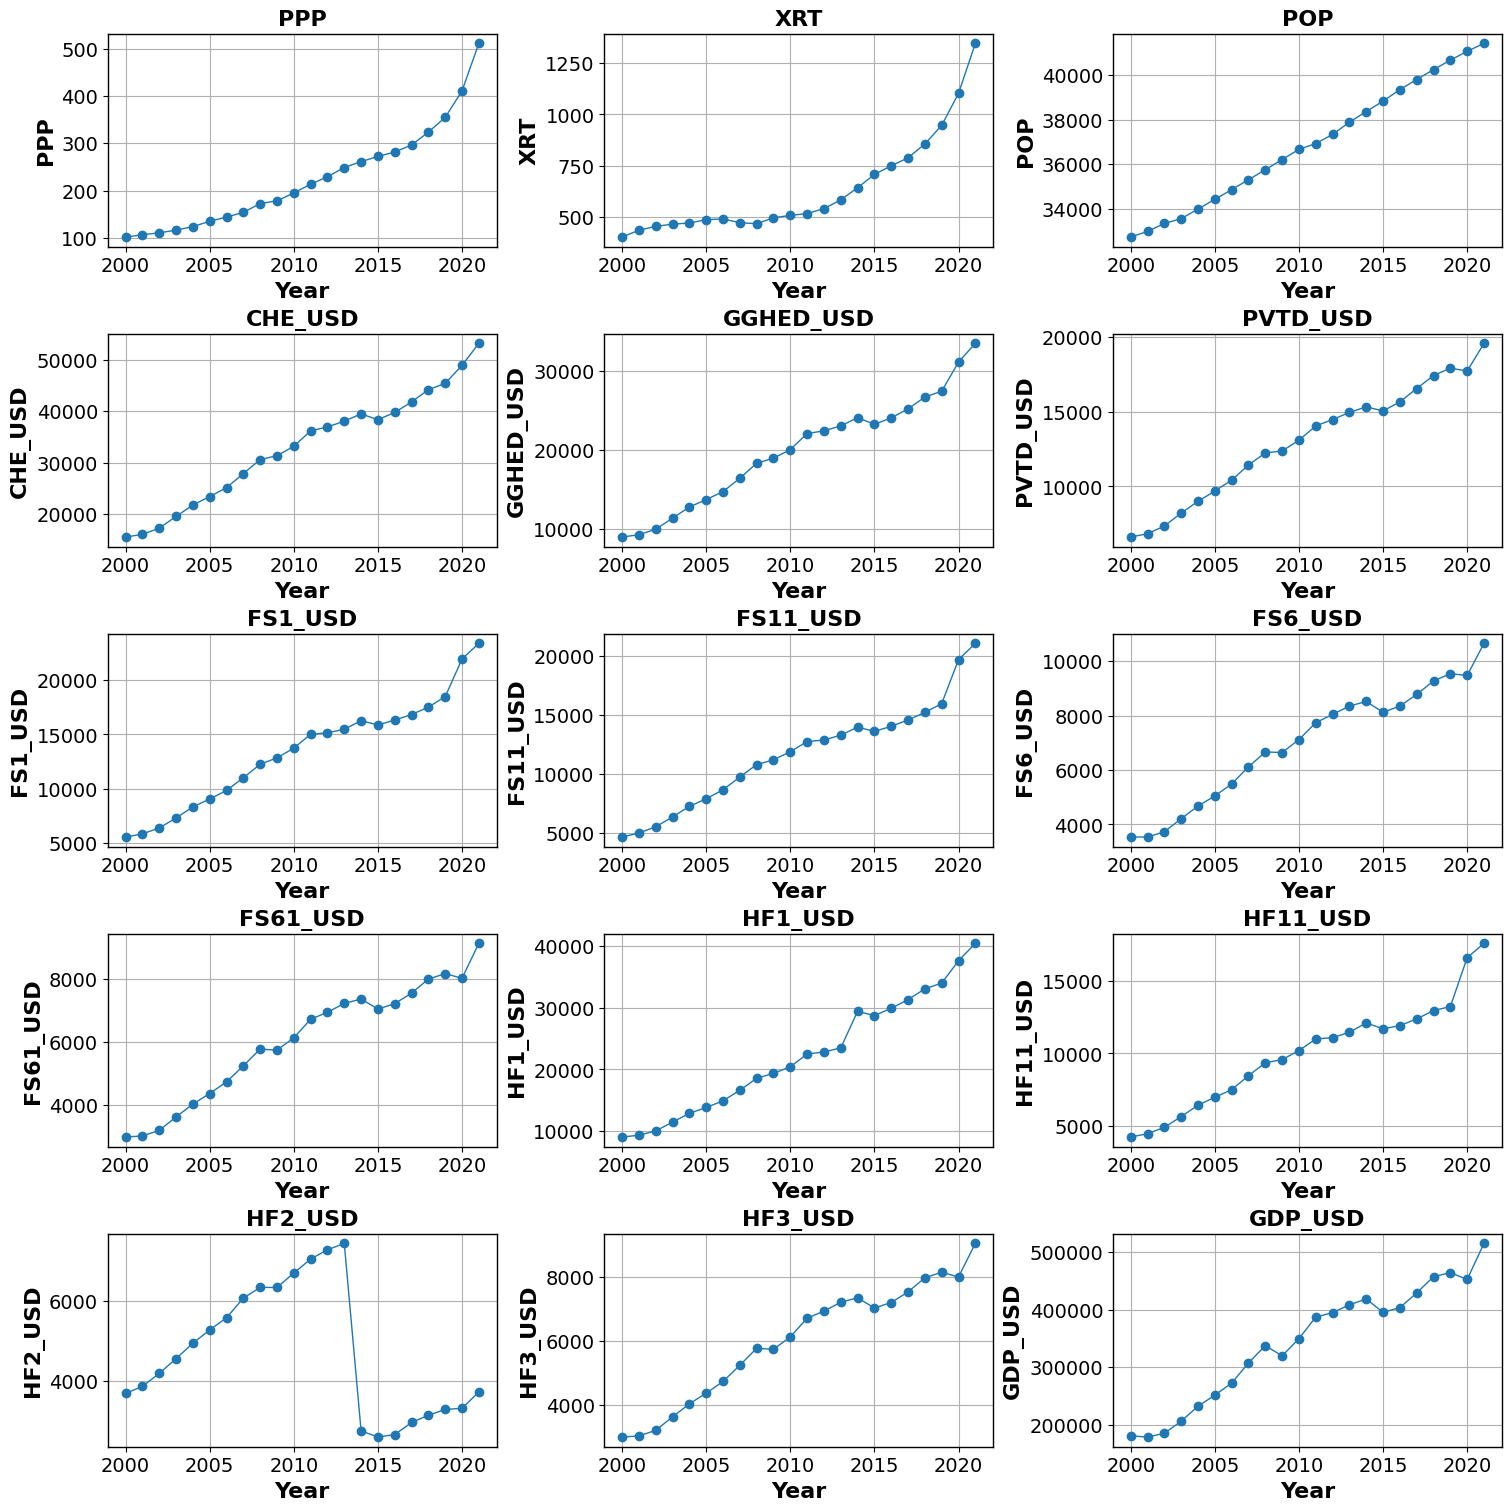

In [11]:
variables_to_plot = ['ppp', 'xrt', 'pop', 'che_usd', 'gghed_usd', 'pvtd_usd', 'fs1_usd', 'fs11_usd',
    'fs6_usd', 'fs61_usd', 'hf1_usd', 'hf11_usd', 'hf2_usd', 'hf3_usd', 'gdp_usd']

trend_data_all = GHED_dp.groupby('year')[variables_to_plot].mean()

fig, axes = plt.subplots(5, 3, figsize=(15, 15), constrained_layout=True) 
axes = axes.flatten()
for i, column in enumerate(variables_to_plot):
    axes[i].plot(trend_data_all.index, trend_data_all[column], marker='o', linestyle='-', linewidth=1)
    axes[i].set_title(f"{column.upper()}", fontsize=16, fontweight='bold') 
    axes[i].set_xlabel("Year", fontsize=16, fontweight='bold')  
    axes[i].set_ylabel(column.upper(), fontsize=16, fontweight='bold') 
    axes[i].tick_params(axis='both', which='major', labelsize=14)
    axes[i].grid(True)
    for spine in axes[i].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

for j in range(len(variables_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.show()


## Handle missing values for each variable based on trends

In [12]:
def interpolate_or_impute(data, columns, method, **kwargs):
    for column in columns:
        data[column] = data.groupby('country')[column].transform(lambda x: x.interpolate(method=method, **kwargs))
    return data

def median_impute(data, columns):
    for column in columns:
        data[column] = data.groupby('country')[column].transform(lambda x: x.fillna(x.median()))
    return data

# 1. PPP & GDP_USD (Polynomial interpolation)
interpolate_or_impute(ghed_train, ['ppp'], method='polynomial', order=2)
interpolate_or_impute(ghed_test, ['ppp'], method='polynomial', order=2)
interpolate_or_impute(ghed_train, ['gdp_usd'], method='polynomial', order=2)
interpolate_or_impute(ghed_test, ['gdp_usd'], method='polynomial', order=2)

# 2. XRT, POP, GGHE_USD, PVTD_USD, FS1_USD, FS11_USD, FS6_USD, FS61_USD, HF1_USD, HF11_USD, HF2_USD, HF3_USD (Linear interpolation)
linear_columns = ['xrt', 'pop', 'gghed_usd', 'pvtd_usd', 'fs1_usd', 'fs11_usd', 'fs6_usd', 'fs61_usd', 'hf1_usd', 'hf11_usd', 'hf3_usd']
interpolate_or_impute(ghed_train, linear_columns, method='linear')
interpolate_or_impute(ghed_test, linear_columns, method='linear')

# 3. CHE_USD (Group median imputation)
median_impute(ghed_train, ['che_usd'])
median_impute(ghed_test, ['che_usd'])

# HF2_USD: Forward fill + Linear interpolation
ghed_train['hf2_usd'] = ghed_train.groupby('country')['hf2_usd'].transform(
    lambda x: x.fillna(method='ffill').interpolate(method='linear')
)
ghed_test['hf2_usd'] = ghed_test.groupby('country')['hf2_usd'].transform(
    lambda x: x.fillna(method='ffill').interpolate(method='linear')
)

# Verify missing values
print("Remaining missing values in Train set:")
print(ghed_train.isnull().sum())

print("\nRemaining missing values in Test set:")
print(ghed_test.isnull().sum())


Remaining missing values in Train set:
country       0
code          0
region        0
income        0
year          0
ppp          25
xrt          20
pop          20
che_usd       0
gghed_usd    20
pvtd_usd     20
fs1_usd      20
fs11_usd     20
fs6_usd      20
fs61_usd     20
hf1_usd      20
hf11_usd     31
hf2_usd      54
hf3_usd      20
gdp_usd      25
dtype: int64

Remaining missing values in Test set:
country       0
code          0
region        0
income        0
year          0
ppp          10
xrt           0
pop          10
che_usd      10
gghed_usd    10
pvtd_usd     10
fs1_usd      10
fs11_usd     10
fs6_usd      10
fs61_usd     10
hf1_usd      10
hf11_usd     10
hf2_usd      15
hf3_usd      10
gdp_usd      11
dtype: int64


In [13]:
# Remaining Missing Values = Train Set
missing_variables = ['ppp', 'xrt', 'pop', 'gghed_usd', 'pvtd_usd', 'fs1_usd', 'fs11_usd', 'fs6_usd', 'fs61_usd', 
                     'hf1_usd', 'hf11_usd','hf2_usd', 'hf3_usd', 'gdp_usd']

# Forward and backward fill within each group (country)
for var in missing_variables:
    ghed_train[var] = ghed_train.groupby('country')[var].transform(
        lambda x: x.fillna(method='ffill').fillna(method='bfill')
    )
# Regional median
ghed_train['hf2_usd'] = ghed_train.groupby('region')['hf2_usd'].transform(
    lambda x: x.fillna(x.median())
)
ghed_train.isna().sum()

country      0
code         0
region       0
income       0
year         0
ppp          0
xrt          0
pop          0
che_usd      0
gghed_usd    0
pvtd_usd     0
fs1_usd      0
fs11_usd     0
fs6_usd      0
fs61_usd     0
hf1_usd      0
hf11_usd     0
hf2_usd      0
hf3_usd      0
gdp_usd      0
dtype: int64

In [14]:
# Remaining Missing Values = Train Set - replace missing values with regional medians in test data
for column in ['ppp', 'pop', 'che_usd', 'gghed_usd', 'pvtd_usd', 'fs1_usd', 'fs11_usd', 
               'fs6_usd', 'fs61_usd', 'hf1_usd', 'hf11_usd', 'hf2_usd', 'hf3_usd', 'gdp_usd']:
    
    ghed_test[column] = ghed_test.groupby('region')[column].transform(lambda x: x.fillna(x.median()))

print(ghed_test.isnull().sum())

country      0
code         0
region       0
income       0
year         0
ppp          0
xrt          0
pop          0
che_usd      0
gghed_usd    0
pvtd_usd     0
fs1_usd      0
fs11_usd     0
fs6_usd      0
fs61_usd     0
hf1_usd      0
hf11_usd     0
hf2_usd      0
hf3_usd      0
gdp_usd      0
dtype: int64


# Updating Categorical Varibles

In [15]:
GHED_dp['country'] = GHED_dp['country'].astype('category')
GHED_dp['code'] = GHED_dp['code'].astype('category')
GHED_dp['region'] = GHED_dp['region'].astype('category')
GHED_dp['income'] = pd.Categorical(GHED_dp['income'], categories=['Low', 'Lower-middle', 'Upper-middle', 'High'], ordered=True)

# Geopolitical Risk 

In [16]:
gpr_master = pd.read_excel("data_gpr_export.xls")
gpr_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1499 entries, 0 to 1498
Columns: 115 entries, month to var_label
dtypes: datetime64[ns](1), float64(111), int64(1), object(2)
memory usage: 1.3+ MB


In [17]:
# Or, filter for specific date ranges:
gpr_dp = gpr_master[(gpr_master['month'] >= '2000-01-01') & (gpr_master['month'] <= '2021-12-01')]
gpr_dp = gpr_dp[['month','GPR']]
gpr_dp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 264 entries, 1200 to 1463
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   month   264 non-null    datetime64[ns]
 1   GPR     264 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.2 KB


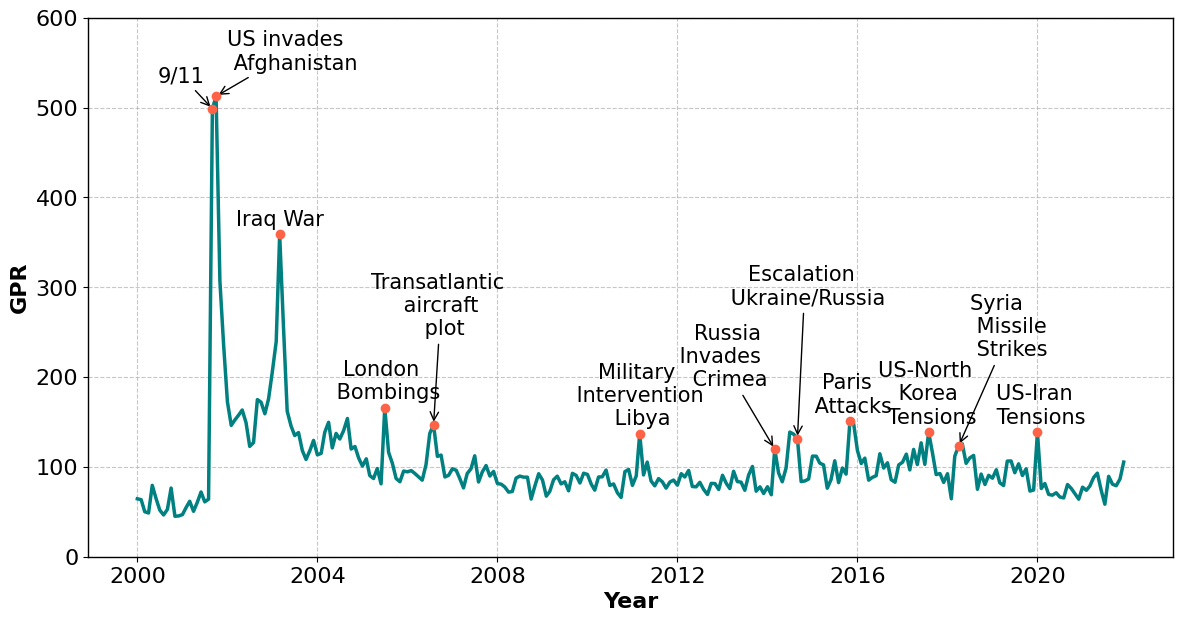

In [18]:
gpr_dp['month'] = pd.to_datetime(gpr_dp['month'], format='%d-%m-%Y')

# Plot GPR
plt.figure(figsize=(14, 7))
plt.plot(gpr_dp['month'], gpr_dp['GPR'], label='GPR', color='teal', linewidth=2.5)

# Add event annotations and red dots
events = {
    "2001-09": "9/11",
    "2001-10": "US invades \n Afghanistan",
    "2003-03": "Iraq War",
    "2005-07": "London \n Bombings",
    "2006-08": "Transatlantic \n aircraft \n plot",
    "2011-03": "Military \n Intervention \n Libya",
    "2014-03": "Russia \n Invades \n Crimea",
    "2014-09": "Escalation \n Ukraine/Russia",
    "2015-11": "Paris \n Attacks",
    "2017-08": "US-North \n Korea \n Tensions",
    "2018-04": "Syria \n Missile \n Strikes",
    "2020-01": "US-Iran \n Tensions",
}

for date, event in events.items():
    date = pd.to_datetime(date, format='%Y-%m')
    if date in gpr_dp['month'].values:
        gpr_value = gpr_dp.loc[gpr_dp['month'] == date, 'GPR'].values[0]
        
        # Add red dot at the event point
        plt.scatter(date, gpr_value, color='tomato', zorder=5)

        # Adjust positions for specific events
        if event == "US invades \n Afghanistan":
            plt.annotate(
                event,
                xy=(date, gpr_value),  # Point to the red dot
                xytext=(date + pd.Timedelta(days=90), gpr_value + 30),  # Slightly to the right and above
                arrowprops=dict(facecolor='black', arrowstyle='->', color='black'),
                fontsize=15,
                ha='left',
                color='black'
            )
        elif event == "Syria \n Missile \n Strikes":
            plt.annotate(
                event,
                xy=(date, gpr_value),  # Point to the red dot
                xytext=(date + pd.Timedelta(days=90), gpr_value + 100),  # Slightly to the right and above
                arrowprops=dict(facecolor='black', arrowstyle='->', color='black'),
                fontsize=15,
                ha='left',
                color='black'
            )
        elif event == "9/11":
            plt.annotate(
                event,
                xy=(date, gpr_value),  # Point to the red dot
                xytext=(date - pd.Timedelta(days=60), gpr_value + 30),  # Slightly to the left and above
                arrowprops=dict(facecolor='black', arrowstyle='->', color='black'),
                fontsize=15,
                ha='right',
                color='black'
            )
        elif event == "Russia \n Invades \n Crimea":
            plt.annotate(
                event,
                xy=(date, gpr_value),  # Point to the red dot
                xytext=(date - pd.Timedelta(days=60), gpr_value + 70),  # Slightly to the left and above
                arrowprops=dict(facecolor='black', arrowstyle='->', color='black'),
                fontsize=15,
                ha='right',
                color='black'
            )
        elif event == "Transatlantic \n aircraft \n plot":
            plt.annotate(
                event,
                xy=(date, gpr_value),  # Point to the red dot
                xytext=(date + pd.Timedelta(days=60), gpr_value + 100),  # Move to the right and slightly above
                arrowprops=dict(facecolor='black', arrowstyle='->', color='black'),
                fontsize=15,
                ha='center',
                color='black'
            )
        elif event == "Escalation \n Ukraine/Russia":
            plt.annotate(
                event,
                xy=(date, gpr_value),  # Point to the red dot
                xytext=(date + pd.Timedelta(days=60), gpr_value + 150),  # Move to the right and slightly above
                arrowprops=dict(facecolor='black', arrowstyle='->', color='black'),
                fontsize=15,
                ha='center',
                color='black'
            )
        else:
            # Add event name above the red dot for other events
            plt.text(
                x=date,
                y=gpr_value + 10,  # Slightly above the red dot
                s=event,
                fontsize=15,
                ha='center',  # Centered horizontally
                color='black'
            )

# Adjust axis and labels
plt.ylim(0, 600)
# Update x-ticks and y-ticks font size to 16
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.xlabel('Year', fontsize=16, fontweight='bold')
plt.ylabel('GPR', fontsize=16, fontweight='bold')

ax = plt.gca()  # Get current axis
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)



# Combining test, train & GPR for eda

## Converting Monthly to Annual GPR Index

In [19]:
gpr_dp['month'] = pd.to_datetime(gpr_dp['month'])
gpr_dp['year'] = gpr_dp['month'].dt.year

annual_gpr = gpr_dp.groupby('year')['GPR'].mean().reset_index()
annual_gpr.columns = ['year', 'annual_gpr']

ghed_train = ghed_train.merge(annual_gpr, on='year', how='left')

ghed_test = ghed_test.merge(annual_gpr, on='year', how='left')

print("Train Dataset with GPR:")
print(ghed_train.head())

print("\nTest Dataset with GPR:")
print(ghed_test.head())

Train Dataset with GPR:
   country code region        income  year        ppp        xrt         pop  \
0  Algeria  DZA    AFR  Lower-middle  2000  15.744428  75.259789  30774.6210   
1  Algeria  DZA    AFR  Lower-middle  2001  15.324636  77.215019  31200.9855   
2  Algeria  DZA    AFR  Lower-middle  2002  15.288708  79.681900  31624.6955   
3  Algeria  DZA    AFR  Lower-middle  2003  16.241821  77.394974  32055.8835   
4  Algeria  DZA    AFR  Lower-middle  2004  17.754457  72.060654  32510.1860   

       che_usd    gghed_usd  ...      fs1_usd     fs11_usd     fs6_usd  \
0  1911.648551  1375.687961  ...   877.642581   877.642581  519.323814   
1  2101.027653  1601.550815  ...  1060.319208  1060.319208  480.697134   
2  2117.197412  1593.798099  ...  1044.661463  1044.661463  502.251752   
3  2443.795446  1874.249404  ...  1239.174625  1239.174625  544.350595   
4  3024.238369  2157.899911  ...  1424.979119  1424.979119  821.209848   

     fs61_usd      hf1_usd     hf11_usd    hf2_usd

In [20]:
ghed_combined = pd.concat([ghed_train, ghed_test], keys=['train', 'test']).reset_index(level=0).rename(columns={'level_0': 'dataset'})

ghed_combined.head()
print(ghed_combined.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4136 entries, 0 to 939
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dataset     4136 non-null   object 
 1   country     4136 non-null   object 
 2   code        4136 non-null   object 
 3   region      4136 non-null   object 
 4   income      4136 non-null   object 
 5   year        4136 non-null   int64  
 6   ppp         4136 non-null   float64
 7   xrt         4136 non-null   float64
 8   pop         4136 non-null   float64
 9   che_usd     4136 non-null   float64
 10  gghed_usd   4136 non-null   float64
 11  pvtd_usd    4136 non-null   float64
 12  fs1_usd     4136 non-null   float64
 13  fs11_usd    4136 non-null   float64
 14  fs6_usd     4136 non-null   float64
 15  fs61_usd    4136 non-null   float64
 16  hf1_usd     4136 non-null   float64
 17  hf11_usd    4136 non-null   float64
 18  hf2_usd     4136 non-null   float64
 19  hf3_usd     4136 non-null   float

In [21]:
ghed_combined.to_excel('Combined_GHED_data.xlsx', index=False)

# Exploratory Data Analysis

## Descriptive Statistics and Distribution

In [22]:
ghed_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4136 entries, 0 to 939
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dataset     4136 non-null   object 
 1   country     4136 non-null   object 
 2   code        4136 non-null   object 
 3   region      4136 non-null   object 
 4   income      4136 non-null   object 
 5   year        4136 non-null   int64  
 6   ppp         4136 non-null   float64
 7   xrt         4136 non-null   float64
 8   pop         4136 non-null   float64
 9   che_usd     4136 non-null   float64
 10  gghed_usd   4136 non-null   float64
 11  pvtd_usd    4136 non-null   float64
 12  fs1_usd     4136 non-null   float64
 13  fs11_usd    4136 non-null   float64
 14  fs6_usd     4136 non-null   float64
 15  fs61_usd    4136 non-null   float64
 16  hf1_usd     4136 non-null   float64
 17  hf11_usd    4136 non-null   float64
 18  hf2_usd     4136 non-null   float64
 19  hf3_usd     4136 non-null   float

In [23]:
print(ghed_combined.describe())

              year           ppp            xrt           pop       che_usd  \
count  4136.000000   4136.000000    4136.000000  4.136000e+03  4.136000e+03   
mean   2010.500000    222.954910     631.695088  3.667186e+04  3.268415e+04   
std       6.345056   1205.046489    3198.939730  1.382472e+05  2.027752e+05   
min    2000.000000      0.000000       0.000000  1.810500e+00  6.044843e-01   
25%    2005.000000      1.000000       1.348294  1.427787e+03  2.378568e+02   
50%    2010.500000      4.000000       8.000000  7.108104e+03  1.216491e+03   
75%    2016.000000     72.207739     132.916019  2.456758e+04  7.174402e+03   
max    2021.000000  46072.464844  111636.628259  1.425893e+06  4.048097e+06   

          gghed_usd      pvtd_usd       fs1_usd      fs11_usd        fs6_usd  \
count  4.136000e+03  4.136000e+03  4.136000e+03  4.136000e+03    4136.000000   
mean   1.970683e+04  1.290389e+04  1.328120e+04  1.152506e+04    6929.353264   
std    1.085568e+05  9.700615e+04  7.980234e+04 

In [24]:
summary_by_income = ghed_combined.groupby("income")["che_usd"].describe()
print(summary_by_income)

               count          mean            std        min         25%  \
income                                                                     
High          1320.0  84953.621422  347591.947020   0.604484  911.113690   
Low            550.0    739.410737     962.950426  16.395565  157.715664   
Lower-middle  1144.0   3908.494897    9883.278782   6.000000  119.778000   
Upper-middle  1122.0  16189.722671   67634.345145   2.093112  205.453652   

                      50%           75%           max  
income                                                 
High          6471.151241  35255.750000  4.048097e+06  
Low            433.600130    883.403367  5.429943e+03  
Lower-middle   756.246516   2867.769127  1.042110e+05  
Upper-middle  1047.842135   4878.056388  9.560824e+05  


In [25]:
summary_by_income = ghed_combined.groupby("region")["che_usd"].describe()
print(summary_by_income)

         count          mean            std        min          25%  \
region                                                                
AFR      990.0   1545.719388    4375.167972   7.759310   134.394822   
AMR      748.0  88180.493629  448894.661679  15.510368   197.235147   
EMR      418.0   5962.876679    8860.779728  25.927128  1387.101680   
EUR     1166.0  34029.527257   74181.593744  37.000000  1046.250000   
SEAR     220.0   9717.581457   18938.938925  13.925164   218.000000   
WPR      594.0  39366.317504  124886.749081   0.604484    20.144023   

                50%           75%           max  
region                                           
AFR      389.964344    941.728374  3.640094e+04  
AMR     1244.948099   5819.850193  4.048097e+06  
EMR     2901.228282   5724.248361  5.184043e+04  
EUR     4155.500000  28823.000000  5.509856e+05  
SEAR    1532.459422   8016.140327  1.042110e+05  
WPR      152.789620   8602.515096  9.560824e+05  


## Distribution Analysis

In [26]:
numerical_columns = ['che_usd', 'ppp', 'xrt', 'pop', 'gdp_usd', 'annual_gpr']

GHED_Final = ghed_combined.copy()

outliers = {}
for col in numerical_columns:
    Q1 = GHED_Final[col].quantile(0.25)
    Q3 = GHED_Final[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[col] = GHED_Final[(GHED_Final[col] < lower_bound) | (GHED_Final[col] > upper_bound)]
    print(f'{col}: {len(outliers[col])} outliers')

che_usd: 712 outliers
ppp: 797 outliers
xrt: 880 outliers
pop: 488 outliers
gdp_usd: 601 outliers
annual_gpr: 564 outliers


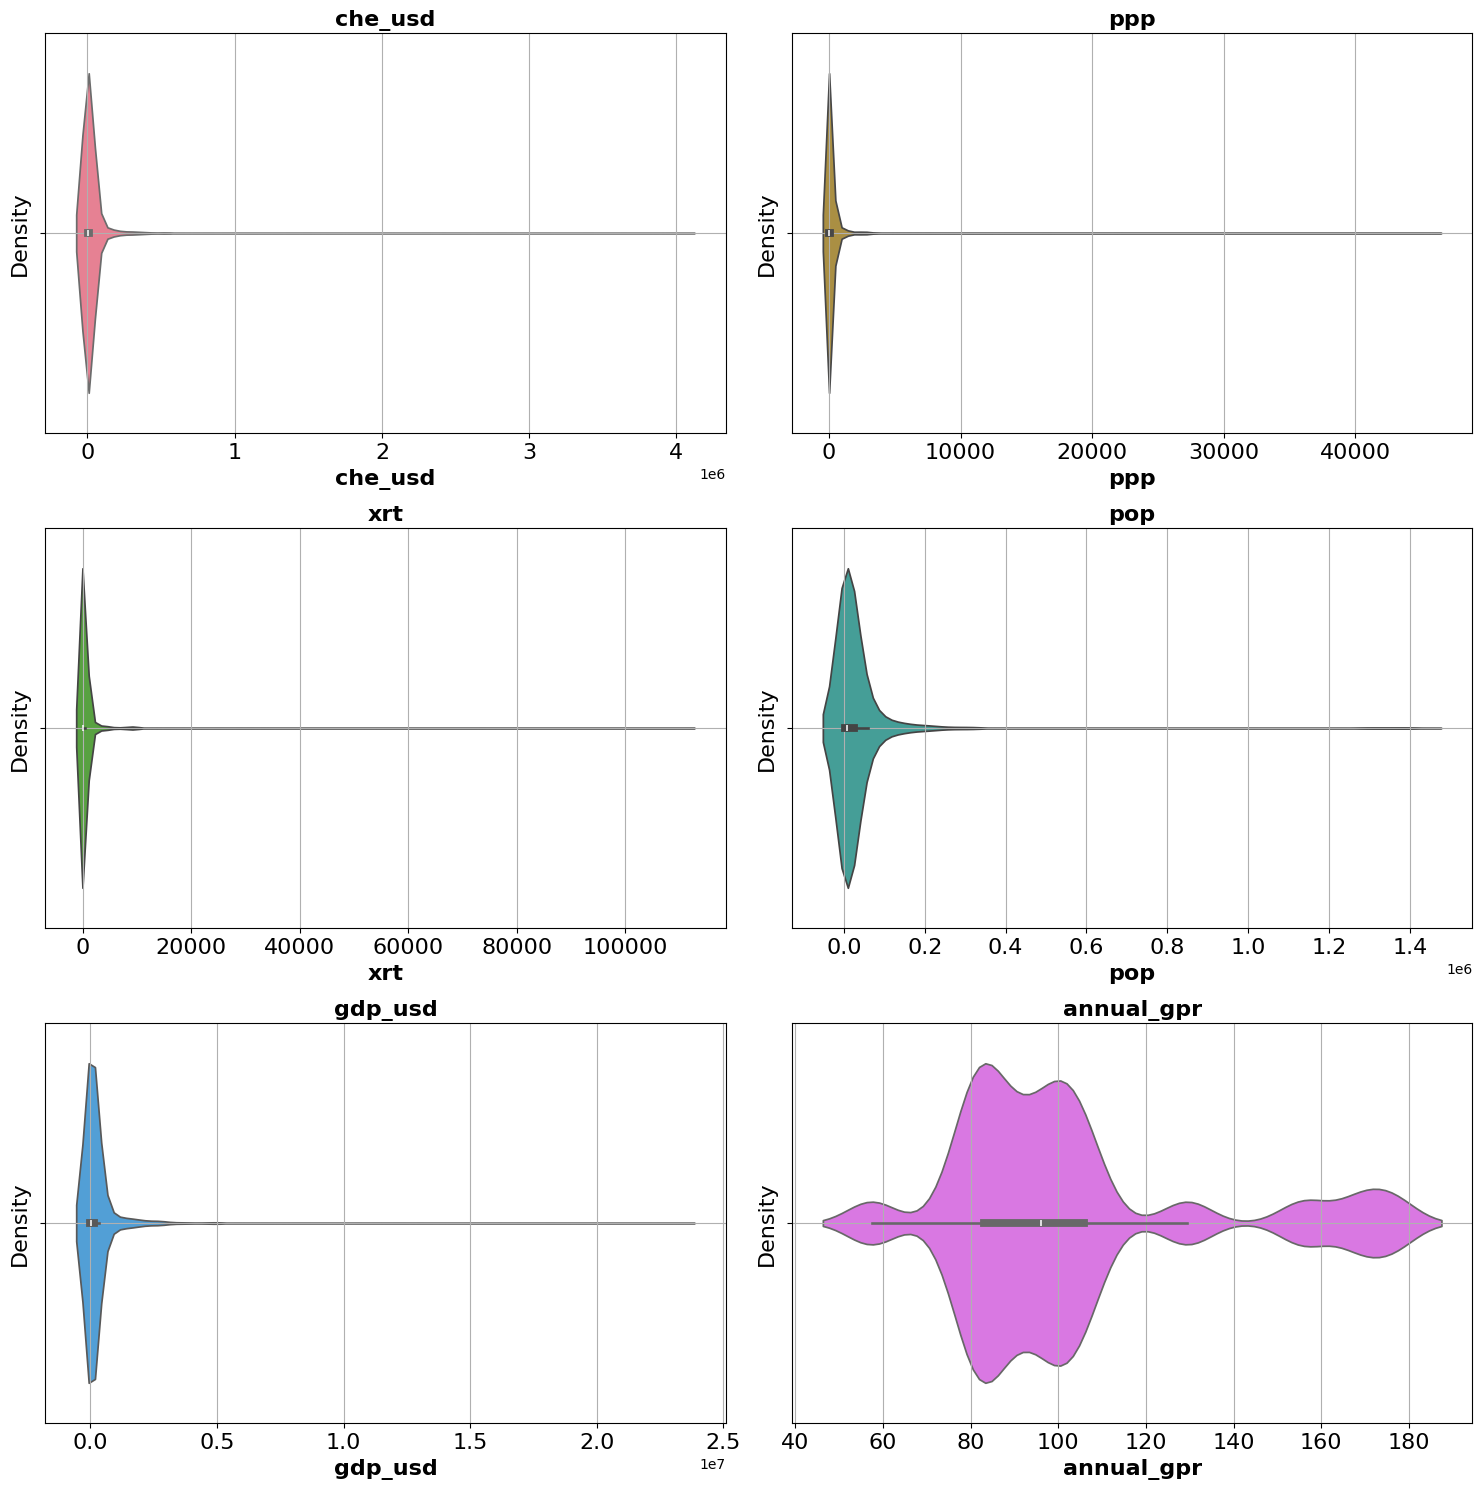

In [27]:

# Violin Plots
colors = sns.color_palette('husl', len(numerical_columns))  # 'husl' ensures distinct colors
num_vars = len(numerical_columns)
cols = 2  # Number of columns in the subplot grid
rows = (num_vars // cols) + (num_vars % cols > 0)  # Calculate rows needed
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
for i, col in enumerate(numerical_columns):
    row, col_index = divmod(i, cols)
    sns.violinplot(x=GHED_Final[col], ax=axes[row, col_index], color=colors[i])
    axes[row, col_index].set_title(f'{col}', fontsize=16, fontweight='bold')
    axes[row, col_index].set_xlabel(col, fontsize=16, fontweight='bold')
    axes[row, col_index].set_ylabel('Density', fontsize=16)
    axes[row, col_index].grid(True)
    axes[row, col_index].tick_params(axis='x', labelsize=16)

for i in range(num_vars, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


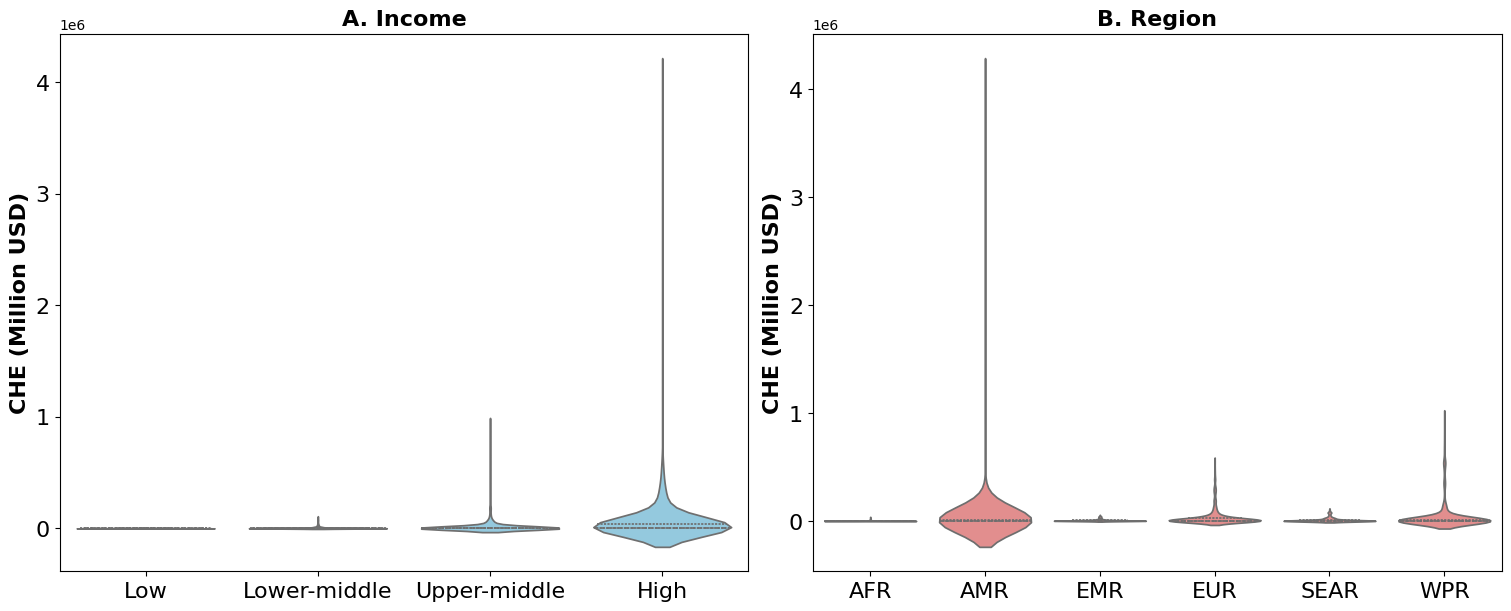

In [28]:
# Adv Violin Plots
income_summary = GHED_Final.groupby("income", as_index=False)["che_usd"].sum()
region_summary = GHED_Final.groupby("region", as_index=False)["che_usd"].sum()
fig, axes = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)

sns.violinplot(x="income", y="che_usd", data=GHED_dp, inner="quartile", scale="width", ax=axes[0], color="skyblue")
axes[0].set_title("A. Income", fontsize=16, fontweight='bold')
axes[0].set_xlabel("")
axes[0].set_ylabel("CHE (Million USD)", fontsize=16, fontweight='bold')
axes[0].tick_params(axis='x', labelsize=16)
axes[0].tick_params(axis='y', labelsize=16)

sns.violinplot(x="region", y="che_usd", data=GHED_dp, inner="quartile", scale="width", ax=axes[1], color="lightcoral")
axes[1].set_title("B. Region", fontsize=16, fontweight='bold')
axes[1].set_xlabel("")
axes[1].set_ylabel("CHE (Million USD)", fontsize=16, fontweight='bold')
axes[1].tick_params(axis='x', labelsize=16)
axes[1].tick_params(axis='y', labelsize=16)

plt.show()


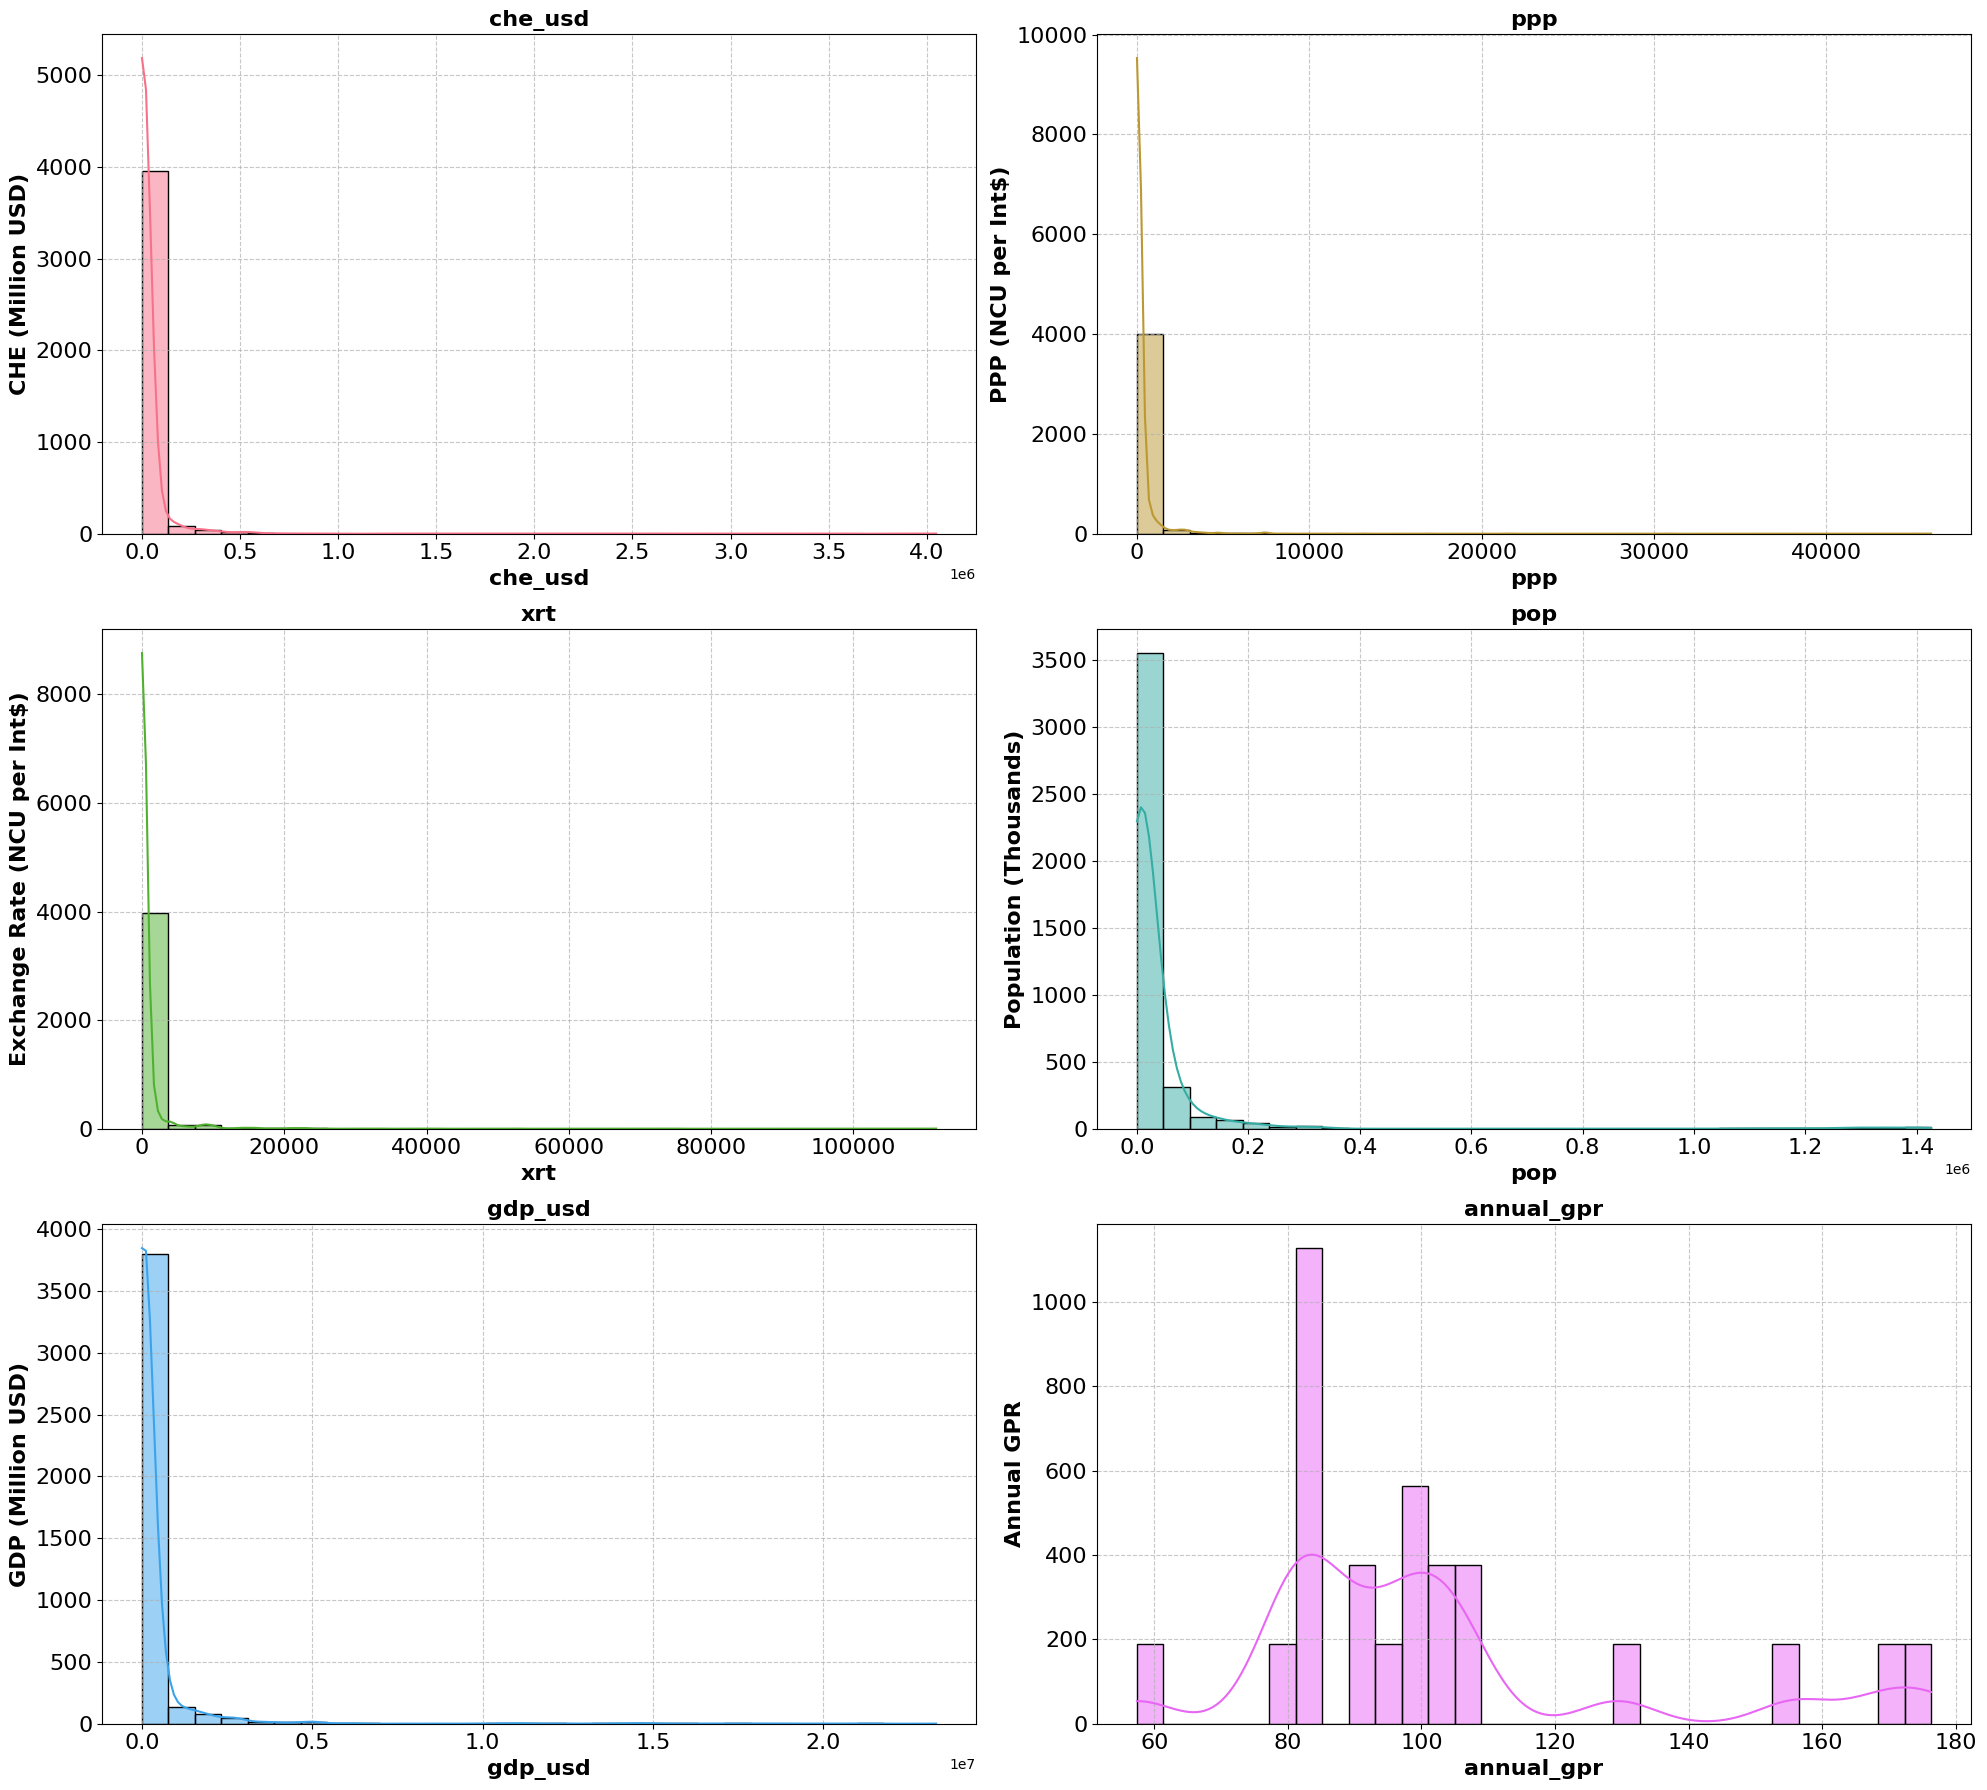

In [29]:
# Histograms

numerical_columns = ['che_usd', 'ppp', 'xrt', 'pop', 'gdp_usd', 'annual_gpr']
custom_y_labels = {
    'che_usd': 'CHE (Million USD)',
    'ppp': 'PPP (NCU per Int$)',
    'xrt': 'Exchange Rate (NCU per Int$)',
    'pop': 'Population (Thousands)',
    'gdp_usd': 'GDP (Million USD)',
    'annual_gpr': 'Annual GPR',
}

colors = sns.color_palette('husl', len(numerical_columns)) 
num_vars = len(numerical_columns)
cols = 2 
rows = (num_vars // cols) + (num_vars % cols > 0)  
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 6))

for i, col in enumerate(numerical_columns):
    row, col_index = divmod(i, cols)
    sns.histplot(
        GHED_Final[col].dropna(),
        kde=True,
        ax=axes[row, col_index],
        color=colors[i],
        bins=30,
    )
    axes[row, col_index].set_title(f'{col}', fontsize=16, fontweight='bold')
    axes[row, col_index].set_xlabel(col, fontsize=16, fontweight='bold')
    axes[row, col_index].set_ylabel(custom_y_labels[col], fontsize=16, fontweight='bold') 
    axes[row, col_index].tick_params(axis='both', which='major', labelsize=16)
    axes[row, col_index].grid(True, linestyle='--', alpha=0.7)


for i in range(num_vars, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


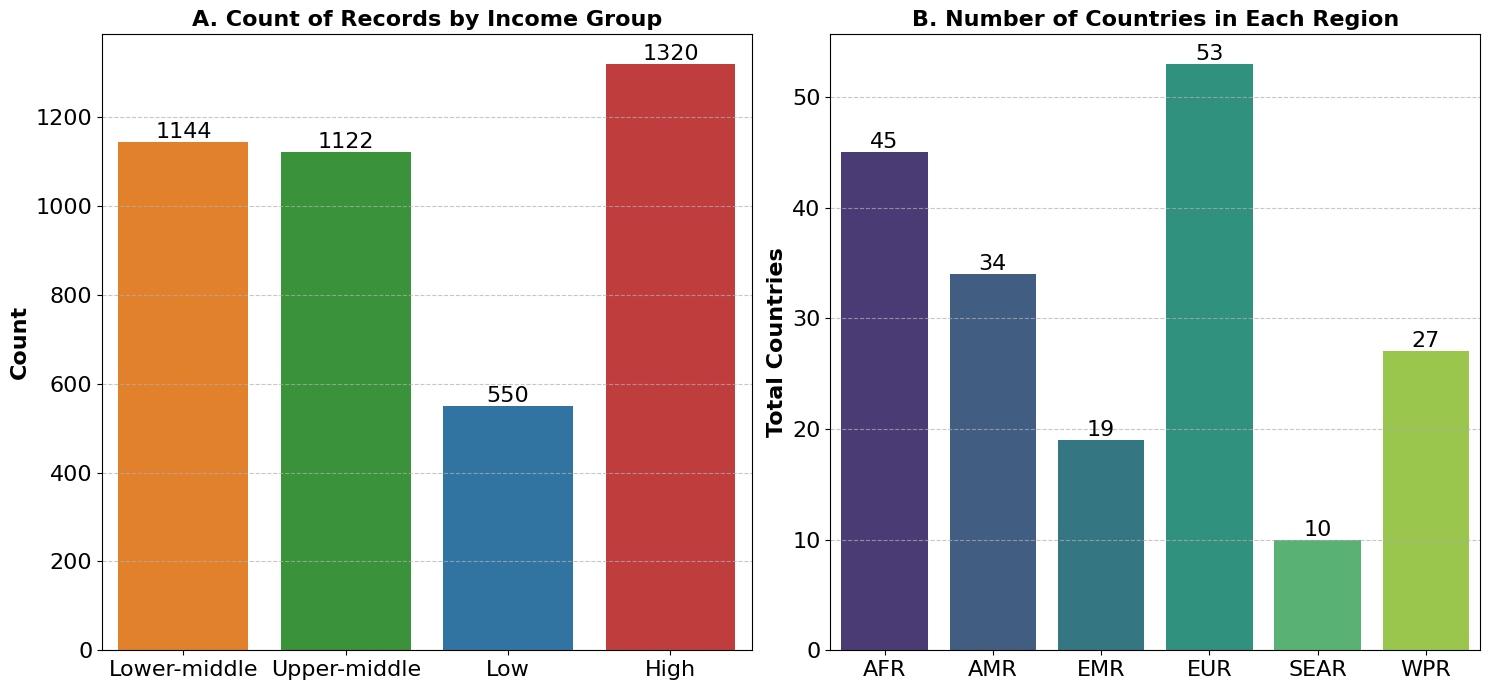

In [30]:
# Proportions
income_group_colors = {'Low': '#1f77b4', 'Lower-middle': '#ff7f0e', 'Upper-middle': '#2ca02c', 'High': '#d62728'}

GHED_Final['income_color'] = GHED_Final['income'].map(income_group_colors) 
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
sns.countplot(
    x='income', 
    data=GHED_Final, 
    ax=axes[0], 
    palette=income_group_colors, 
    linewidth=1.5
)
axes[0].set_title('A. Count of Records by Income Group', fontsize=16, fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('Count', fontsize=16, fontweight='bold')
axes[0].tick_params(axis='x', labelsize=16)
axes[0].tick_params(axis='y', labelsize=16)  
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Add annotations to the bars
for p in axes[0].patches:
    count = int(p.get_height())
    axes[0].annotate(
        f'{count}', 
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center', va='bottom', fontsize=16
    )

region_country_list = GHED_Final.groupby('region')['country'].unique()
region_country_total = region_country_list.apply(len).reset_index()
region_country_total.columns = ['Region', 'Total Countries']

sns.barplot(
    data=region_country_total, 
    x='Region', 
    y='Total Countries', 
    palette='viridis',  
    ax=axes[1], 
    linewidth=1.5
)
axes[1].set_title('B. Number of Countries in Each Region', fontsize=16, fontweight='bold')
axes[1].set_xlabel('')
axes[1].set_ylabel('Total Countries', fontsize=16, fontweight='bold')
axes[1].tick_params(axis='x', labelsize=16)
axes[1].tick_params(axis='y', labelsize=16) 
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add annotations to the bars
for p in axes[1].patches:
    total = int(p.get_height())
    axes[1].annotate(
        f'{total}', 
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center', va='bottom', fontsize=16
    )

plt.tight_layout()
plt.show()


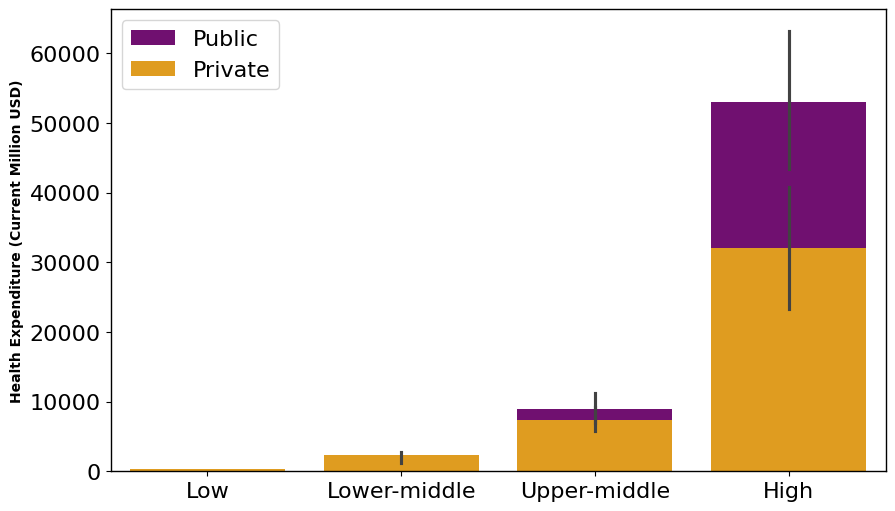

In [31]:
#Public vs Private HE vs Income Group
plt.figure(figsize=(10, 6))
sns.barplot(x="income", y="gghed_usd", data=GHED_dp, color="purple", label="Public")
sns.barplot(x="income", y="pvtd_usd", data=GHED_dp, color="orange", label="Private")

# Customise labels and legend
plt.ylabel("Health Expenditure (Current Million USD)", fontweight='bold')
plt.xlabel("")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Add black borders to the axes
ax = plt.gca()  # Get current axis
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

plt.show()

## Geographical Analysis

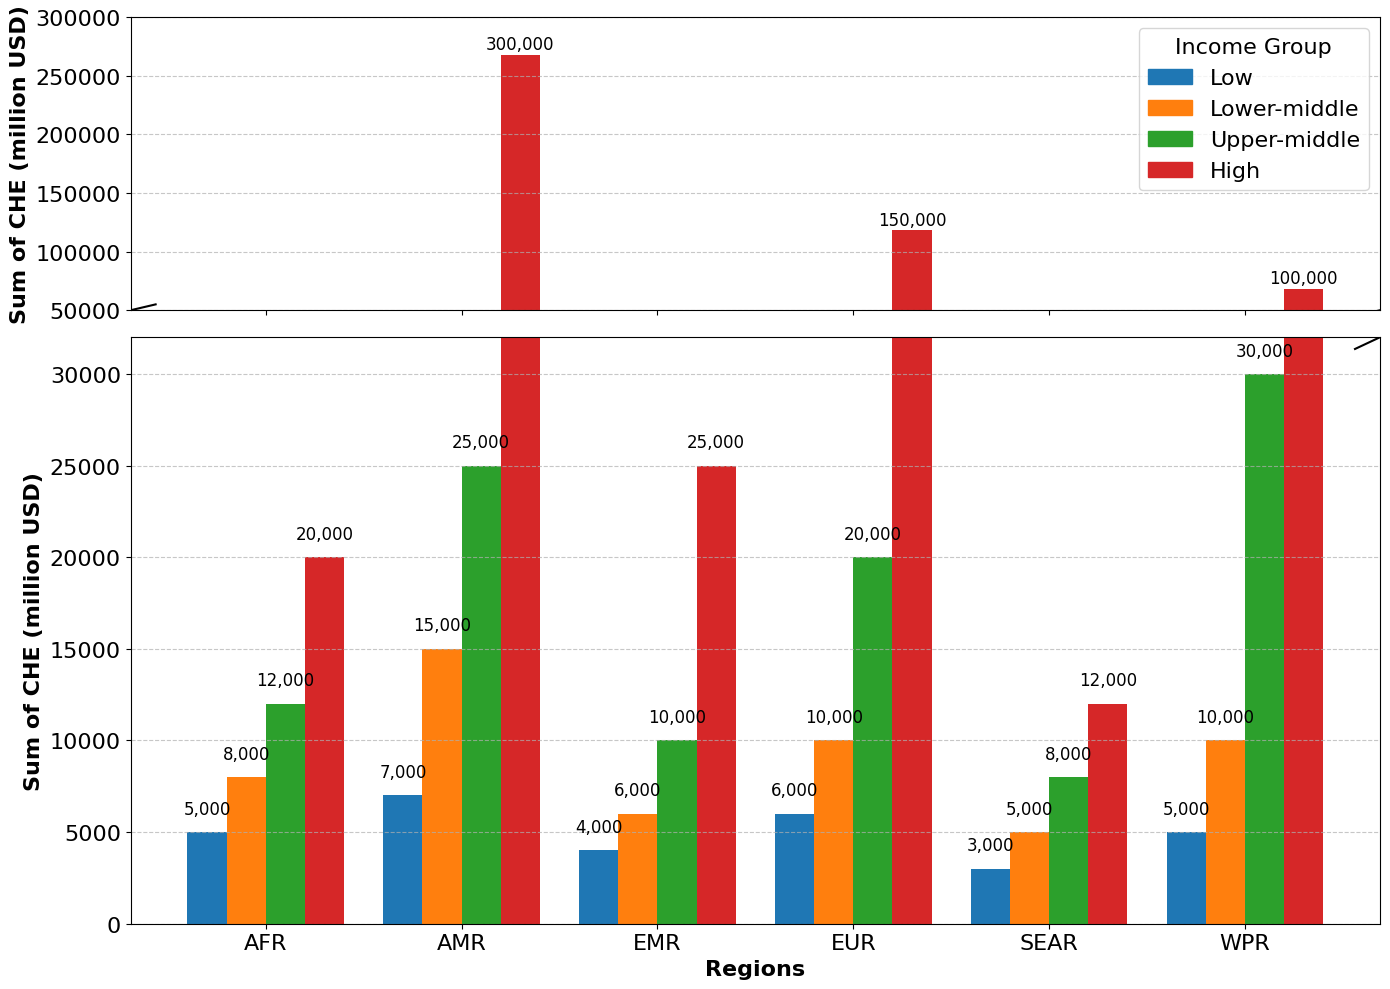

In [32]:
# CHE vs Region vs Income Group
regions = ['AFR', 'AMR', 'EMR', 'EUR', 'SEAR', 'WPR']  # Regions
income_groups = ['Low', 'Lower-middle', 'Upper-middle', 'High']
data = np.array([[5000, 8000, 12000, 20000], [7000, 15000, 25000, 300000], [4000, 6000, 10000, 25000],
                 [6000, 10000, 20000, 150000], [3000, 5000, 8000, 12000], [5000, 10000, 30000, 100000]])

x = np.arange(len(regions))
bar_width = 0.2
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 2]})

lower_y_limit = 32000
upper_y_limit = 50000 

for i, income_group in enumerate(income_groups):
    heights = data[:, i]
    
    ax2.bar(
        x + i * bar_width,
        np.where(heights > lower_y_limit, lower_y_limit, heights),
        width=bar_width,
        color=colors[i],
        label=income_group
    )
    
    for j, height in enumerate(heights):
        if height > lower_y_limit:
            ax1.bar(
                x[j] + i * bar_width,
                height - lower_y_limit,
                width=bar_width,
                color=colors[i]
            )

ax1.set_ylim(upper_y_limit, 300000) 
ax2.set_ylim(0, lower_y_limit)      

kwargs = dict(transform=ax1.transAxes, color='black', clip_on=True, linewidth=1.5)
ax1.plot((-0.02, 0.02), (-0.02, 0.02), **kwargs)
ax1.plot((0.98, 1.02), (-0.02, 0.02), **kwargs)

kwargs = dict(transform=ax2.transAxes, color='black', clip_on=True, linewidth=1.5)
ax2.plot((-0.02, 0.02), (0.98, 1.02), **kwargs)
ax2.plot((0.98, 1.02), (0.98, 1.02), **kwargs)

ax2.set_xlabel('Regions', fontsize=16, fontweight='bold')
ax2.set_xticks(x + bar_width * (len(income_groups) - 1) / 2)
ax2.set_xticklabels(regions, fontsize=16)
ax2.set_ylabel('Sum of CHE (million USD)', fontsize=16, fontweight='bold')
ax1.set_ylabel('Sum of CHE (million USD)', fontsize=16, fontweight='bold')

ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)

for i, income_group in enumerate(income_groups):
    heights = data[:, i]
    for j, height in enumerate(heights):
        if height <= lower_y_limit:
            ax2.text(
                x[j] + i * bar_width, height + 1000, f'{height:,}', ha='center', fontsize=12
            )
        else:
            ax1.text(
                x[j] + i * bar_width, height - lower_y_limit + 5000, f'{height:,}', ha='center', fontsize=12
            )

income_group_colors = {'Low': '#1f77b4', 'Lower-middle': '#ff7f0e', 'Upper-middle': '#2ca02c', 'High': '#d62728'}
legend_patches = [Patch(color=color, label=income_group) for income_group, color in income_group_colors.items()]
ax1.legend(handles=legend_patches, title='Income Group', fontsize=16, title_fontsize=16, loc='upper right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [33]:
region_country_list = GHED_Final.groupby('region')['country'].unique()

region_country_dict = {region: list(countries) for region, countries in region_country_list.items()}

region_country_total = region_country_list.apply(len).reset_index()
region_country_total.columns = ['Region', 'Total Countries']

print("List of countries in each region:")
for region, countries in region_country_dict.items():
    print(f"{region}: {countries}")

print("\nTotal number of countries in each region:")
print(region_country_total)


List of countries in each region:
AFR: ['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo', "Côte d'Ivoire", 'Democratic Republic of the Congo', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'South Africa', 'Togo', 'Uganda', 'United Republic of Tanzania', 'Zambia']
AMR: ['Antigua and Barbuda', 'Argentina', 'Bahamas', 'Barbados', 'Belize', 'Bolivia (Plurinational State of)', 'Brazil', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Dominica', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Grenada', 'Guatemala', 'Guyana', 'Haiti', 'Honduras', 'Jamaica', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay', 'Peru', 'Saint

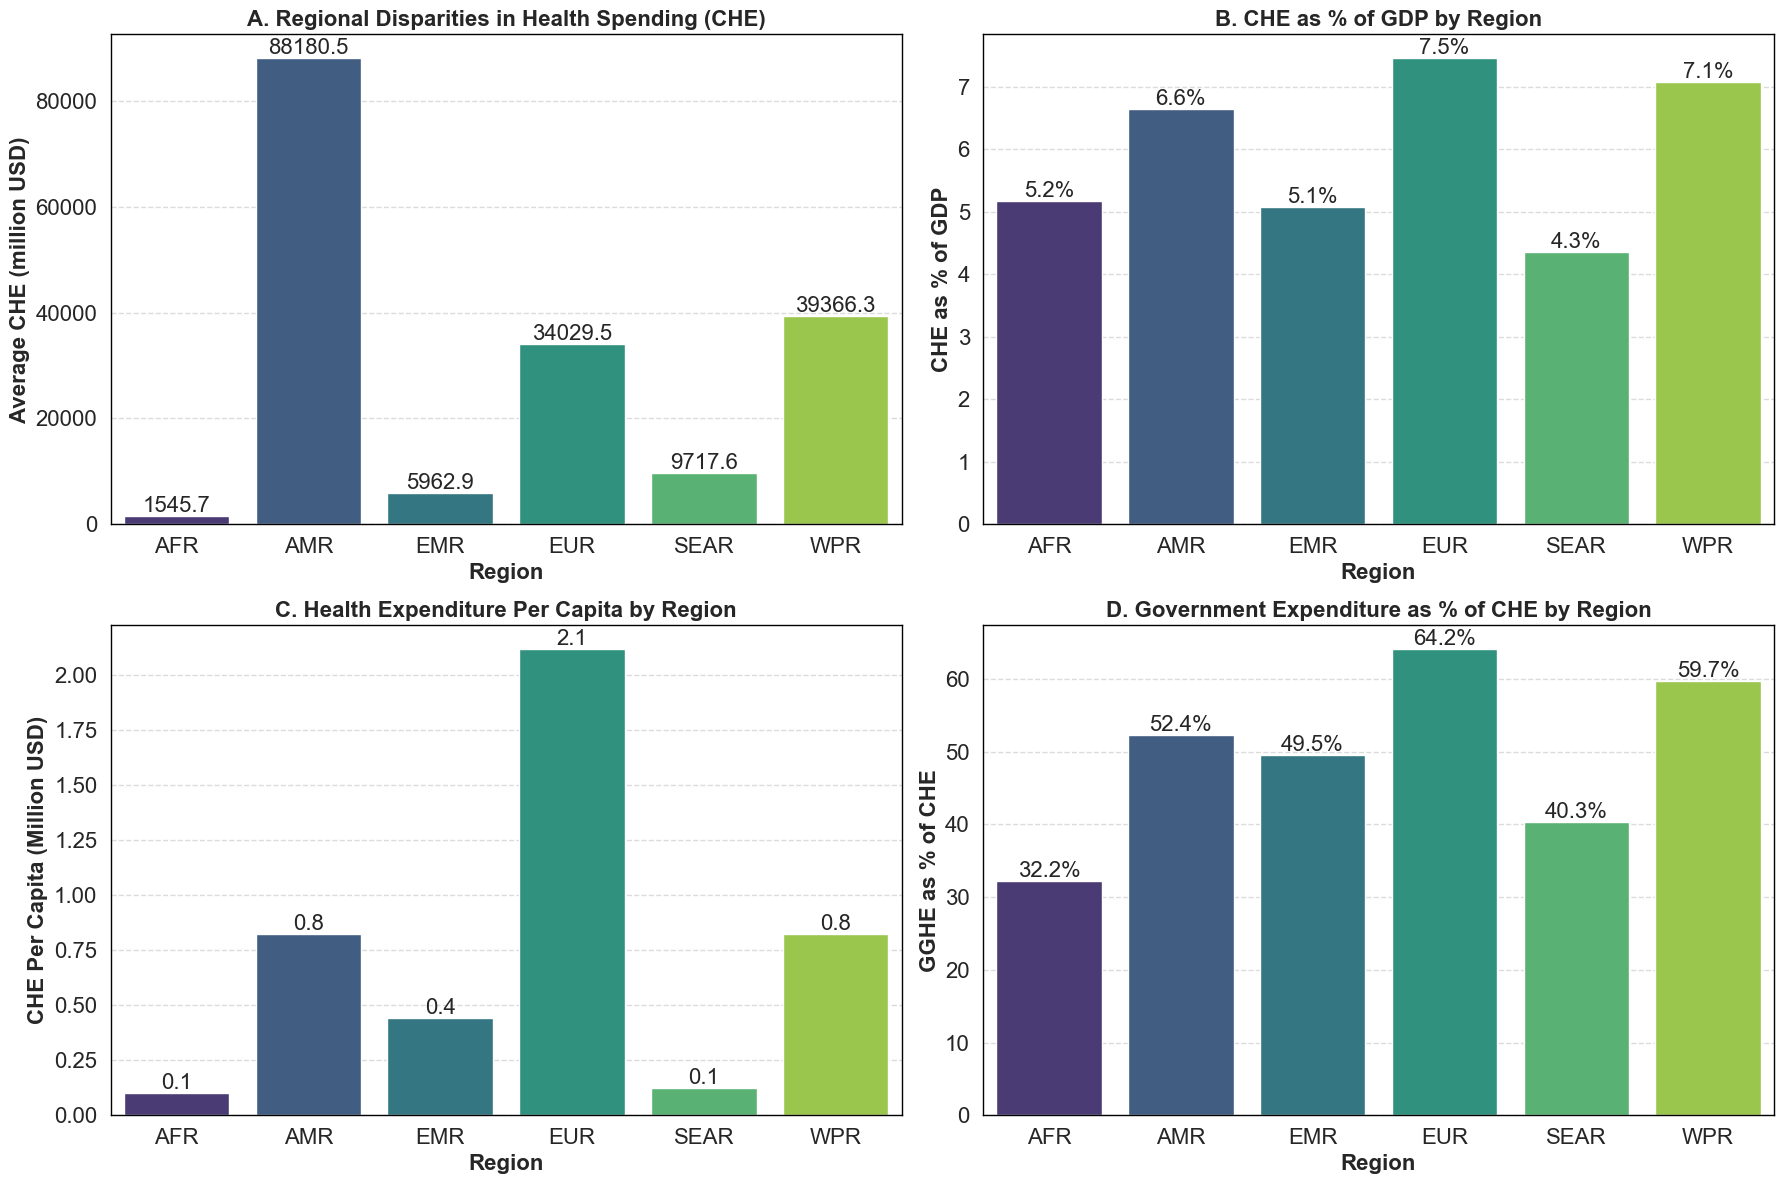

In [34]:
# Calculated Metrics
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
regional_che = GHED_Final.groupby('region')['che_usd'].mean().reset_index()
regional_che.columns = ['Region', 'Average CHE (million USD)']
sns.barplot(data=regional_che, x='Region', y='Average CHE (million USD)', palette='viridis', ax=axes[0, 0])
axes[0, 0].set_title('A. Regional Disparities in Health Spending (CHE)', fontsize=16, fontweight='bold')
axes[0, 0].set_xlabel('Region', fontsize=16, fontweight='bold')
axes[0, 0].set_ylabel('Average CHE (million USD)', fontsize=16, fontweight='bold')
axes[0, 0].tick_params(axis='x', labelsize=16)
axes[0, 0].tick_params(axis='y', labelsize=16)
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

for p in axes[0, 0].patches:
    axes[0, 0].annotate(f'{p.get_height():.1f}', 
                        (p.get_x() + p.get_width() / 2, p.get_height()), 
                        ha='center', va='bottom', fontsize=16)

GHED_Final['CHE_to_GDP'] = (GHED_Final['che_usd'] / GHED_Final['gdp_usd']) * 100
regional_che_to_gdp = GHED_Final.groupby('region')['CHE_to_GDP'].mean().reset_index()
regional_che_to_gdp.columns = ['Region', 'CHE as % of GDP']
sns.barplot(data=regional_che_to_gdp, x='Region', y='CHE as % of GDP', palette='viridis', ax=axes[0, 1])
axes[0, 1].set_title('B. CHE as % of GDP by Region', fontsize=16, fontweight='bold')
axes[0, 1].set_xlabel('Region', fontsize=16, fontweight='bold')
axes[0, 1].set_ylabel('CHE as % of GDP', fontsize=16, fontweight='bold')
axes[0, 1].tick_params(axis='x', labelsize=16)
axes[0, 1].tick_params(axis='y', labelsize=16)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

for p in axes[0, 1].patches:
    axes[0, 1].annotate(f'{p.get_height():.1f}%', 
                        (p.get_x() + p.get_width() / 2, p.get_height()), 
                        ha='center', va='bottom', fontsize=16)

GHED_Final['CHE_per_capita'] = GHED_Final['che_usd'] / GHED_Final['pop']
regional_che_per_capita = GHED_Final.groupby('region')['CHE_per_capita'].mean().reset_index()
regional_che_per_capita.columns = ['Region', 'CHE Per Capita']
sns.barplot(data=regional_che_per_capita, x='Region', y='CHE Per Capita', palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('C. Health Expenditure Per Capita by Region', fontsize=16, fontweight='bold')
axes[1, 0].set_xlabel('Region', fontsize=16, fontweight='bold')
axes[1, 0].set_ylabel('CHE Per Capita (Million USD)', fontsize=16, fontweight='bold')
axes[1, 0].tick_params(axis='x', labelsize=16)
axes[1, 0].tick_params(axis='y', labelsize=16)
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

for p in axes[1, 0].patches:
    axes[1, 0].annotate(f'{p.get_height():.1f}', 
                        (p.get_x() + p.get_width() / 2, p.get_height()), 
                        ha='center', va='bottom', fontsize=16)

GHED_Final['GGHE_to_CHE'] = (GHED_Final['gghed_usd'] / GHED_Final['che_usd']) * 100
regional_gghe_to_che = GHED_Final.groupby('region')['GGHE_to_CHE'].mean().reset_index()
regional_gghe_to_che.columns = ['Region', 'GGHE as % of CHE']
sns.barplot(data=regional_gghe_to_che, x='Region', y='GGHE as % of CHE', palette='viridis', ax=axes[1, 1])
axes[1, 1].set_title('D. Government Expenditure as % of CHE by Region', fontsize=16, fontweight='bold')
axes[1, 1].set_xlabel('Region', fontsize=16, fontweight='bold')
axes[1, 1].set_ylabel('GGHE as % of CHE', fontsize=16, fontweight='bold')
axes[1, 1].tick_params(axis='x', labelsize=16)
axes[1, 1].tick_params(axis='y', labelsize=16)
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

for p in axes[1, 1].patches:
    axes[1, 1].annotate(f'{p.get_height():.1f}%', 
                        (p.get_x() + p.get_width() / 2, p.get_height()), 
                        ha='center', va='bottom', fontsize=16)

for ax in axes.flat:
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

plt.tight_layout()
plt.show()


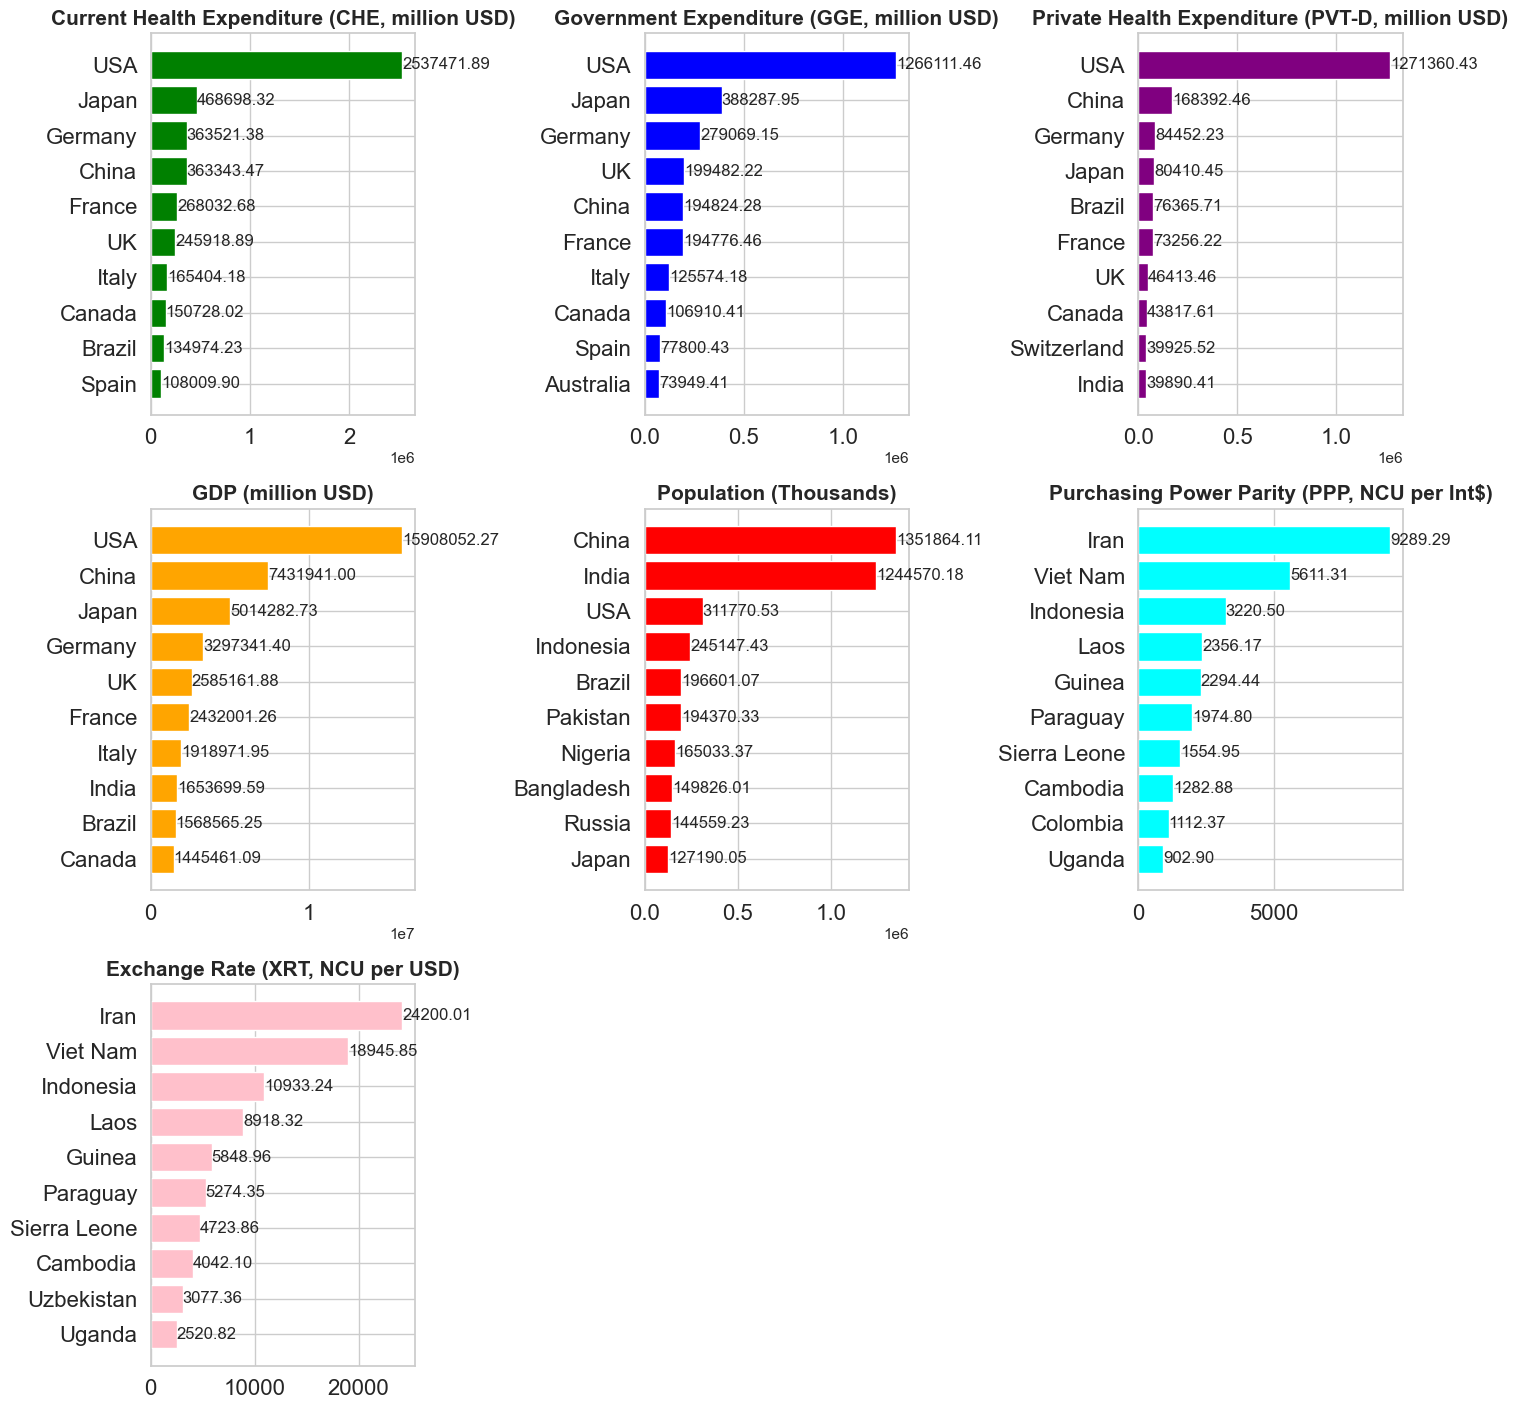

In [35]:
# Top 10 Countries by Key VAriable 

GHED_temp = GHED_Final.copy()

GHED_temp['country'] = GHED_temp['country'].replace({
    'United Kingdom of Great Britain and Northern Ireland': 'UK',
    "Lao People's Democratic Republic": 'Laos',
    'Iran (Islamic Republic of)': 'Iran',
    'United States of America': 'USA',
    'Russian Federation': 'Russia'
})

indicators = [
    'che_usd', 'gghed_usd', 'pvtd_usd',
    'gdp_usd', 'pop', 'ppp',          
    'xrt'                             
]
titles = [
    'Current Health Expenditure (CHE, million USD)',
    'Government Expenditure (GGE, million USD)',
    'Private Health Expenditure (PVT-D, million USD)',
    'GDP (million USD)',
    'Population (Thousands)',
    'Purchasing Power Parity (PPP, NCU per Int$)',
    'Exchange Rate (XRT, NCU per USD)',
]
colors = ['green', 'blue', 'purple', 'orange', 'red', 'cyan', 'pink']

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()  

for i, indicator in enumerate(indicators):
    ranked_data = GHED_temp.groupby('country')[indicator].mean().sort_values(ascending=False).reset_index()
    
    axes[i].barh(ranked_data['country'][:10], ranked_data[indicator][:10], color=colors[i])
    axes[i].set_title(titles[i], fontsize=15, fontweight='bold') 
    axes[i].invert_yaxis() 
    
    axes[i].tick_params(axis='x', labelsize=16)
    axes[i].tick_params(axis='y', labelsize=16)
    
    for idx, value in enumerate(ranked_data[indicator][:10]):
        axes[i].text(value, idx, f'{value:.2f}', va='center', fontsize=12)

for j in range(len(indicators), len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


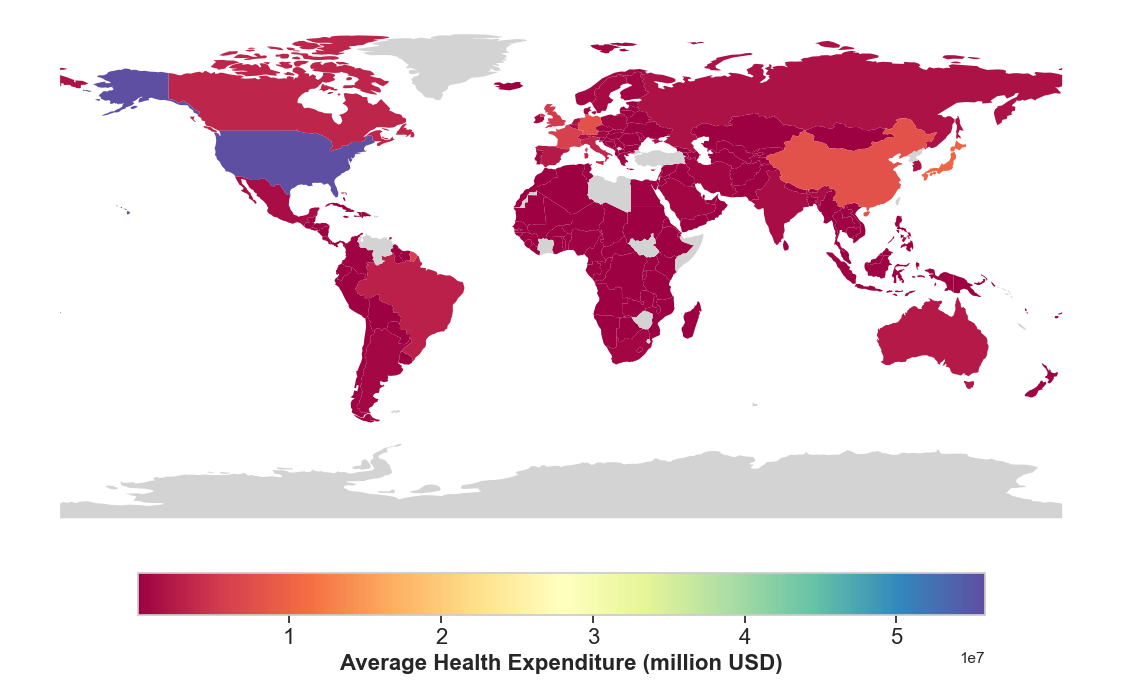

In [36]:
# Map - Avg Health Expenditure
GHED_Final_temp = GHED_Final.copy()
world = gpd.read_file('ne_110m_admin_0_countries.shp') 

GHED_Final_temp['country'] = GHED_Final_temp['country'].str.strip().str.lower()
world['NAME'] = world['NAME'].str.strip().str.lower()

country_mapping = {
    'cabo verde': 'cape verde',
    'central african republic': 'central african rep.',
    "côte d'ivoire": "ivory coast",
    'democratic republic of the congo': 'dem. rep. congo',
    'equatorial guinea': 'eq. guinea',
    'eswatini': 'swaziland', 
    'united republic of tanzania': 'tanzania',
    'bolivia (plurinational state of)': 'bolivia',
    'dominican republic': 'dominican rep.',
    'saint kitts and nevis': 'st. kitts and nevis',
    'saint lucia': 'st. lucia',
    'saint vincent and the grenadines': 'st. vincent and the grenadines',
    'iran (islamic republic of)': 'iran',
    "lao people's democratic republic": 'laos',
    'russian federation': 'russia',
    'netherlands (kingdom of the)': 'netherlands',
    'republic of korea': 'south korea',
    'syrian arab republic': 'syria',
    'venezuela (bolivarian republic of)': 'venezuela',
    'united kingdom of great britain and northern ireland': 'united kingdom',
    'brunei darussalam': 'brunei',
    'timor-leste': 'timor-leste',
    'republic of moldova': 'moldova',
    'bosnia and herzegovina': 'bosnia and herz.',
    'viet nam': 'vietnam',
}

GHED_Final_temp['country'] = GHED_Final_temp['country'].replace(country_mapping)

merged = world.merge(
    GHED_Final_temp.groupby('country')['che_usd'].sum().reset_index(),
    left_on='NAME',
    right_on='country',
    how='left'
)

fig, ax = plt.subplots(figsize=(15, 7))
merged.plot(
    column='che_usd',
    cmap='Spectral',
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'},
    legend=False,
    ax=ax,
    edgecolor='none'  
)

sm = plt.cm.ScalarMappable(cmap='Spectral', norm=plt.Normalize(vmin=merged['che_usd'].min(), vmax=merged['che_usd'].max()))
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.07, pad=0.05)
cbar.set_label('Average Health Expenditure (million USD)', fontsize=16, fontweight='bold')
cbar.ax.tick_params(labelsize=16)  
sm.set_array([])

ax.set_axis_off()
plt.tight_layout()
plt.show()


## Temporal trends

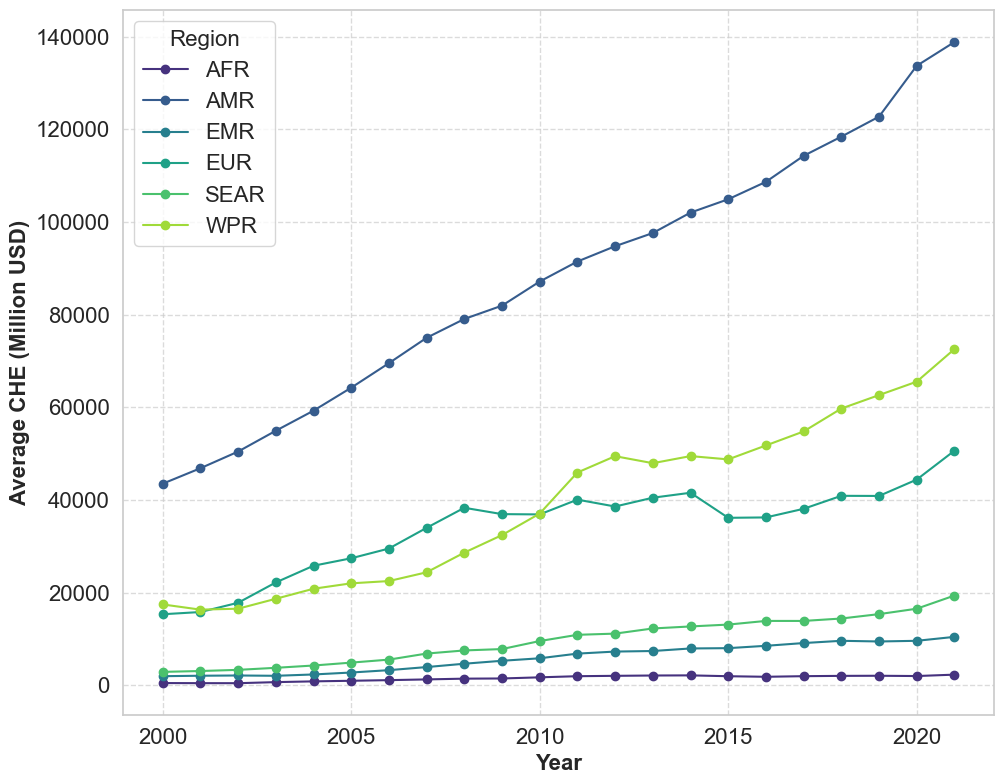

In [37]:
# CHE vs Region
regional_health_trends = GHED_Final.groupby(['year', 'region'])['che_usd'].mean().unstack()
num_regions = len(regional_health_trends.columns)
colors = sns.color_palette("viridis", num_regions)  
plt.figure(figsize=(12, 8))
for region, color in zip(regional_health_trends.columns, colors):
    plt.plot(
        regional_health_trends.index, 
        regional_health_trends[region], 
        marker='o', 
        linestyle='-', 
        color=color, 
        label=region
    )

plt.xlabel('Year', fontsize=16, fontweight='bold')
plt.ylabel('Average CHE (Million USD)', fontsize=16, fontweight='bold')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(title='Region', fontsize=16, title_fontsize=16, loc='upper left')
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0, 0.85, 1]) 

plt.show()


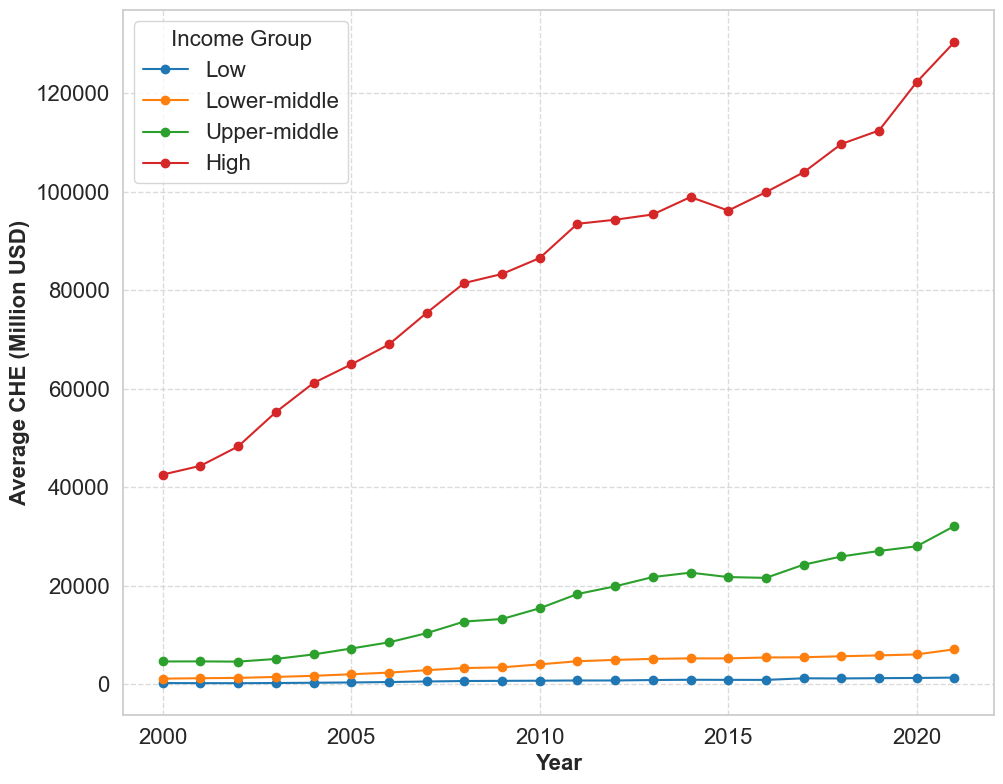

In [38]:
# CHE vs INcome Groups
income_group_colors = {
    'Low': '#1f77b4',          
    'Lower-middle': '#ff7f0e',  
    'Upper-middle': '#2ca02c',  
    'High': '#d62728'        
}

income_health_trends = GHED_Final.groupby(['year', 'income'])['che_usd'].mean().unstack()

plt.figure(figsize=(12, 8))
for income_group, color in income_group_colors.items():
    if income_group in income_health_trends.columns:
        plt.plot(
            income_health_trends.index, 
            income_health_trends[income_group], 
            marker='o', 
            linestyle='-', 
            color=color, 
            label=income_group
        )

plt.xlabel('Year', fontsize=16, fontweight='bold')
plt.ylabel('Average CHE (Million USD)', fontsize=16, fontweight='bold')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(title='Income Group', fontsize=16, title_fontsize=16, loc='upper left')
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0, 0.85, 1])  

plt.show()


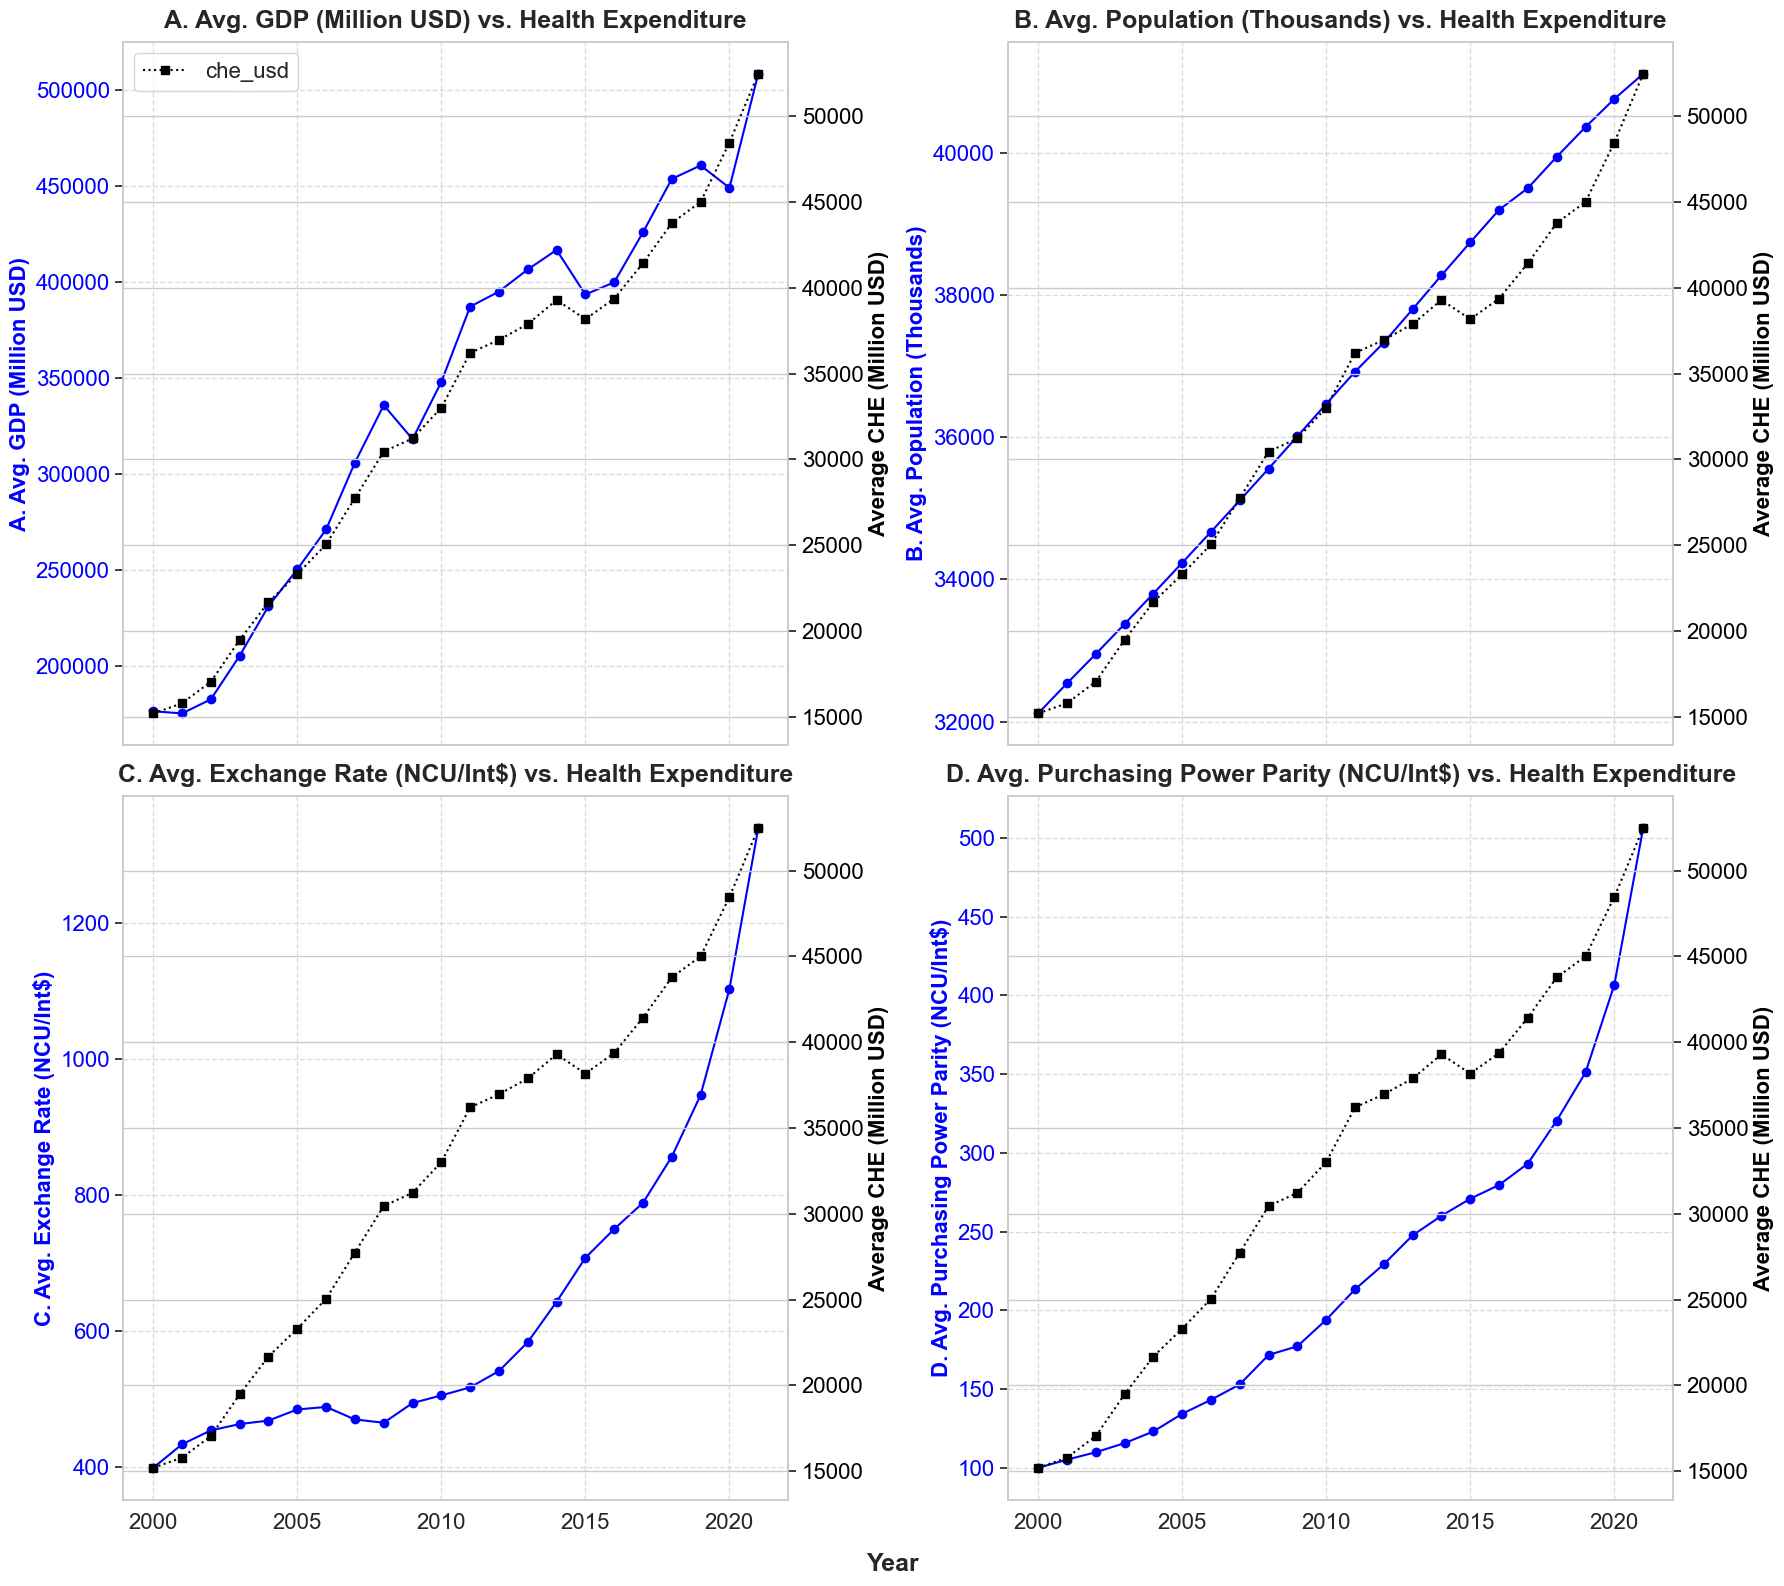

In [39]:
# CHE vs Macroeconomic Factor
indicators = ['gdp_usd', 'pop', 'xrt', 'ppp'] 
health_metrics = ['che_usd'] 

y_primary_titles = ['A. Avg. GDP (Million USD)', 'B. Avg. Population (Thousands)', 'C. Avg. Exchange Rate (NCU/Int$)', 'D. Avg. Purchasing Power Parity (NCU/Int$)']
y_secondary_title = 'Average CHE (Million USD)'

financial_trends = GHED_Final.groupby('year')[indicators + health_metrics].mean()

fig, axes = plt.subplots(2, 2, figsize=(18, 16), sharex=True, sharey=False)  
axes = axes.flatten() 

health_colors = ['black'] 

for i, (indicator, primary_title) in enumerate(zip(indicators, y_primary_titles)):
    ax = axes[i]
    
    ax.plot(financial_trends.index, financial_trends[indicator], marker='o', label=f'{indicator} (Mean)', color='blue')
    ax.set_ylabel(primary_title, fontsize=16, fontweight='bold', color='blue')  
    ax.tick_params(axis='y', labelcolor='blue', labelsize=16)

    ax2 = ax.twinx()
    for metric, color in zip(health_metrics, health_colors):
        ax2.plot(financial_trends.index, financial_trends[metric], marker='s', label=metric, color=color, linestyle='dotted')
        ax2.tick_params(axis='y', labelcolor='black', labelsize=16)  
        ax2.set_ylabel(y_secondary_title, fontsize=16, fontweight='bold', color='black')  

    ax.grid(visible=True, linestyle='--', alpha=0.7)

    if i == 0:  
        lines, labels = ax2.get_legend_handles_labels()  
        ax2.legend(lines, labels, loc='upper left', fontsize=16)

    ax.set_title(f'{primary_title} vs. Health Expenditure', fontsize=18, fontweight='bold', pad=10)

    ax.tick_params(axis='x', labelsize=16)

fig.supxlabel('Year', fontsize=18, fontweight='bold')

plt.tight_layout()
plt.show()


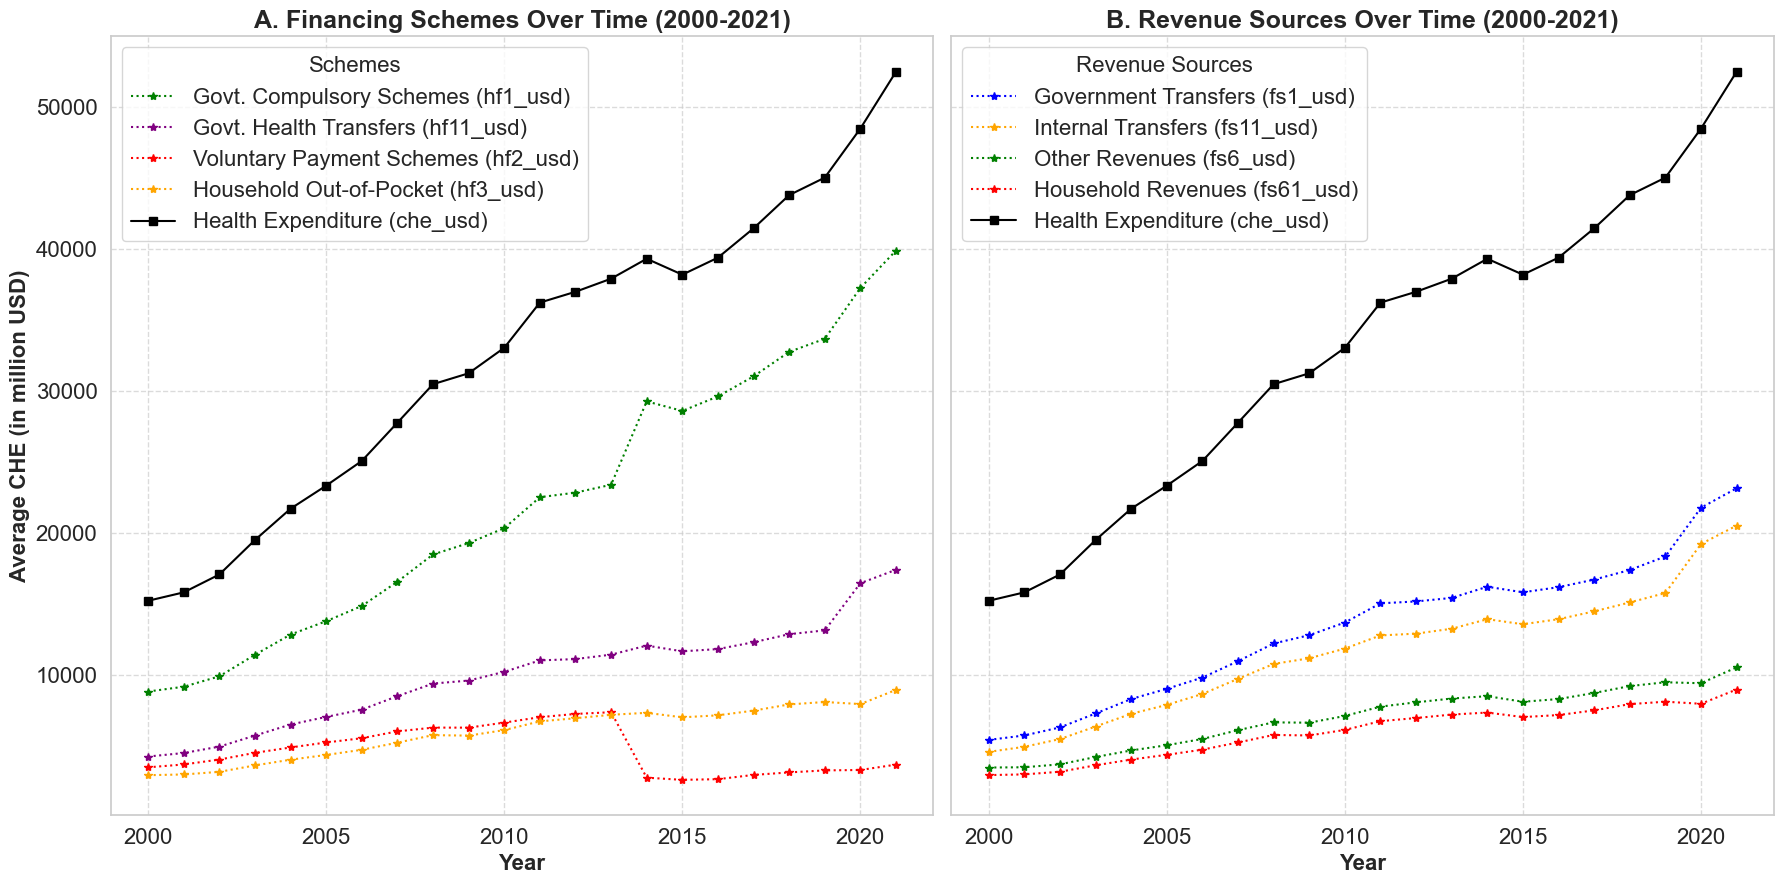

In [40]:
# Schemes & Revenue Data
financing_schemes_trends = GHED_Final.groupby('year')[['hf1_usd', 'hf11_usd', 'hf2_usd', 'hf3_usd', 'che_usd']].mean()
revenue_trends = GHED_Final.groupby('year')[['fs1_usd', 'fs11_usd', 'fs6_usd', 'fs61_usd', 'che_usd']].mean()

fig, axes = plt.subplots(1, 2, figsize=(18, 9), sharey=True)

axes[0].plot(financing_schemes_trends.index, financing_schemes_trends['hf1_usd'], 
             marker='*', linestyle='dotted', color='green', label='Govt. Compulsory Schemes (hf1_usd)')
axes[0].plot(financing_schemes_trends.index, financing_schemes_trends['hf11_usd'], 
             marker='*', linestyle='dotted', color='purple', label='Govt. Health Transfers (hf11_usd)')
axes[0].plot(financing_schemes_trends.index, financing_schemes_trends['hf2_usd'], 
             marker='*', linestyle='dotted', color='red', label='Voluntary Payment Schemes (hf2_usd)')
axes[0].plot(financing_schemes_trends.index, financing_schemes_trends['hf3_usd'], 
             marker='*', linestyle='dotted', color='orange', label='Household Out-of-Pocket (hf3_usd)')
axes[0].plot(financing_schemes_trends.index, financing_schemes_trends['che_usd'], 
             marker='s', linestyle='-', color='black', label='Health Expenditure (che_usd)')

axes[0].set_title('A. Financing Schemes Over Time (2000-2021)', fontsize=18, fontweight='bold')
axes[0].set_xlabel('Year', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Average CHE (in million USD)', fontsize=16, fontweight='bold')
axes[0].legend(title='Schemes', fontsize=16, title_fontsize=16, loc='upper left')
axes[0].tick_params(axis='both', which='major', labelsize=16)  
axes[0].grid(visible=True, linestyle='--', alpha=0.7)

axes[1].plot(revenue_trends.index, revenue_trends['fs1_usd'], 
             marker='*', linestyle='dotted', color='blue', label='Government Transfers (fs1_usd)')
axes[1].plot(revenue_trends.index, revenue_trends['fs11_usd'], 
             marker='*', linestyle='dotted', color='orange', label='Internal Transfers (fs11_usd)')
axes[1].plot(revenue_trends.index, revenue_trends['fs6_usd'], 
             marker='*', linestyle='dotted', color='green', label='Other Revenues (fs6_usd)')
axes[1].plot(revenue_trends.index, revenue_trends['fs61_usd'], 
             marker='*', linestyle='dotted', color='red', label='Household Revenues (fs61_usd)')
axes[1].plot(revenue_trends.index, revenue_trends['che_usd'], 
             marker='s', linestyle='-', color='black', label='Health Expenditure (che_usd)')

axes[1].set_title('B. Revenue Sources Over Time (2000-2021)', fontsize=18, fontweight='bold')
axes[1].set_xlabel('Year', fontsize=16, fontweight='bold')
axes[1].legend(title='Revenue Sources', fontsize=16, title_fontsize=16, loc='upper left')
axes[1].tick_params(axis='both', which='major', labelsize=16)  
axes[1].grid(visible=True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


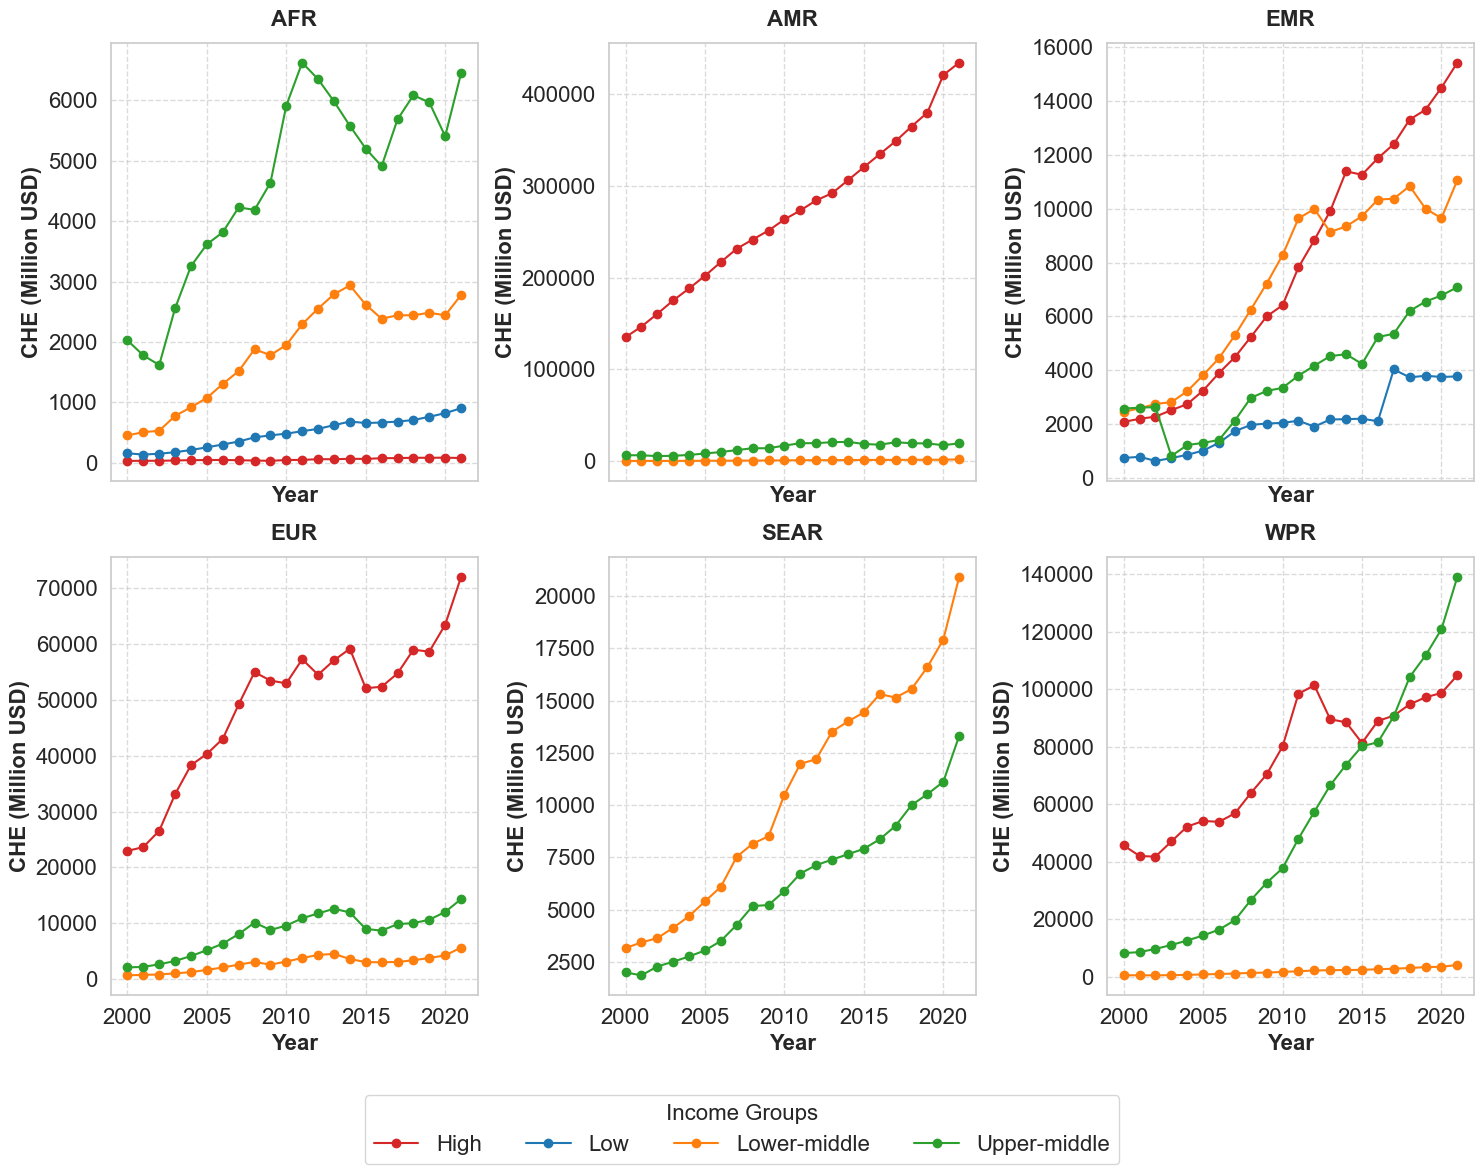

In [41]:
# Region vs Income 

income_group_colors = {'Low': '#1f77b4', 'Lower-middle': '#ff7f0e', 'Upper-middle': '#2ca02c', 'High': '#d62728'}

regional_income_trends = GHED_Final.groupby(['year', 'region', 'income'])['che_usd'].mean().unstack(['region', 'income'])

regions = regional_income_trends.columns.levels[0] 
income_groups = regional_income_trends.columns.levels[1] 

fig, axes = plt.subplots(2, 3, figsize=(15, 12), sharex=True, sharey=False) 
axes = axes.flatten() 

for ax, region in zip(axes, regions):
    for income_group in income_groups:
        if (region, income_group) in regional_income_trends.columns:
            ax.plot(regional_income_trends.index, 
                    regional_income_trends[(region, income_group)], 
                    marker='o', linestyle='-', color=income_group_colors[income_group], label=income_group)
    
    ax.set_title(f'{region}', fontsize=16, fontweight='bold', pad=12)
    ax.set_xlabel('Year', fontsize=16, fontweight='bold')
    ax.set_ylabel('CHE (Million USD)', fontsize=16, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.grid(visible=True, linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(True) 
    ax.spines['right'].set_visible(True) 

for ax in axes[len(regions):]:
    ax.axis('off')

lines, labels = axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper center', fontsize=16, title='Income Groups', 
           title_fontsize=16, ncol=len(income_groups), bbox_to_anchor=(0.5, 0.04))

plt.tight_layout(rect=[0, 0.05, 1, 0.95]) 
plt.show()

## Grouped Pair plot for overall understanding

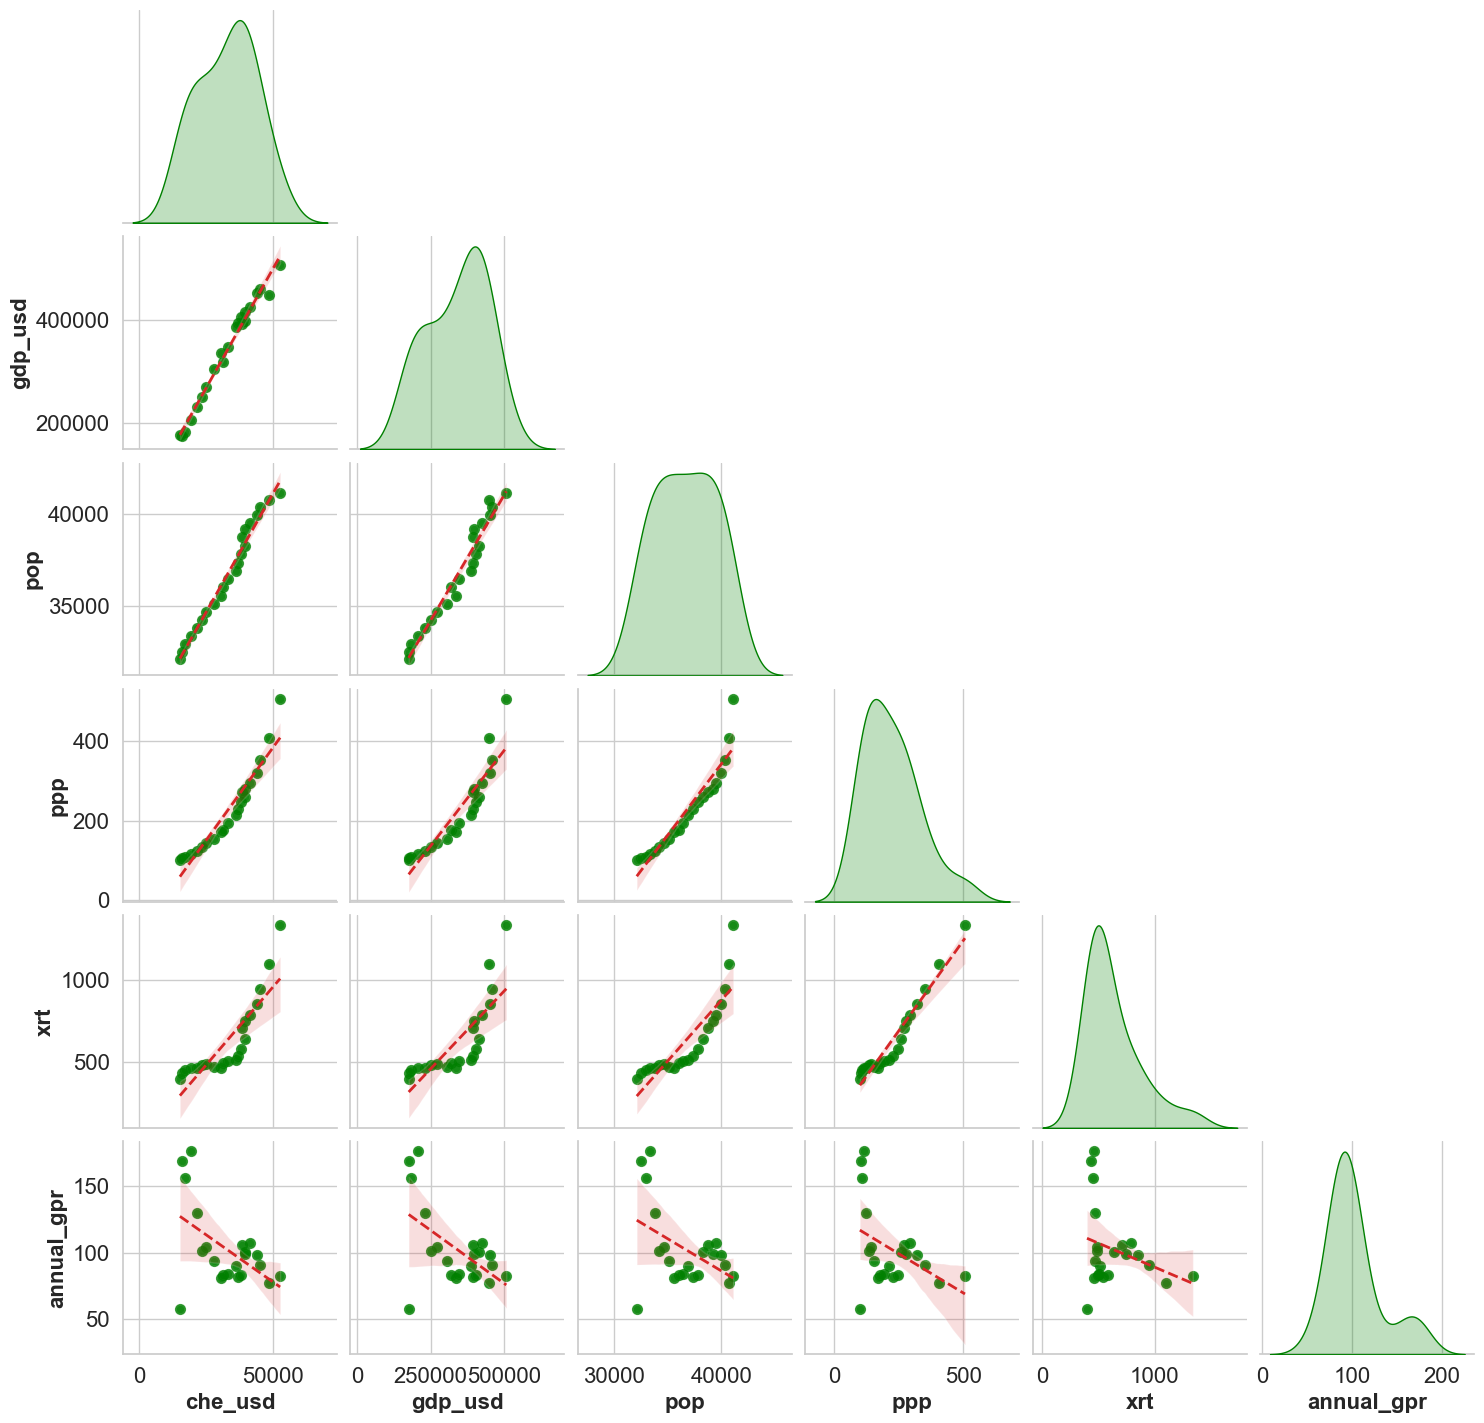

In [42]:
# Pair Plot

grouped_data = GHED_Final.groupby('year').agg({
    'che_usd': 'mean',         
    'pop': 'mean',             
    'gdp_usd': 'mean',         
    'ppp': 'mean',             
    'xrt': 'mean',             
    'annual_gpr': 'mean'
}).reset_index()

pairplot_data = grouped_data[['che_usd', 'gdp_usd', 'pop', 'ppp', 'xrt', 'annual_gpr']]

sns.set(
    style="whitegrid",  
    font_scale=1.2      
)

def scatter_with_trend(x, y, ax, **kwargs):
    sns.regplot(
        x=x, y=y,
        scatter_kws={'alpha': 0.7, 'color': 'green', 's': 50},  
        line_kws={'color': '#d62728', 'lw': 2, 'linestyle': '--'},  
        ax=ax,
        **kwargs
    )

pair_plot = sns.pairplot(
    pairplot_data,
    diag_kind='kde',               
    corner=True,                   
    plot_kws={'alpha': 0.7, 'color': 'green'},  
    diag_kws={'color': 'green', 'shade': True} 
)

for i, j in zip(*np.tril_indices_from(pair_plot.axes, -1)):
    if pair_plot.axes[i, j] is not None: 
        scatter_with_trend(
            pairplot_data.iloc[:, j],
            pairplot_data.iloc[:, i],
            ax=pair_plot.axes[i, j]
        )

for ax in pair_plot.axes.flat:
    if ax is not None:
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.set_xlabel(ax.get_xlabel(), fontsize=16, fontweight='bold')
        ax.set_ylabel(ax.get_ylabel(), fontsize=16, fontweight='bold')

pair_plot.fig.subplots_adjust(top=0.95) 
plt.show()



## Year Over Year Growth rate

In [43]:
GHED_Final_GR = GHED_Final.sort_values(by=['country', 'year']).reset_index(drop=True)

GHED_Final_GR['CHE_growth_rate'] = GHED_Final_GR.groupby('country')['che_usd'].pct_change() * 100

print(GHED_Final_GR.head())

  dataset      country code region income  year        ppp        xrt  \
0   train  Afghanistan  AFG    EMR    Low  2000   9.197497  47.263000   
1   train  Afghanistan  AFG    EMR    Low  2001   9.197497  47.263000   
2   train  Afghanistan  AFG    EMR    Low  2002   9.197497  47.263000   
3   train  Afghanistan  AFG    EMR    Low  2003  10.070732  48.762753   
4   train  Afghanistan  AFG    EMR    Low  2004  10.912901  47.845314   

          pop      che_usd  ...   hf11_usd    hf2_usd     hf3_usd  \
0  21000.2565  1184.709526  ...   3.183842  49.049183  304.930656   
1  21000.2565  1184.709526  ...   3.183842  49.049183  304.930656   
2  21000.2565   357.163675  ...   3.183842  49.049183  304.930656   
3  22645.1300   403.421272  ...  29.370861  26.828981  347.221419   
4  23553.5505   504.739950  ...  27.938728  50.156703  426.644530   

       gdp_usd  annual_gpr  income_color  CHE_to_GDP  CHE_per_capita  \
0  3782.155135   57.415285       #1f77b4   31.323663        0.056414   
1 

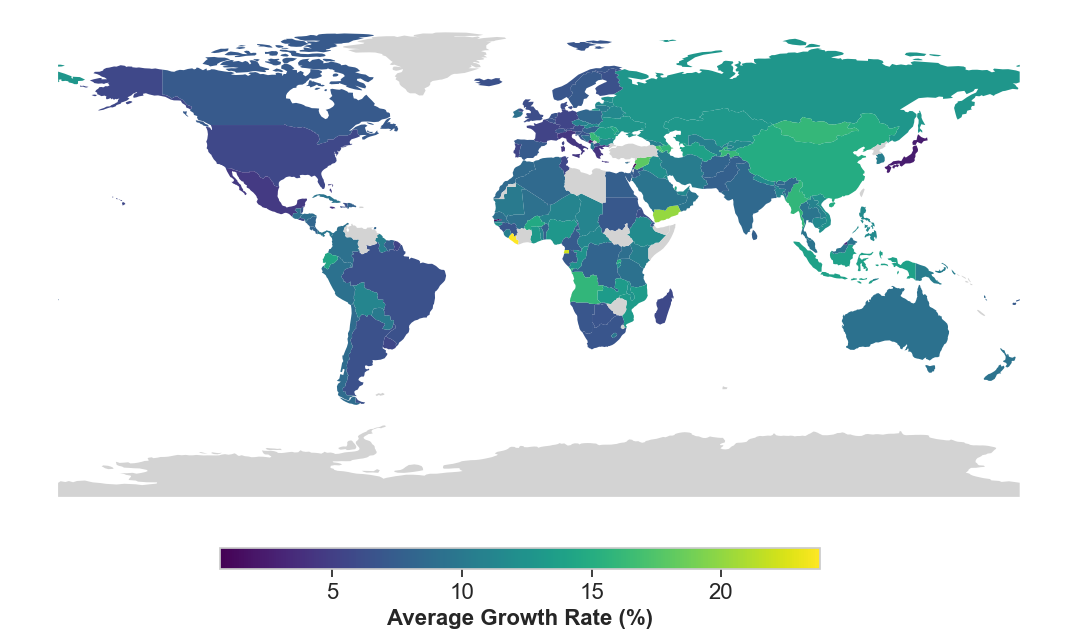

In [44]:
# Map - Growth Rate

world = gpd.read_file('ne_110m_admin_0_countries.shp')
GHED_Final_GR['country'] = GHED_Final_GR['country'].str.strip().str.lower()
world['NAME'] = world['NAME'].str.strip().str.lower()

country_mapping = {
    'cabo verde': 'cape verde',
    'central african republic': 'central african rep.',
    "côte d'ivoire": "ivory coast",
    'democratic republic of the congo': 'dem. rep. congo',
    'equatorial guinea': 'eq. guinea',
    'eswatini': 'swaziland',  # Alternate name
    'united republic of tanzania': 'tanzania',
    'bolivia (plurinational state of)': 'bolivia',
    'dominican republic': 'dominican rep.',
    'saint kitts and nevis': 'st. kitts and nevis',
    'saint lucia': 'st. lucia',
    'saint vincent and the grenadines': 'st. vincent and the grenadines',
    'iran (islamic republic of)': 'iran',
    "lao people's democratic republic": 'laos',
    'russian federation': 'russia',
    'netherlands (kingdom of the)': 'netherlands',
    'republic of korea': 'south korea',
    'syrian arab republic': 'syria',
    'venezuela (bolivarian republic of)': 'venezuela',
    'united kingdom of great britain and northern ireland': 'united kingdom',
    'brunei darussalam': 'brunei',
    'timor-leste': 'timor-leste',
    'republic of moldova': 'moldova',
    'bosnia and herzegovina': 'bosnia and herz.',
    'viet nam': 'vietnam',
}

GHED_Final_GR['country'] = GHED_Final_GR['country'].replace(country_mapping)

average_growth_rate = GHED_Final_GR.groupby('country')['CHE_growth_rate'].mean().reset_index()
average_growth_rate.columns = ['country', 'avg_growth_rate']

merged = world.merge(average_growth_rate, left_on='NAME', right_on='country', how='left')

fig, ax = plt.subplots(1, 1, figsize=(15, 7))

merged.plot(
    column='avg_growth_rate',
    cmap='viridis',  
    linewidth=0,     
    ax=ax,
    edgecolor=None,  
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": None,  
        "label": "No Data"
    },
    legend=False,
)

fig.subplots_adjust(bottom=0.15)  
cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.03])  
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=merged['avg_growth_rate'].min(), vmax=merged['avg_growth_rate'].max()))
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=16)  
cbar.set_label('Average Growth Rate (%)', fontsize=16, fontweight='bold')  
ax.set_axis_off()
plt.show()



In [45]:

average_growth_rate = GHED_Final_GR.groupby('country')['CHE_growth_rate'].mean().reset_index()
average_growth_rate.columns = ['Country', 'Average Growth Rate (%)']

print("Average Growth Rate of CHE by Country:")
print(average_growth_rate)


Average Growth Rate of CHE by Country:
         Country  Average Growth Rate (%)
0    afghanistan                 8.007019
1        albania                 9.734200
2        algeria                 8.618116
3        andorra                 6.394556
4         angola                15.887995
..           ...                      ...
183   uzbekistan                10.453784
184      vanuatu                 8.439877
185      vietnam                12.323003
186        yemen                20.174502
187       zambia                13.247785

[188 rows x 2 columns]


In [46]:
top_10_growth_rate = average_growth_rate.sort_values(by='Average Growth Rate (%)', ascending=False).head(20)

print("Top 10 Countries with Highest CHE Growth Rate:")
print(top_10_growth_rate)


Top 10 Countries with Highest CHE Growth Rate:
          Country  Average Growth Rate (%)
124          niue                32.579167
95        liberia                23.815893
53     eq. guinea                22.065294
186         yemen                20.174502
165         syria                17.945387
7         armenia                17.358633
146        serbia                16.295559
166    tajikistan                16.212156
111      mongolia                16.121123
10     azerbaijan                15.931280
115       myanmar                15.916396
4          angola                15.887995
35          china                14.874384
140        rwanda                14.781257
109       moldova                14.695499
26   burkina faso                14.659517
137         qatar                14.656445
50        ecuador                14.276724
174  turkmenistan                13.894914
76      indonesia                13.829671


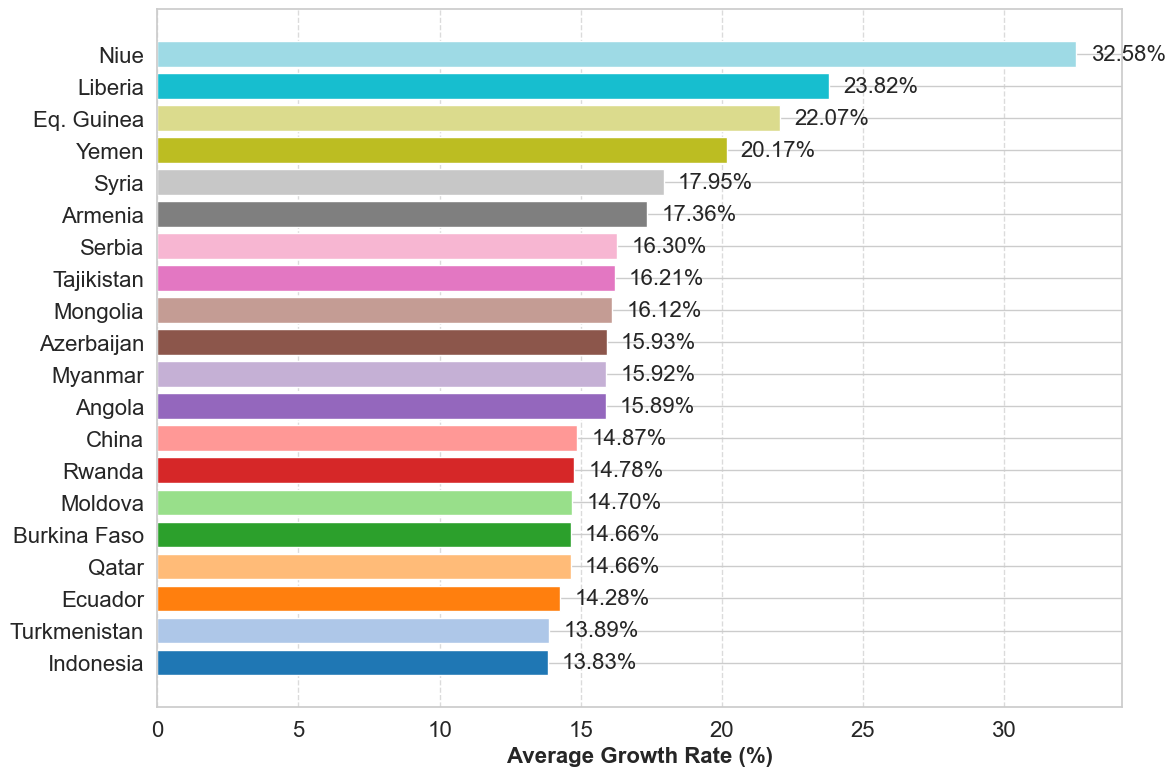

In [47]:
data = {
    "Country": [
        "niue", "liberia", "eq. guinea", "yemen", "syria", "armenia", 
        "serbia", "tajikistan", "mongolia", "azerbaijan", "myanmar",
        "angola", "china", "rwanda", "moldova", "burkina faso", 
        "qatar", "ecuador", "turkmenistan", "indonesia"
    ],
    "Average Growth Rate (%)": [
        32.579167, 23.815893, 22.065294, 20.174502, 17.945387, 
        17.358633, 16.295559, 16.212156, 16.121123, 15.931280, 
        15.916396, 15.887995, 14.874384, 14.781257, 14.695499, 
        14.659517, 14.656445, 14.276724, 13.894914, 13.829671
    ]
}

df = pd.DataFrame(data)
df["Country"] = df["Country"].str.title()
df = df.sort_values("Average Growth Rate (%)", ascending=True)
colors = plt.cm.tab20.colors[:len(df)]

plt.figure(figsize=(12, 8))
bars = plt.barh(df["Country"], df["Average Growth Rate (%)"], color=colors, edgecolor=None)

for bar, percentage in zip(bars, df["Average Growth Rate (%)"]):
    plt.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height() / 2,
        f"{percentage:.2f}%",
        va='center', fontsize=16
    )

plt.xlabel("Average Growth Rate (%)", fontsize=16, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Model preparation

## Baseline Dataset preparation

In [48]:
selected_columns = ['country', 'region', 'income', 'year', 'ppp', 'pop', 'xrt', 'gdp_usd', 'che_usd', 'annual_gpr']
GHED_train = ghed_train[selected_columns]
GHED_train.head()

country region        income  year        ppp         pop        xrt  \
0  Algeria    AFR  Lower-middle  2000  15.744428  30774.6210  75.259789   
1  Algeria    AFR  Lower-middle  2001  15.324636  31200.9855  77.215019   
2  Algeria    AFR  Lower-middle  2002  15.288708  31624.6955  79.681900   
3  Algeria    AFR  Lower-middle  2003  16.241821  32055.8835  77.394974   
4  Algeria    AFR  Lower-middle  2004  17.754457  32510.1860  72.060654   

        gdp_usd      che_usd  annual_gpr  
0  54790.215089  1911.648551   57.415285  
1  54744.530820  2101.027653  168.829173  
2  56760.694698  2117.197412  156.042167  
3  67863.580095  2443.795446  176.301563  
4  85332.281698  3024.238369  129.396236

In [49]:
GHED_test = ghed_test[selected_columns]
GHED_test.head()

country region        income  year        ppp         pop         xrt  \
0  Algeria    AFR  Lower-middle  2017  38.855751  41136.5460  110.973015   
1  Algeria    AFR  Lower-middle  2018  40.513496  41927.0070  116.593788   
2  Algeria    AFR  Lower-middle  2019  39.615276  42705.3685  119.353561   
3  Algeria    AFR  Lower-middle  2020  36.987289  43451.6660  126.776802   
4  Algeria    AFR  Lower-middle  2021  41.100029  44177.9685  135.064056   

         gdp_usd       che_usd  annual_gpr  
0  167389.342611  10935.674334  107.377312  
1  174910.690557  11172.066031   98.552907  
2  171760.270574  10078.058090   90.946253  
3  145743.540614   8952.569449   77.293804  
4  163472.803857   9037.337783   82.070236

## Feature selection

### VIF TEST

In [50]:
features = ['ppp', 'pop', 'xrt', 'gdp_usd', 'che_usd', 'annual_gpr']
vif_data = GHED_train[features].dropna()

def calculate_vif(data):
    vif = pd.DataFrame()
    vif['Variable'] = data.columns
    vif['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif

vif_data = add_constant(vif_data)
while True:
    vif = calculate_vif(vif_data)
    print(vif)
    max_vif = vif.loc[vif['Variable'] != 'const', 'VIF'].max()
    if max_vif > 5:
        feature_to_drop = vif.loc[vif['VIF'] == max_vif, 'Variable'].values[0]
        print(f"Dropping feature: {feature_to_drop}")
        vif_data = vif_data.drop(columns=[feature_to_drop])
    else:
        break

print("Final Selected Features:")
print(vif_data.columns)


     Variable        VIF
0       const  12.289032
1         ppp  14.492302
2         pop   1.801427
3         xrt  14.500997
4     gdp_usd  16.693333
5     che_usd  14.468574
6  annual_gpr   1.015919
Dropping feature: gdp_usd
     Variable        VIF
0       const  12.197354
1         ppp  14.433636
2         pop   1.067499
3         xrt  14.427371
4     che_usd   1.066229
5  annual_gpr   1.013842
Dropping feature: ppp
     Variable        VIF
0       const  11.989494
1         pop   1.066889
2         xrt   1.003995
3     che_usd   1.066142
4  annual_gpr   1.000705
Final Selected Features:
Index(['const', 'pop', 'xrt', 'che_usd', 'annual_gpr'], dtype='object')


### Correlation matrix

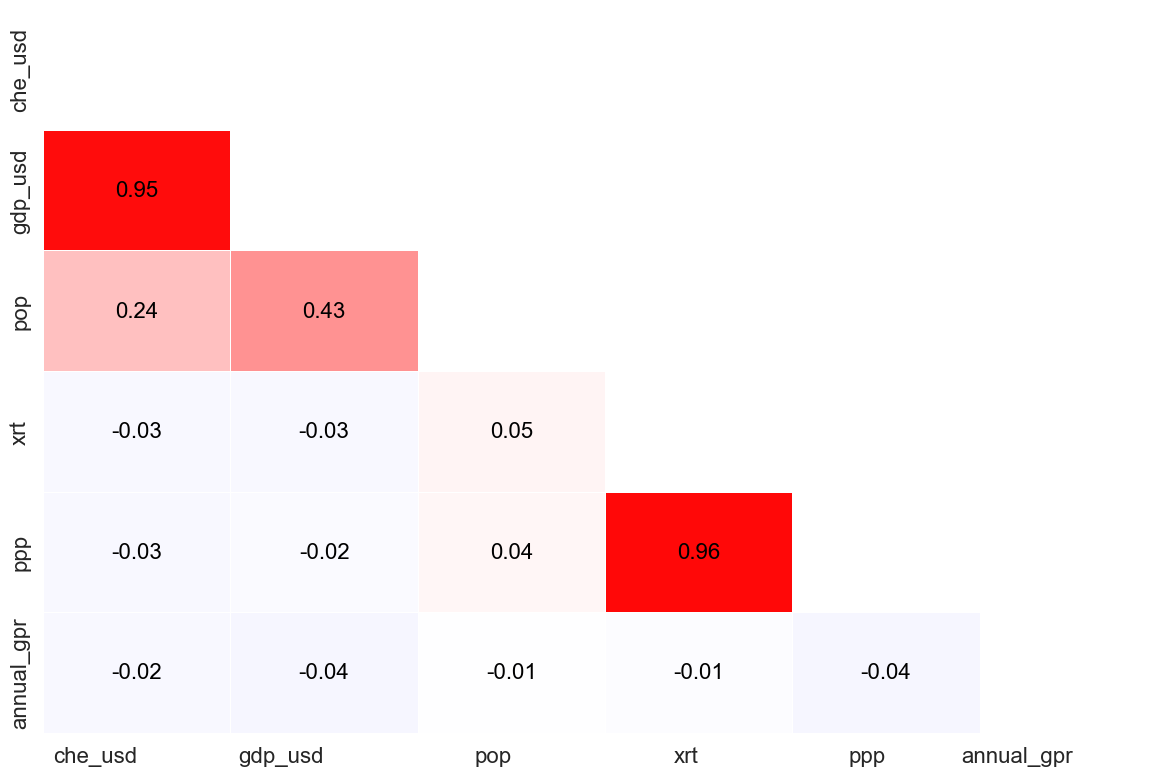

In [51]:
correlation_data = GHED_train[["che_usd", "gdp_usd", "pop", "xrt", "ppp", "annual_gpr"]].corr()
mask = np.triu(np.ones_like(correlation_data, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_data,
    mask=mask,
    cmap="bwr",
    annot=True,
    fmt=".2f",
    cbar=False,
    square=False,
    linewidths=0.5,
    annot_kws={"size": 16, "color": "black"},
    vmin=-1, vmax=1
)

plt.xticks(fontsize=16, ha='right')
plt.yticks(fontsize=16)
plt.grid(False)
plt.gca().set_frame_on(False)
plt.tight_layout()
plt.show()


## Time series decomposition

Decomposing and plotting for: che_usd


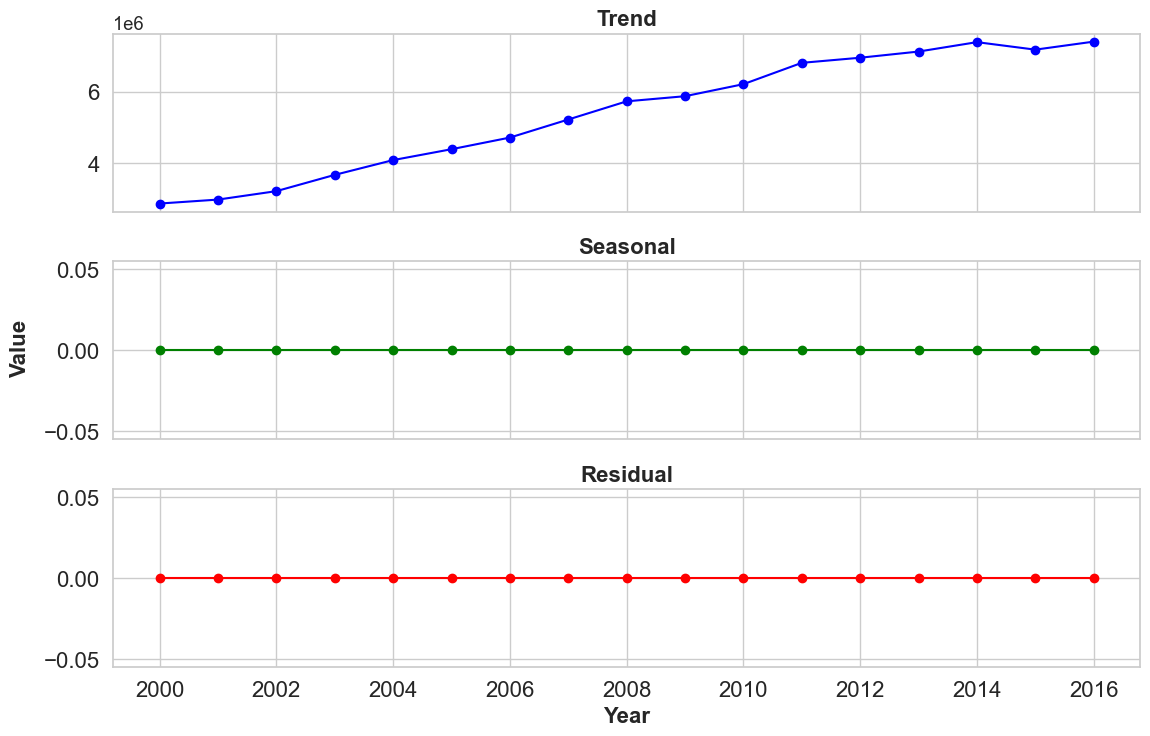

Decomposing and plotting for: pop


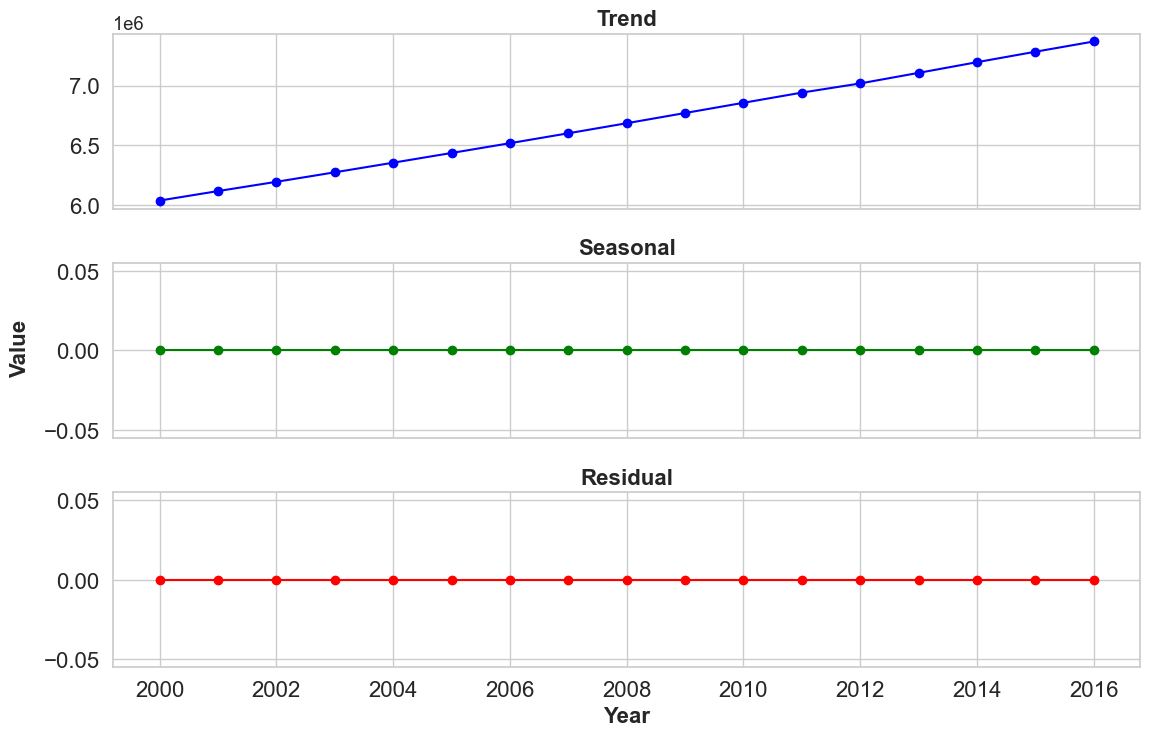

Decomposing and plotting for: annual_gpr


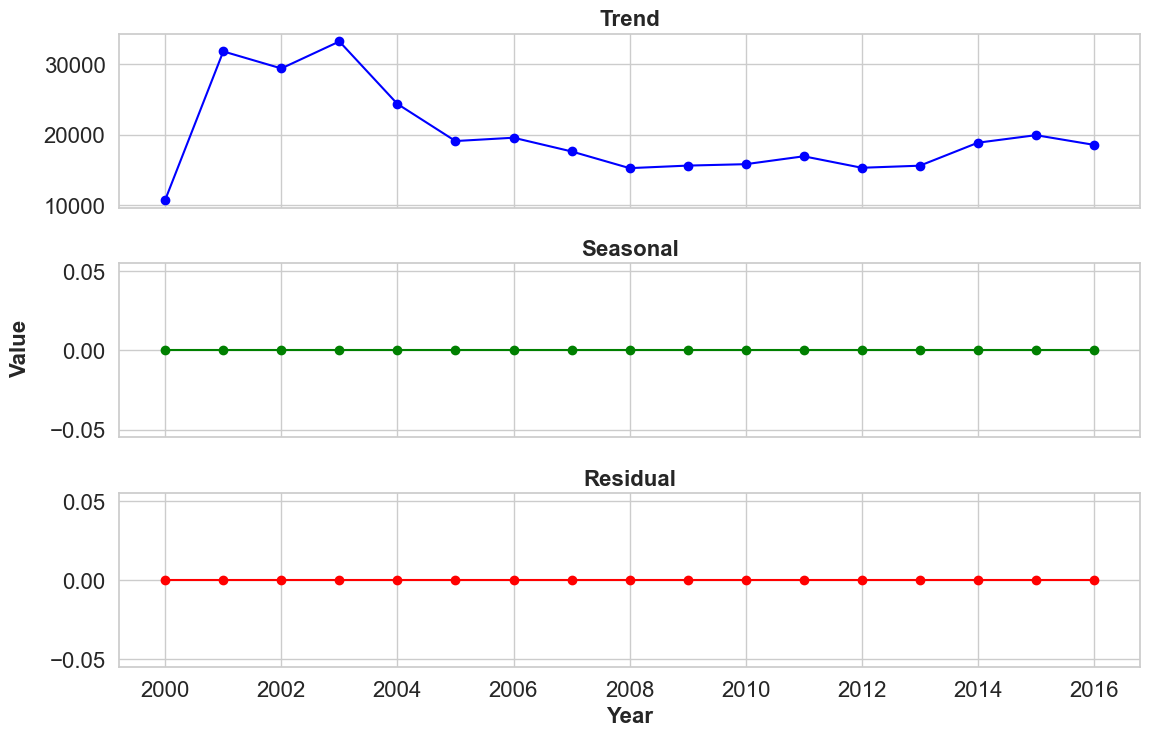

Decomposing and plotting for: xrt


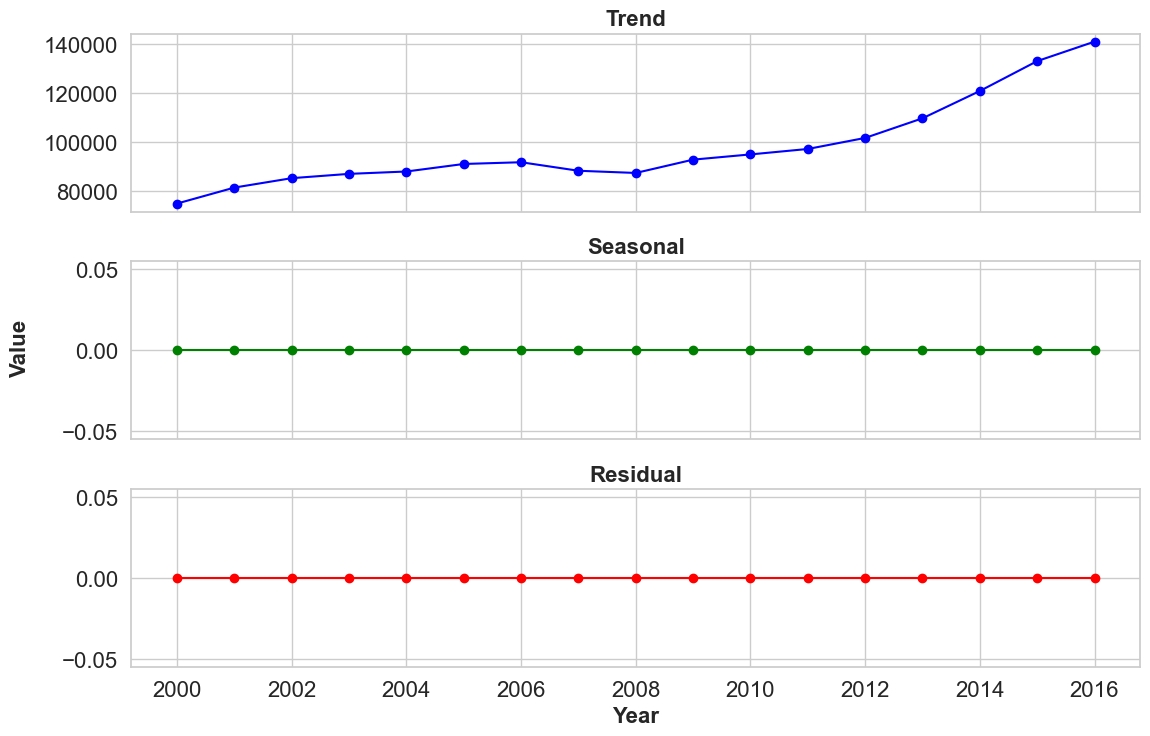

Decomposing and plotting for: ppp


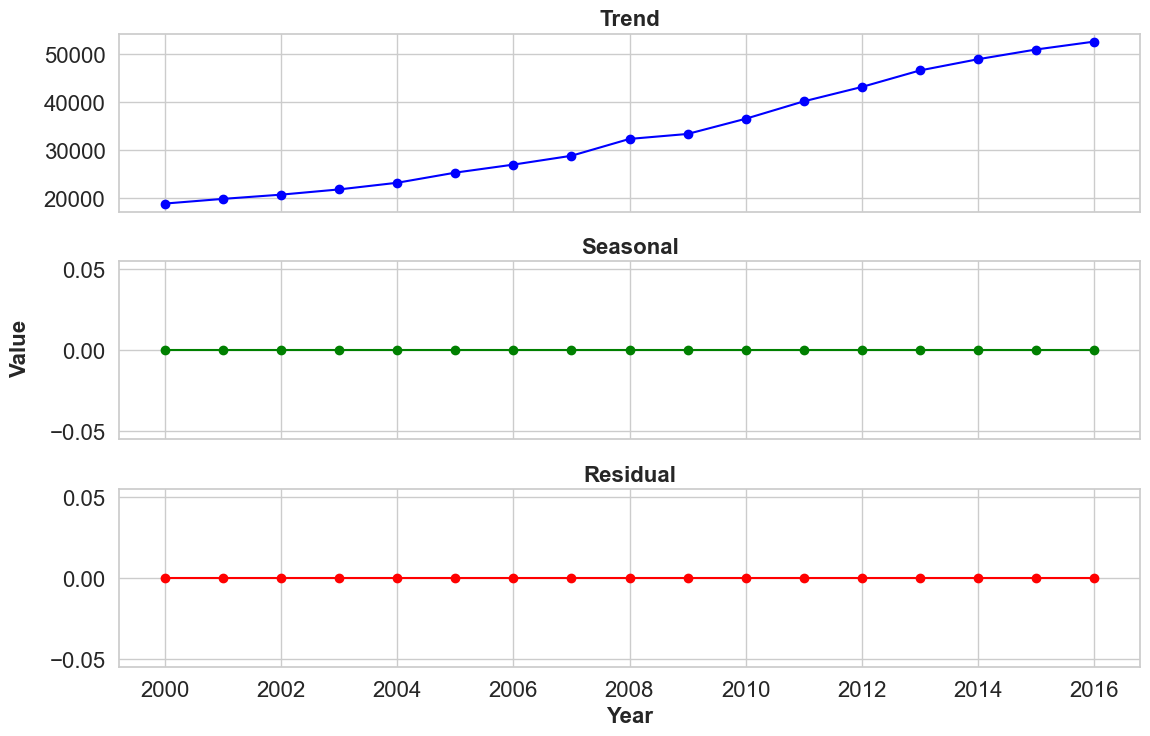

In [52]:
import statsmodels.api as sm

selected_columns = ['che_usd', 'pop', 'annual_gpr', 'xrt', 'ppp']
grouped_data_train = GHED_train.groupby('year')[selected_columns].sum()

colors = {"Trend": "blue", "Seasonal": "green", "Residual": "red"}

for variable in ['che_usd', 'pop', 'annual_gpr', 'xrt', 'ppp']:
    print(f"Decomposing and plotting for: {variable}")
    decomposition = sm.tsa.seasonal_decompose(grouped_data_train[variable], model='additive', period=1)
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    decomposition.trend.plot(ax=axes[0], fontsize=16, color=colors["Trend"], marker='o')
    axes[0].set_title("Trend", fontsize=16, fontweight='bold')
    axes[0].tick_params(axis='both', labelsize=16)
    decomposition.seasonal.plot(ax=axes[1], fontsize=16, color=colors["Seasonal"], marker='o')
    axes[1].set_title("Seasonal", fontsize=16, fontweight='bold')
    axes[1].tick_params(axis='both', labelsize=16)
    decomposition.resid.plot(ax=axes[2], fontsize=16, color=colors["Residual"], marker='o')
    axes[2].set_title("Residual", fontsize=16, fontweight='bold')
    axes[2].tick_params(axis='both', labelsize=16)
    axes[2].set_xlabel("Year", fontsize=16, fontweight='bold')
    fig.text(0.04, 0.5, 'Value', fontsize=16, fontweight='bold', va='center', rotation='vertical')
    plt.tight_layout(rect=[0.05, 0, 1, 0.95])
    plt.show()


### Autocorelation

Plotting ACF and PACF for che_usd


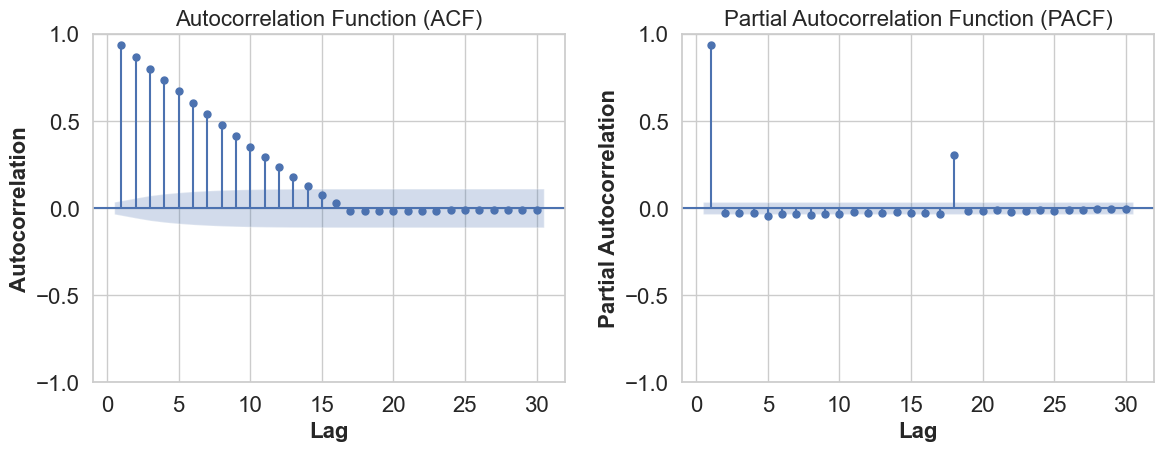

Plotting ACF and PACF for annual_gpr


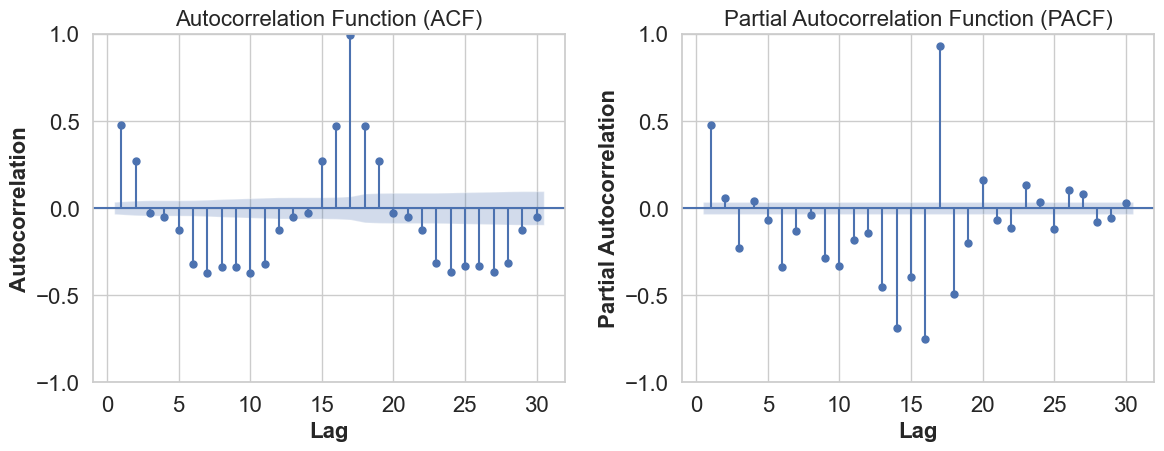

Plotting ACF and PACF for xrt


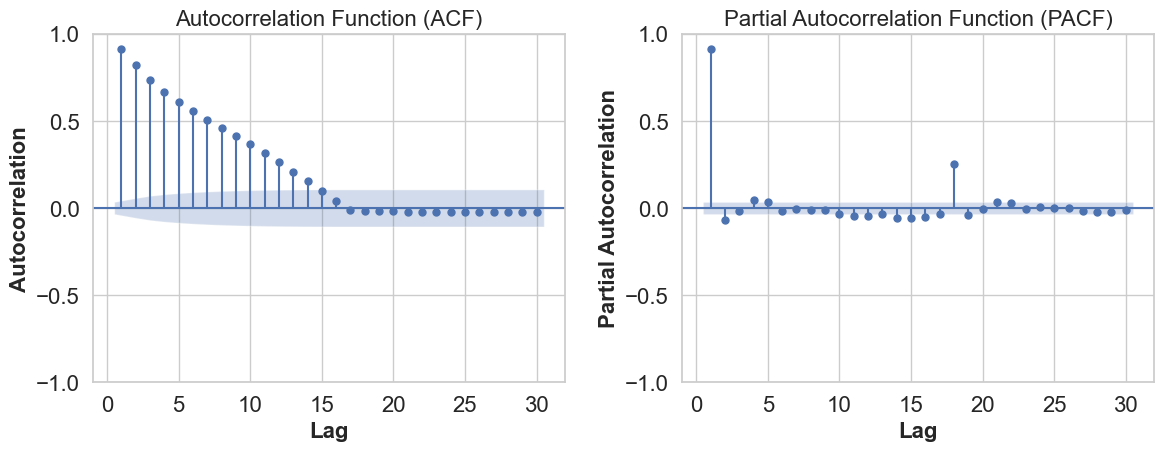

Plotting ACF and PACF for ppp


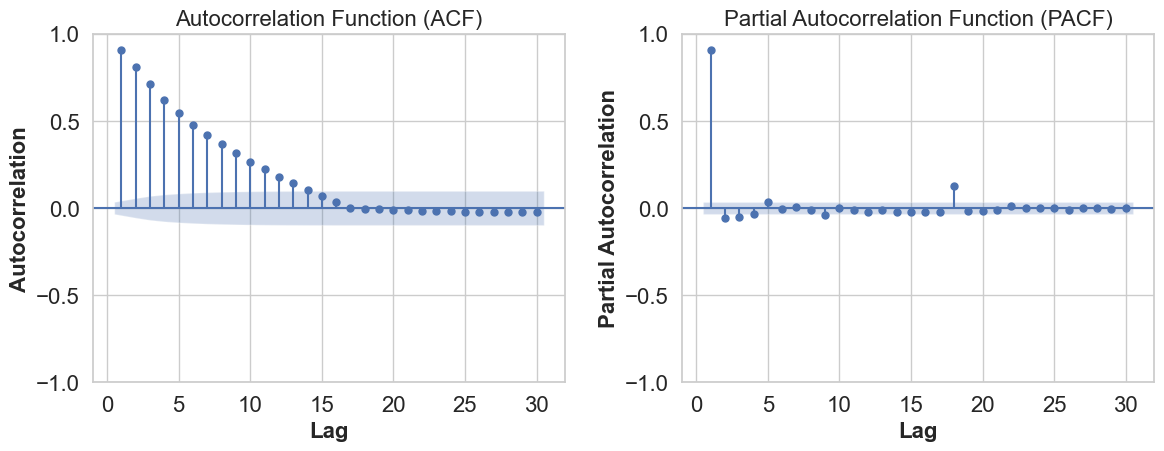

Plotting ACF and PACF for pop


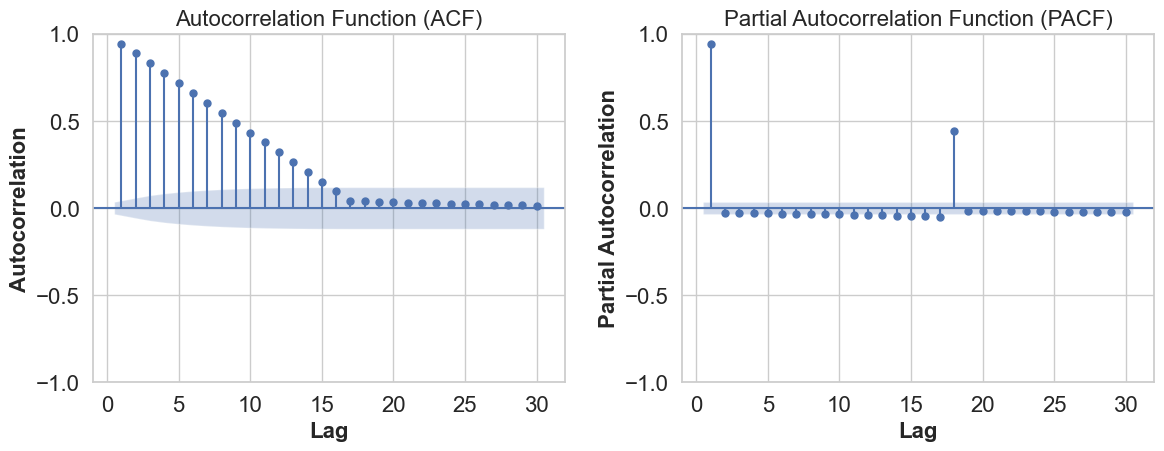

In [53]:
variables = ['che_usd', 'annual_gpr', 'xrt', 'ppp', 'pop']

for variable in variables:
    print(f"Plotting ACF and PACF for {variable}")
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    plot_acf(GHED_train[variable], ax=axes[0], lags=30, title="Autocorrelation Function (ACF)", zero=False)
    axes[0].set_xlabel("Lag", fontsize=16, fontweight='bold')
    axes[0].set_ylabel("Autocorrelation", fontsize=16, fontweight='bold')
    axes[0].tick_params(axis='both', labelsize=16)
    axes[0].title.set_fontsize(16)
    plot_pacf(GHED_train[variable], ax=axes[1], lags=30, title="Partial Autocorrelation Function (PACF)", zero=False, method='ywm')
    axes[1].set_xlabel("Lag", fontsize=16, fontweight='bold')
    axes[1].set_ylabel("Partial Autocorrelation", fontsize=16, fontweight='bold')
    axes[1].tick_params(axis='both', labelsize=16)
    axes[1].title.set_fontsize(16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Univariate Forecsting

## ARIMA

### Preparation of Dataset

Missing years in training data: {Timestamp('2004-12-31 00:00:00'), Timestamp('2002-12-31 00:00:00'), Timestamp('2014-12-31 00:00:00'), Timestamp('2006-12-31 00:00:00'), Timestamp('2010-12-31 00:00:00'), Timestamp('2011-12-31 00:00:00'), Timestamp('2009-12-31 00:00:00'), Timestamp('2001-12-31 00:00:00'), Timestamp('2013-12-31 00:00:00'), Timestamp('2008-12-31 00:00:00'), Timestamp('2003-12-31 00:00:00'), Timestamp('2000-12-31 00:00:00'), Timestamp('2007-12-31 00:00:00'), Timestamp('2012-12-31 00:00:00'), Timestamp('2015-12-31 00:00:00'), Timestamp('2005-12-31 00:00:00')}


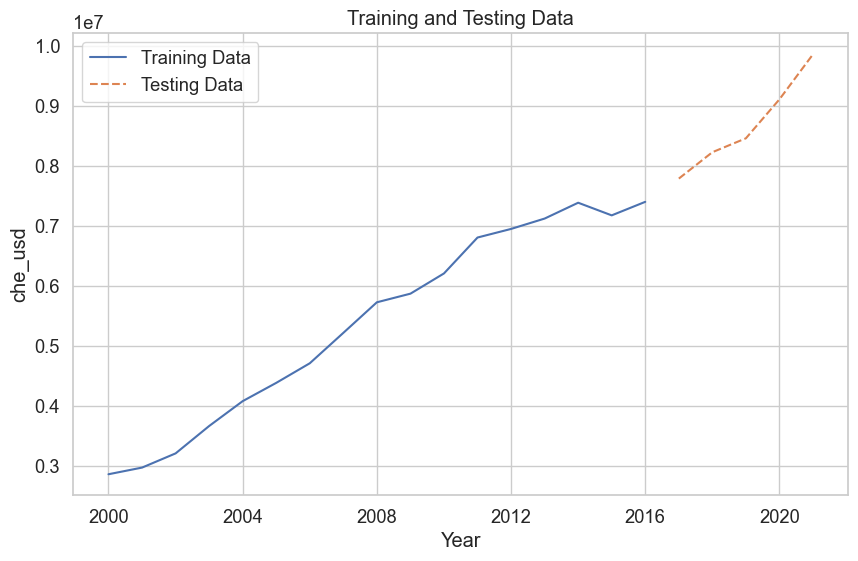

In [54]:
arima_data_test = GHED_test.groupby('year')['che_usd'].sum().reset_index()
arima_data_train = GHED_train.groupby('year')['che_usd'].sum().reset_index()

arima_data_test['year'] = pd.to_datetime(arima_data_test['year'], format='%Y')
arima_data_train['year'] = pd.to_datetime(arima_data_train['year'], format='%Y')
arima_data_test.set_index('year', inplace=True)
arima_data_train.set_index('year', inplace=True)

print("Missing years in training data:", set(pd.date_range(start=arima_data_train.index.min(), 
                                                          end=arima_data_train.index.max(), freq='Y')) - set(arima_data_train.index))

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(arima_data_train.index, arima_data_train['che_usd'], label='Training Data')
plt.plot(arima_data_test.index, arima_data_test['che_usd'], label='Testing Data', linestyle='--')
plt.legend()
plt.title('Training and Testing Data')
plt.xlabel('Year')
plt.ylabel('che_usd')
plt.show()


#### Stationary

In [55]:
result = adfuller(arima_data_train['che_usd'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
if result[1] > 0.05:
    print("Data is not stationary. Differencing is required.")
else:
    print("Data is stationary.")


ADF Statistic: -0.5886827560188346
p-value: 0.8735188092903137
Data is not stationary. Differencing is required.


#### Differencing 

In [56]:
# First Differencing
arima_data_train['che_usd_diff'] = arima_data_train['che_usd'].diff()
arima_data_train.dropna(inplace=True)

result_diff = adfuller(arima_data_train['che_usd_diff'])
print(f"ADF Statistic: {result_diff[0]}")
print(f"p-value: {result_diff[1]}")
if result_diff[1] > 0.05:
    print("Data is still not stationary. Further differencing may be needed.")
else:
    print("Data is now stationary.")


ADF Statistic: 2.075634534186091
p-value: 0.998763521094781
Data is still not stationary. Further differencing may be needed.


In [57]:
# Second Differencing
arima_data_train['che_usd_diff2'] = arima_data_train['che_usd_diff'].diff()

arima_data_train.dropna(inplace=True)

result = adfuller(arima_data_train['che_usd_diff2'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] > 0.05:
    print("Data is still not stationary.")
else:
    print("Data is now stationary.")


ADF Statistic: 0.7168240780769207
p-value: 0.9901677113212669
Data is still not stationary.


In [58]:
# Third Differencing
arima_data_train['che_usd_diff3'] = arima_data_train['che_usd_diff2'].diff()
arima_data_train.dropna(inplace=True)

result = adfuller(arima_data_train['che_usd_diff3'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] > 0.05:
    print("Data is still not stationary.")
else:
    print("Data is now stationary.")


ADF Statistic: -11.793513261661397
p-value: 9.700188342947295e-22
Data is now stationary.


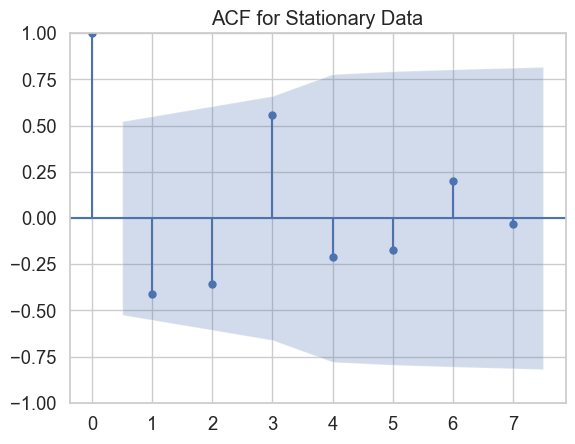

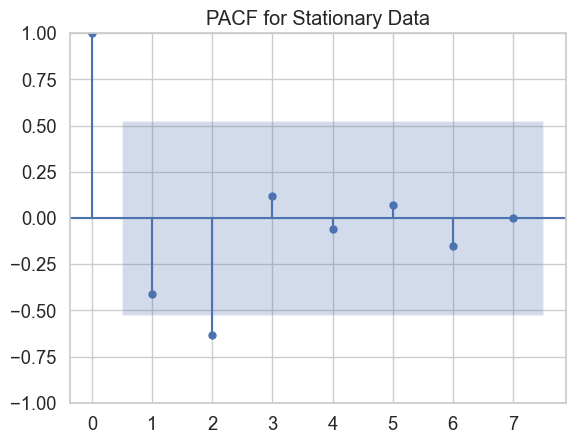

In [59]:
# ACF & PACF of Diffrenciated Data
plot_acf(arima_data_train['che_usd_diff3'].dropna())
plt.title('ACF for Stationary Data')
plt.show()

plot_pacf(arima_data_train['che_usd_diff3'].dropna())
plt.title('PACF for Stationary Data')
plt.show()


## Model fitting

### ARIMA 1 3 3

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                che_usd   No. Observations:                   14
Model:                 ARIMA(1, 3, 3)   Log Likelihood                -155.554
Date:                Sat, 04 Jan 2025   AIC                            321.107
Time:                        23:57:01   BIC                            323.097
Sample:                    01-01-2003   HQIC                           319.853
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6758      2.019     -0.335      0.738      -4.634       3.282
ma.L1         -0.7416      1.375     -0.539      0.590      -3.437       1.954
ma.L2         -0.0992      2.681     -0.037      0.9

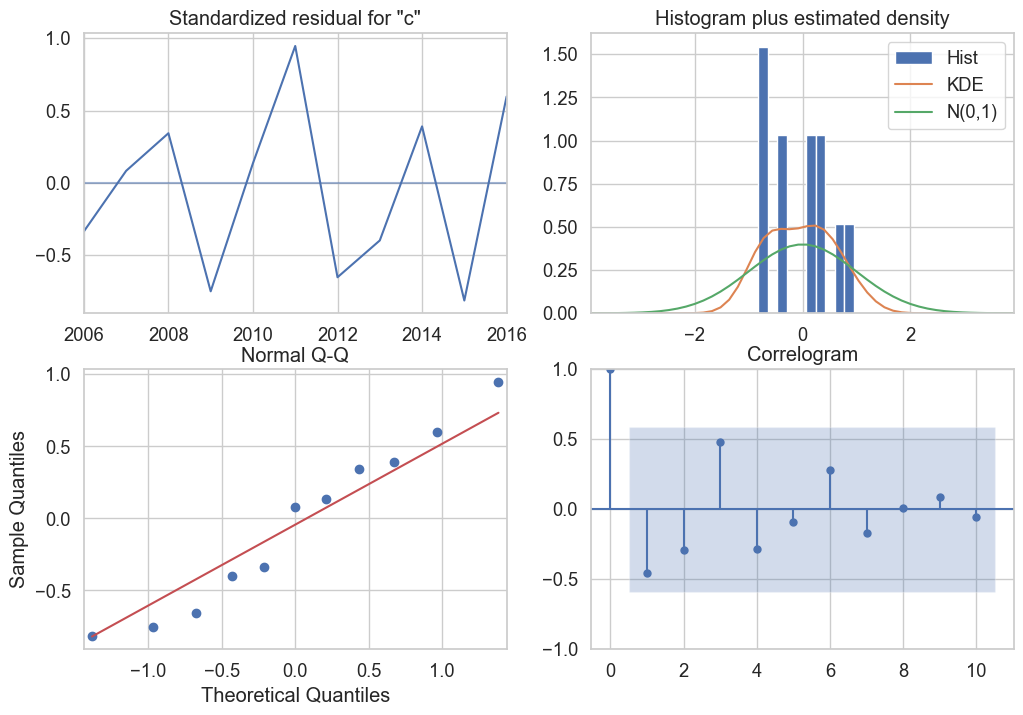

In [60]:
model = ARIMA(arima_data_train['che_usd'], order=(1, 3, 3))
model_fit_133 = model.fit()

print(model_fit_133.summary())

forecast_steps = len(arima_data_test)
forecast = model_fit_133.forecast(steps=forecast_steps)
forecast = forecast.values  

actual = arima_data_test['che_usd'].values

mae = mean_absolute_error(actual, forecast)
rmse = np.sqrt(mean_squared_error(actual, forecast))
mape = np.mean(np.abs((actual - forecast) / actual)) * 100
r2 = r2_score(actual, forecast)
accuracy = 100 - mape

print("\nARIMA Model Evaluation Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

model_fit_133.plot_diagnostics(figsize=(12, 8))
plt.show()

#### ARIMA 1 3 1

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                che_usd   No. Observations:                   14
Model:                 ARIMA(1, 3, 1)   Log Likelihood                -155.064
Date:                Sat, 04 Jan 2025   AIC                            316.127
Time:                        23:57:02   BIC                            317.321
Sample:                    01-01-2003   HQIC                           315.375
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5758      0.830     -0.694      0.488      -2.202       1.050
ma.L1         -0.7993      0.423     -1.889      0.059      -1.629       0.030
sigma2      1.817e+11   2.28e-13   7.98e+23      0.0

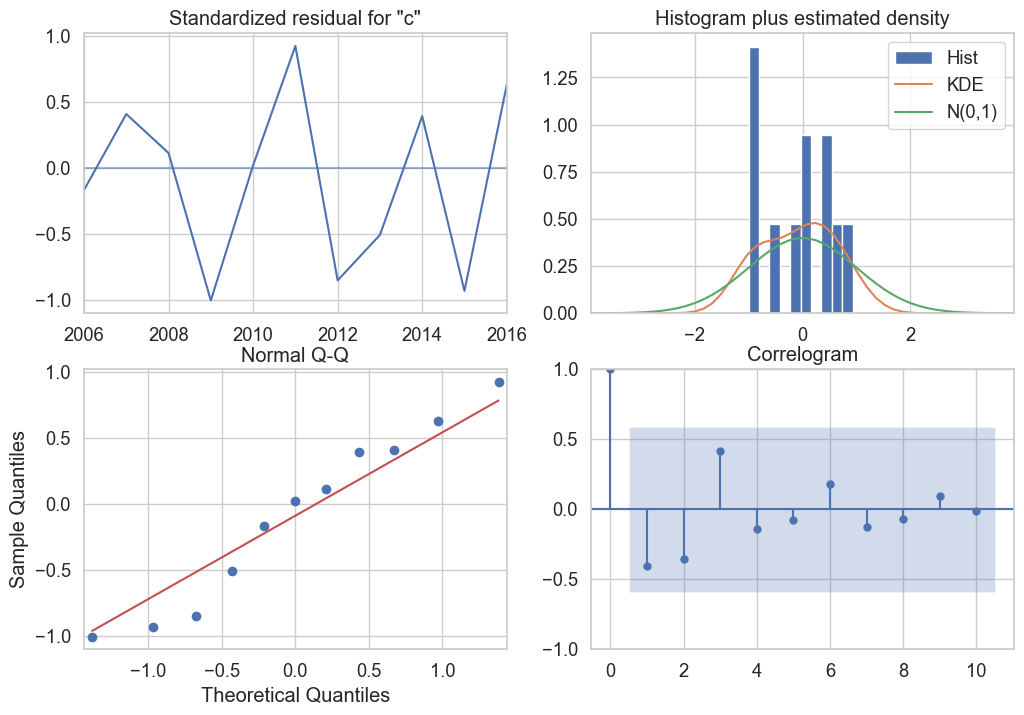

In [61]:
model = ARIMA(arima_data_train['che_usd'], order=(1, 3, 1))
model_fit_131 = model.fit()

print(model_fit_131.summary())

forecast_steps = len(arima_data_test)
forecast = model_fit_131.forecast(steps=forecast_steps)
forecast = forecast.values  

actual = arima_data_test['che_usd'].values

mae = mean_absolute_error(actual, forecast)
rmse = np.sqrt(mean_squared_error(actual, forecast))
mape = np.mean(np.abs((actual - forecast) / actual)) * 100
r2 = r2_score(actual, forecast)
accuracy = 100 - mape

print("\nARIMA Model Evaluation Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

model_fit_131.plot_diagnostics(figsize=(12, 8))
plt.show()


### ARIMA 2 3 1

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                che_usd   No. Observations:                   14
Model:                 ARIMA(2, 3, 1)   Log Likelihood                -154.272
Date:                Sat, 04 Jan 2025   AIC                            316.545
Time:                        23:57:02   BIC                            318.136
Sample:                    01-01-2003   HQIC                           315.541
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5547      0.203     -2.728      0.006      -0.953      -0.156
ar.L2         -0.0164      0.068     -0.239      0.811      -0.150       0.118
ma.L1         -0.8288      0.104     -7.965      0.0

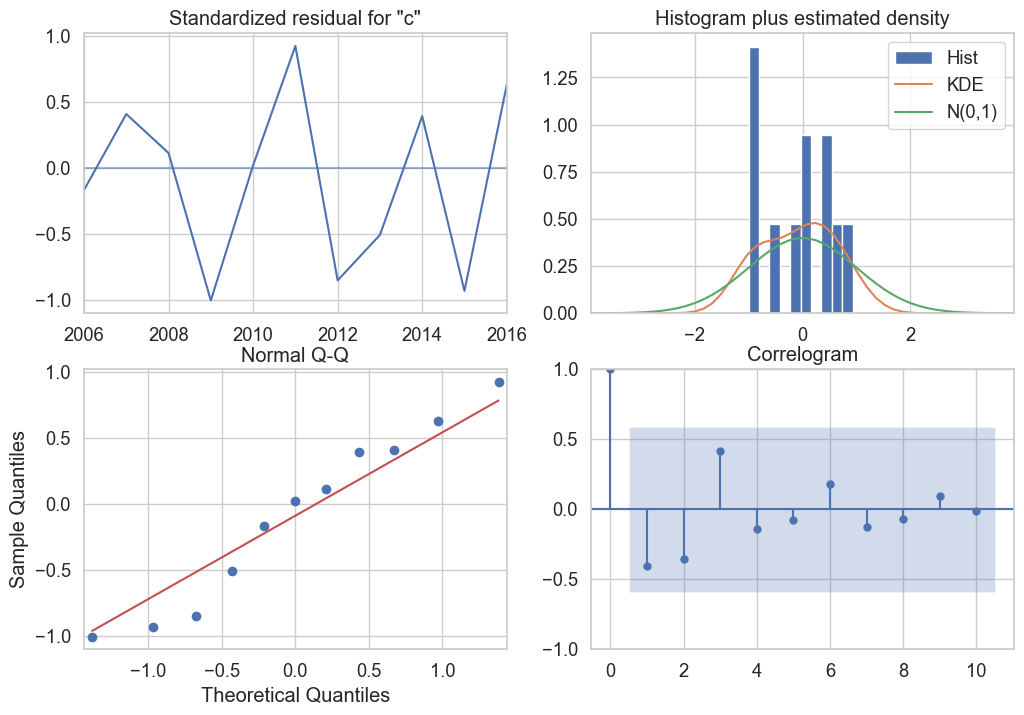

In [62]:
model = ARIMA(arima_data_train['che_usd'], order=(2, 3, 1))
model_fit_231 = model.fit()

print(model_fit_231.summary())

forecast_steps = len(arima_data_test)
forecast = model_fit_231.forecast(steps=forecast_steps)
forecast = forecast.values  

actual = arima_data_test['che_usd'].values

mae = mean_absolute_error(actual, forecast)
rmse = np.sqrt(mean_squared_error(actual, forecast))
mape = np.mean(np.abs((actual - forecast) / actual)) * 100
r2 = r2_score(actual, forecast)
accuracy = 100 - mape

print("\nARIMA Model Evaluation Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

model_fit_131.plot_diagnostics(figsize=(12, 8))
plt.show()

In [63]:
arima_131_metrics = {
    "Model": "ARIMA(1, 3, 1)",
    "AIC": 316.127,
    "BIC": 317.321,
    "Log Likelihood": -155.064,
    "AR Coefficient L1 (p)": -0.5758,
    "AR Coefficient L2 (p)": None,
    "MA Coefficient (q)": -0.7993,
    "Residual Variance (sigma^2)": 1.817e+11,
    "Ljung-Box p-value": 0.13,
    "Jarque-Bera p-value": 0.68,
    "Heteroskedasticity p-value": 0.76
}

arima_133_metrics = {
    "Model": "ARIMA(1, 3, 3)",
    "AIC": 321.107,
    "BIC": 323.097,
    "Log Likelihood": -155.554,
    "AR Coefficient L1 (p)": -0.6758,
    "AR Coefficient L2 (p)": None,
    "MA Coefficient (q)": "[-0.7416, -0.0992, 0.0844]",
    "Residual Variance (sigma^2)": 2.184e+11,
    "Ljung-Box p-value": 0.08,
    "Jarque-Bera p-value": 0.71,
    "Heteroskedasticity p-value": 0.64
}

arima_231_metrics = {
    "Model": "ARIMA(2, 3, 1)",
    "AIC": 316.545,
    "BIC": 318.136,
    "Log Likelihood": -154.272,
    "AR Coefficient L1 (p)": -0.5547,
    "AR Coefficient L2 (p)": -0.0164,
    "MA Coefficient (q)": -0.8288,
    "Residual Variance (sigma^2)": 4.269e+10,
    "Ljung-Box p-value": 0.988188,
    "Jarque-Bera p-value": 0.67,
    "Heteroskedasticity p-value": 0.82
}

models_summary = pd.DataFrame([arima_131_metrics, arima_133_metrics, arima_231_metrics])
print(models_summary)


            Model      AIC      BIC  Log Likelihood  AR Coefficient L1 (p)  \
0  ARIMA(1, 3, 1)  316.127  317.321        -155.064                -0.5758   
1  ARIMA(1, 3, 3)  321.107  323.097        -155.554                -0.6758   
2  ARIMA(2, 3, 1)  316.545  318.136        -154.272                -0.5547   

   AR Coefficient L2 (p)          MA Coefficient (q)  \
0                    NaN                     -0.7993   
1                    NaN  [-0.7416, -0.0992, 0.0844]   
2                -0.0164                     -0.8288   

   Residual Variance (sigma^2)  Ljung-Box p-value  Jarque-Bera p-value  \
0                 1.817000e+11           0.130000                 0.68   
1                 2.184000e+11           0.080000                 0.71   
2                 4.269000e+10           0.988188                 0.67   

   Heteroskedasticity p-value  
0                        0.76  
1                        0.64  
2                        0.82  


## ARIMA 2 3 1 Forecasting - Best Model

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


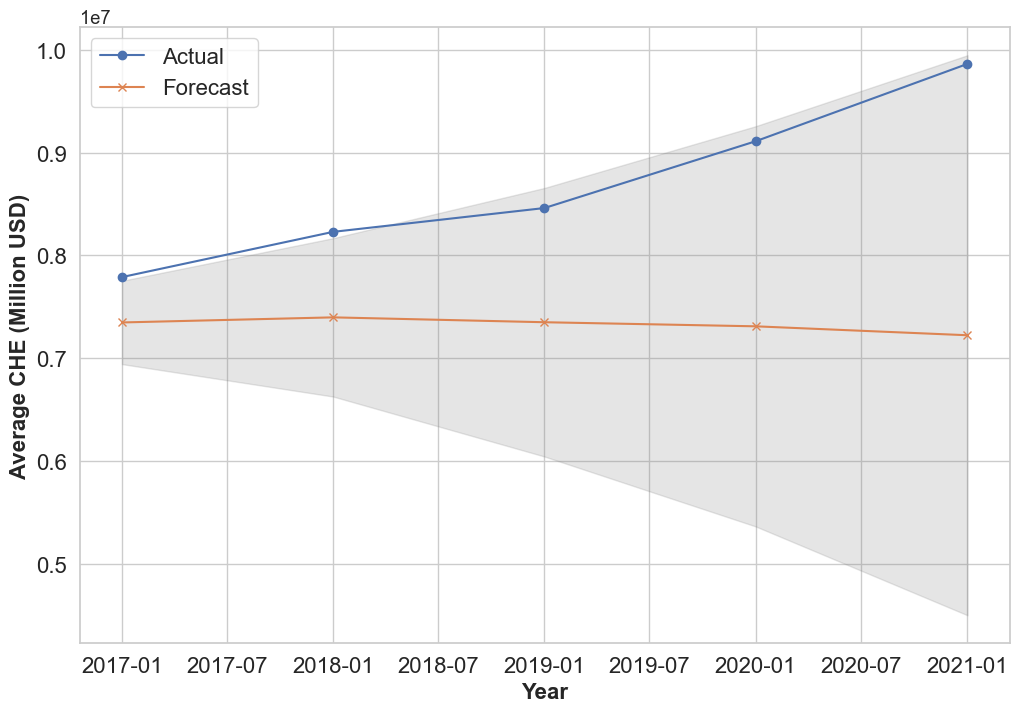

In [64]:
# Fit ARIMA(2, 3, 1)
model_231 = ARIMA(arima_data_train['che_usd'], order=(2, 3, 1))
model_fit_231 = model_231.fit()

forecast_result = model_fit_231.get_forecast(steps=len(arima_data_test))
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

plt.figure(figsize=(12, 8))
plt.plot(arima_data_test.index, arima_data_test['che_usd'], label='Actual', marker='o')
plt.plot(arima_data_test.index, forecast, label='Forecast', marker='x')
plt.fill_between(arima_data_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2)
plt.xlabel('Year', fontsize=16, fontweight='bold')
plt.ylabel('Average CHE (Million USD)', fontsize=16, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()


# Multivatiare Analysis

## Combining Variables Using Weighted Sum - Duplicate Delete

In [65]:
features = ['pop', 'xrt', 'annual_gpr']

train_features = GHED_train[features]
test_features = GHED_test[features]

scaler = MinMaxScaler()
train_features_scaled = pd.DataFrame(scaler.fit_transform(train_features), columns=features, index=GHED_train.index)
test_features_scaled = pd.DataFrame(scaler.transform(test_features), columns=features, index=GHED_test.index)

weights = {'pop': 0.8276, 'xrt': 0.1034, 'annual_gpr': 0.0690}

train_features_scaled['combined_variable'] = (
    train_features_scaled['pop'] * weights['pop'] +
    train_features_scaled['xrt'] * weights['xrt'] +
    train_features_scaled['annual_gpr'] * weights['annual_gpr']
)

test_features_scaled['combined_variable'] = (
    test_features_scaled['pop'] * weights['pop'] +
    test_features_scaled['xrt'] * weights['xrt'] +
    test_features_scaled['annual_gpr'] * weights['annual_gpr']
)

GHED_train['combined_variable'] = train_features_scaled['combined_variable']
GHED_test['combined_variable'] = test_features_scaled['combined_variable']

print("Train Data with Combined Variable:")
print(GHED_train[['year', 'combined_variable']].head())

print("\nTest Data with Combined Variable:")
print(GHED_test[['year', 'combined_variable']].head())


Train Data with Combined Variable:
   year  combined_variable
0  2000           0.018418
1  2001           0.083340
2  2002           0.076177
3  2003           0.088182
4  2004           0.061209

Test Data with Combined Variable:
   year  combined_variable
0  2017           0.053652
1  2018           0.049016
2  2019           0.045070
3  2020           0.037612
4  2021           0.040840


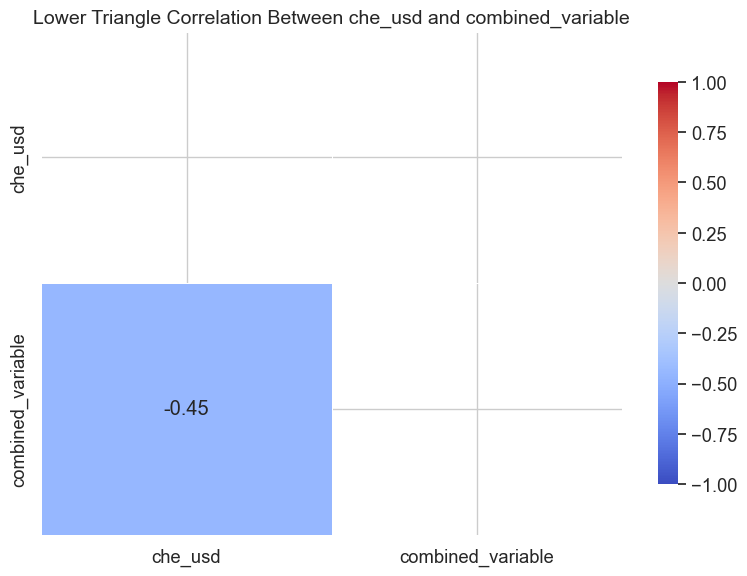

In [66]:
data = GHED_train.groupby('year')[['che_usd', 'combined_variable']].mean()
corr_matrix = data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
plt.title('Lower Triangle Correlation Between che_usd and combined_variable', fontsize=14)
plt.tight_layout()
plt.show()


# VAR

Train Data for VAR:
           che_usd  combined_variable
year                                 
2000  15197.137189           0.020291
2001  15789.185563           0.085320
2002  17048.965383           0.078210
2003  19477.907879           0.090249
2004  21684.183049           0.063296

Test Data for VAR:
           che_usd  combined_variable
year                                 
2017  41435.553770           0.054954
2018  43776.899455           0.050319
2019  45008.965337           0.046455
2020  48466.182220           0.039287
2021  52469.783924           0.043058

Using Forced Minimal Lag Order: 1

VAR Model Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 04, Jan, 2025
Time:                     23:57:03
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    5.41753
Nobs:                     15.0000    HQIC:                  

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


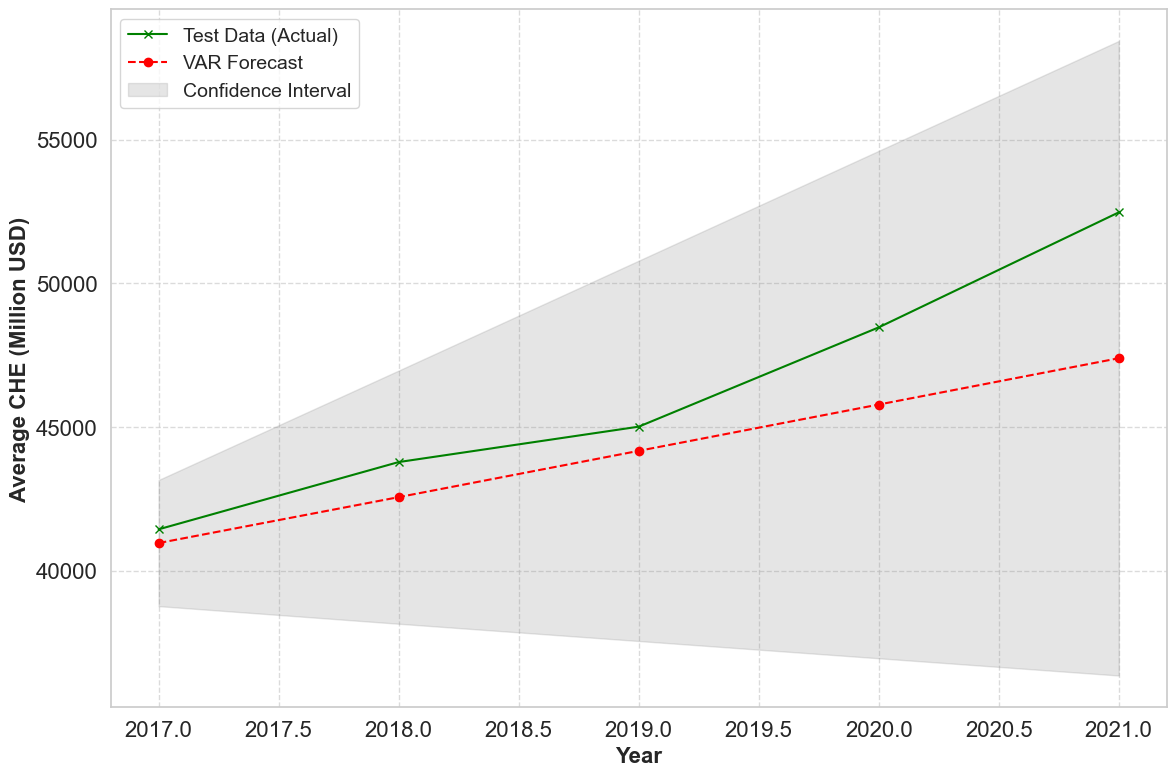

In [67]:
train_var = GHED_train.groupby('year')[['che_usd', 'combined_variable']].mean()
test_var = GHED_test.groupby('year')[['che_usd', 'combined_variable']].mean()

print("Train Data for VAR:")
print(train_var.head())

print("\nTest Data for VAR:")
print(test_var.head())

train_var_diff = train_var.diff().dropna()
model = VAR(train_var_diff)

optimal_lag = 1
print(f"\nUsing Forced Minimal Lag Order: {optimal_lag}")
var_model = model.fit(optimal_lag)

print("\nVAR Model Summary:")
print(var_model.summary())

forecast_input = train_var_diff.values[-optimal_lag:]
forecast_diff = var_model.forecast(y=forecast_input, steps=len(test_var))

forecast_values = pd.DataFrame(forecast_diff, index=test_var.index, columns=train_var.columns)
forecast_values['che_usd'] = forecast_values['che_usd'].cumsum() + train_var['che_usd'].iloc[-1]
forecast_values['combined_variable'] = (
    forecast_values['combined_variable'].cumsum() + train_var['combined_variable'].iloc[-1]
)

comparison_var = pd.DataFrame({
    'Actual': test_var['che_usd'],
    'VAR Forecast': forecast_values['che_usd']
}, index=test_var.index)

print("\nVAR Forecast Comparison:")
print(comparison_var)

mae = mean_absolute_error(test_var['che_usd'], forecast_values['che_usd'])
rmse = np.sqrt(mean_squared_error(test_var['che_usd'], forecast_values['che_usd']))
r2 = r2_score(test_var['che_usd'], forecast_values['che_usd'])
mape = np.mean(np.abs((test_var['che_usd'] - forecast_values['che_usd']) / test_var['che_usd'])) * 100

print("\nVAR Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

forecast, lower, upper = var_model.forecast_interval(forecast_input, steps=len(test_var), alpha=0.05)
forecast_values = pd.DataFrame(forecast, index=test_var.index, columns=train_var.columns)
forecast_values['che_usd'] = forecast_values['che_usd'].cumsum() + train_var['che_usd'].iloc[-1]
forecast_lower = pd.DataFrame(lower, index=test_var.index, columns=train_var.columns)
forecast_upper = pd.DataFrame(upper, index=test_var.index, columns=train_var.columns)
forecast_lower['che_usd'] = forecast_lower['che_usd'].cumsum() + train_var['che_usd'].iloc[-1]
forecast_upper['che_usd'] = forecast_upper['che_usd'].cumsum() + train_var['che_usd'].iloc[-1]

plt.figure(figsize=(12, 8))
plt.plot(test_var.index, test_var['che_usd'], label='Test Data (Actual)', color='green', marker='x')
plt.plot(test_var.index, forecast_values['che_usd'], label='VAR Forecast', color='red', linestyle='--', marker='o')
plt.fill_between(test_var.index, forecast_lower['che_usd'], forecast_upper['che_usd'], color='gray', alpha=0.2, label='Confidence Interval')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)
plt.xlabel('Year', fontsize=16, fontweight='bold')
plt.ylabel('Average CHE (Million USD)', fontsize=16,  fontweight='bold')
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


# LSTM

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.5595 - val_loss: 1.7236
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.5472 - val_loss: 1.6619
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.5219 - val_loss: 1.6023
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.5019 - val_loss: 1.5448
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.4812 - val_loss: 1.4890
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.4493 - val_loss: 1.4346
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.4405 - val_loss: 1.3810
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.4105 - val_loss: 1.3278
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.3985 - val_loss: 1.2751
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.3788 - val_loss: 1.2228
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.3574 - val_loss: 1.1710
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.3372 

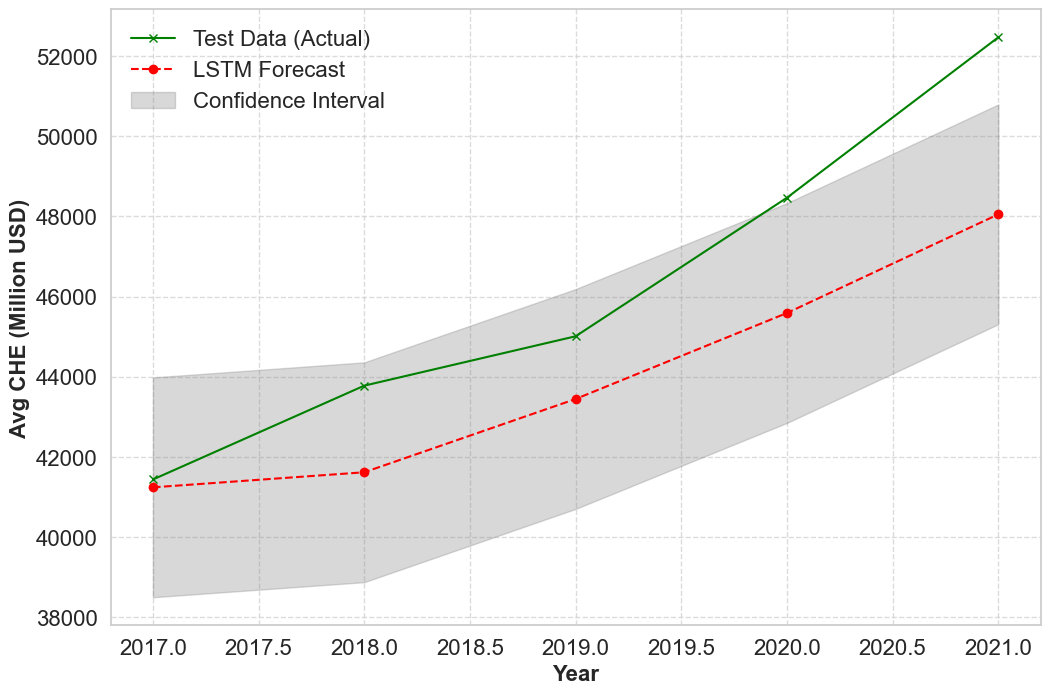

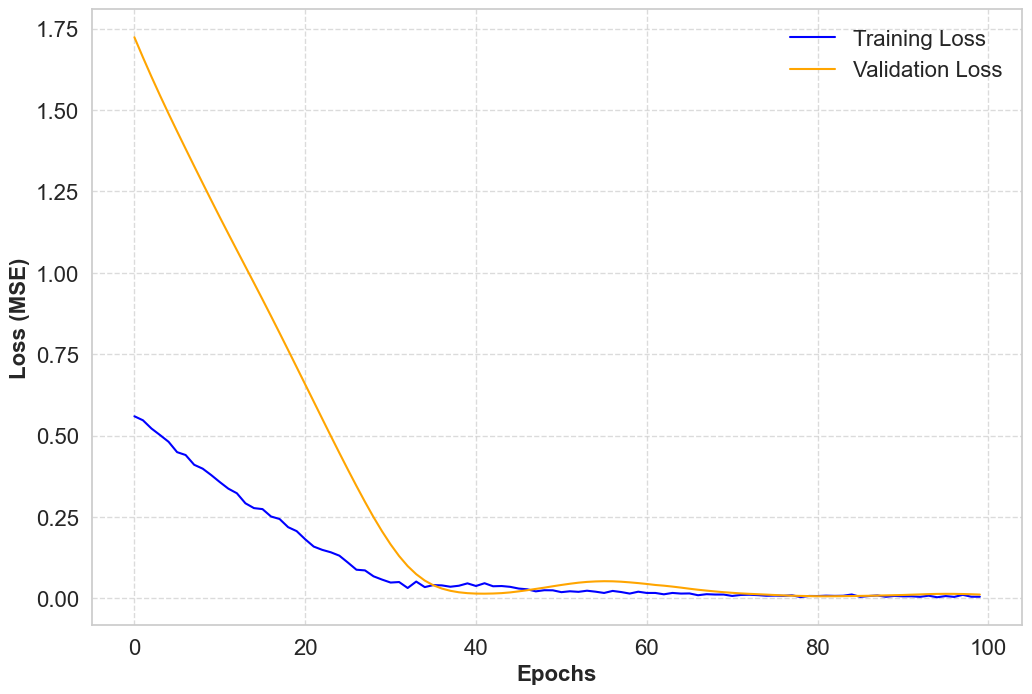

In [68]:
train_data = GHED_train.groupby('year')[['che_usd', 'combined_variable']].mean()
test_data = GHED_test.groupby('year')[['che_usd', 'combined_variable']].mean()

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

def create_supervised(data, time_steps=1):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, :])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_steps = 3
neurons = 150
batch_size = 32
epochs = 100
learning_rate = 0.001

X_train, y_train = create_supervised(train_scaled, time_steps)
X_test, y_test = create_supervised(np.vstack((train_scaled[-time_steps:], test_scaled)), time_steps)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

model = Sequential()
model.add(LSTM(neurons, activation='relu', input_shape=(time_steps, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, y_test))

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = scaler.inverse_transform(np.hstack((train_pred, np.zeros((train_pred.shape[0], 1)))))
test_pred_inv = scaler.inverse_transform(np.hstack((test_pred, np.zeros((test_pred.shape[0], 1)))))
y_train_inv = scaler.inverse_transform(np.hstack((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], 1)))))
y_test_inv = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1)))))

train_mae = mean_absolute_error(y_train_inv[:, 0], train_pred_inv[:, 0])
test_mae = mean_absolute_error(y_test_inv[:, 0], test_pred_inv[:, 0])
test_rmse = np.sqrt(mean_squared_error(y_test_inv[:, 0], test_pred_inv[:, 0]))
test_r2 = r2_score(y_test_inv[:, 0], test_pred_inv[:, 0])
test_mape = np.mean(np.abs((y_test_inv[:, 0] - test_pred_inv[:, 0]) / y_test_inv[:, 0])) * 100

print("\nFine-Tuned LSTM Model Evaluation Metrics:")
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R-squared: {test_r2}")
print(f"Test MAPE: {test_mape:.2f}%")

residuals = y_test_inv[:, 0] - test_pred_inv[:, 0]
residual_std = np.std(residuals)

upper_ci = test_pred_inv[:, 0] + 1.96 * residual_std
lower_ci = test_pred_inv[:, 0] - 1.96 * residual_std

plt.figure(figsize=(12, 8))
plt.plot(test_data.index, y_test_inv[:, 0], label='Test Data (Actual)', color='green', marker='x')
plt.plot(test_data.index, test_pred_inv[:, 0], label='LSTM Forecast', color='red', linestyle='--', marker='o')
plt.fill_between(test_data.index, lower_ci, upper_ci, color='grey', alpha=0.3, label='Confidence Interval')
plt.xlabel('Year', fontsize=16, fontweight='bold')
plt.ylabel('Avg CHE (Million USD)', fontsize=16, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, loc='upper left', frameon=False)
plt.grid(linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Loss (MSE)', fontsize=16, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, loc='upper right', frameon=False)
plt.grid(linestyle='--', alpha=0.7)
plt.show()


## Forecating

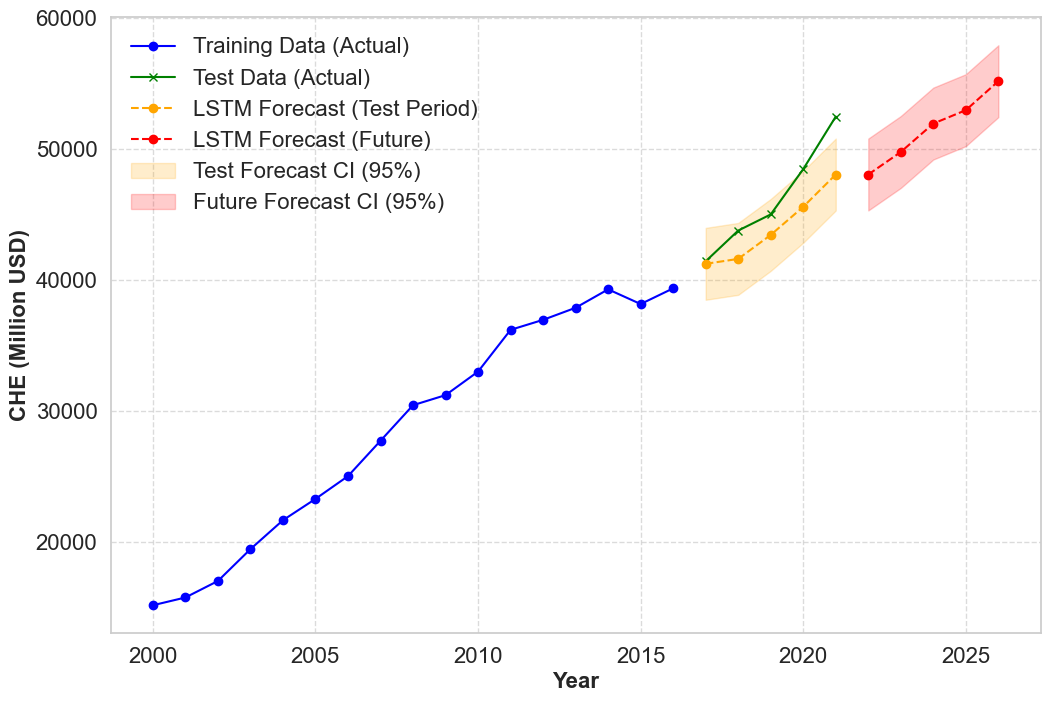

Forecasted Values for the Next 5 Years:
   Year  Forecasted_CHE_USD      Lower_CI      Upper_CI
0  2022        48051.963833  45309.668434  50794.259231
1  2023        49769.907262  47027.611864  52512.202661
2  2024        51937.577483  49195.282084  54679.872881
3  2025        52961.038477  50218.743078  55703.333876
4  2026        55169.671804  52427.376406  57911.967203


In [69]:
forecast_steps = 5  
last_sequence = X_test[-1]
future_forecast = []

for _ in range(forecast_steps):
    next_prediction = model.predict(last_sequence.reshape(1, time_steps, X_test.shape[2]), verbose=0)    
    future_forecast.append(next_prediction[0, 0])
    last_sequence = np.append(last_sequence[1:], [[next_prediction[0, 0], 0]], axis=0)

future_forecast_inv = scaler.inverse_transform(np.hstack((
    np.array(future_forecast).reshape(-1, 1),
    np.zeros((len(future_forecast), 1))
)))[:, 0]

residuals = y_test_inv[:, 0] - test_pred_inv[:, 0]
residual_std = np.std(residuals)

test_upper_ci = test_pred_inv[:, 0] + 1.96 * residual_std
test_lower_ci = test_pred_inv[:, 0] - 1.96 * residual_std

future_upper_ci = future_forecast_inv + 1.96 * residual_std
future_lower_ci = future_forecast_inv - 1.96 * residual_std

last_year = test_data.index[-1]
future_years = [last_year + i + 1 for i in range(forecast_steps)]

combined_years = list(train_data.index) + list(test_data.index) + future_years
combined_actual = list(train_data['che_usd']) + list(y_test_inv[:, 0]) + [None] * forecast_steps
combined_forecast = [None] * len(train_data) + list(test_pred_inv[:, 0]) + list(future_forecast_inv)
combined_upper_ci = [None] * len(train_data) + list(test_upper_ci) + list(future_upper_ci)
combined_lower_ci = [None] * len(train_data) + list(test_lower_ci) + list(future_lower_ci)

plt.figure(figsize=(12, 8))
plt.plot(train_data.index, train_data['che_usd'], label='Training Data (Actual)', color='blue', marker='o')
plt.plot(test_data.index, y_test_inv[:, 0], label='Test Data (Actual)', color='green', marker='x')
plt.plot(test_data.index, test_pred_inv[:, 0], label='LSTM Forecast (Test Period)', color='orange', linestyle='--', marker='o')
plt.plot(future_years, future_forecast_inv, label='LSTM Forecast (Future)', color='red', linestyle='--', marker='o')
plt.fill_between(test_data.index, test_lower_ci, test_upper_ci, color='orange', alpha=0.2, label='Test Forecast CI (95%)')
plt.fill_between(future_years, future_lower_ci, future_upper_ci, color='red', alpha=0.2, label='Future Forecast CI (95%)')
plt.xlabel('Year', fontsize=16, fontweight='bold')
plt.ylabel('CHE (Million USD)', fontsize=16, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, loc='upper left', frameon=False)
plt.grid(linestyle='--', alpha=0.7)
plt.show()

print("Forecasted Values for the Next 5 Years:")
forecast_df = pd.DataFrame({
    'Year': future_years,
    'Forecasted_CHE_USD': future_forecast_inv,
    'Lower_CI': future_lower_ci,
    'Upper_CI': future_upper_ci
})
print(forecast_df)


## Evaluvation

In [70]:
forecast_values = np.array(forecast_values)

forecast_df_ci = pd.DataFrame({
    'Future Forecast': forecast_values.flatten(),
    'Lower CI': forecast_values.flatten() - 1.96 * residual_std, 
    'Upper CI': forecast_values.flatten() + 1.96 * residual_std  
})

# Print the confidence intervals
print("Future Forecast Confidence Interval:")
print(f"Lower Bound:\n{forecast_df_ci['Lower CI']}")
print(f"Upper Bound:\n{forecast_df_ci['Upper CI']}")


Future Forecast Confidence Interval:
Lower Bound:
0    38215.244027
1    -2742.295999
2    39813.539375
3    -2742.297643
4    41425.241537
5    -2742.297493
6    43037.031109
7    -2742.297554
8    44649.289823
9    -2742.297547
Name: Lower CI, dtype: float64
Upper Bound:
0    43699.834825
1     2742.294798
2    45298.130173
3     2742.293155
4    46909.832335
5     2742.293305
6    48521.621907
7     2742.293244
8    50133.880620
9     2742.293250
Name: Upper CI, dtype: float64


In [71]:
residuals = y_test_inv[:, 0] - test_pred_inv[:, 0]

residual_mean = residuals.mean()
residual_std = residuals.std()

print(f"Residual Mean: {residual_mean}")
print(f"Residual Standard Deviation: {residual_std}")


Residual Mean: 2243.1040379957876
Residual Standard Deviation: 1399.1303055002447


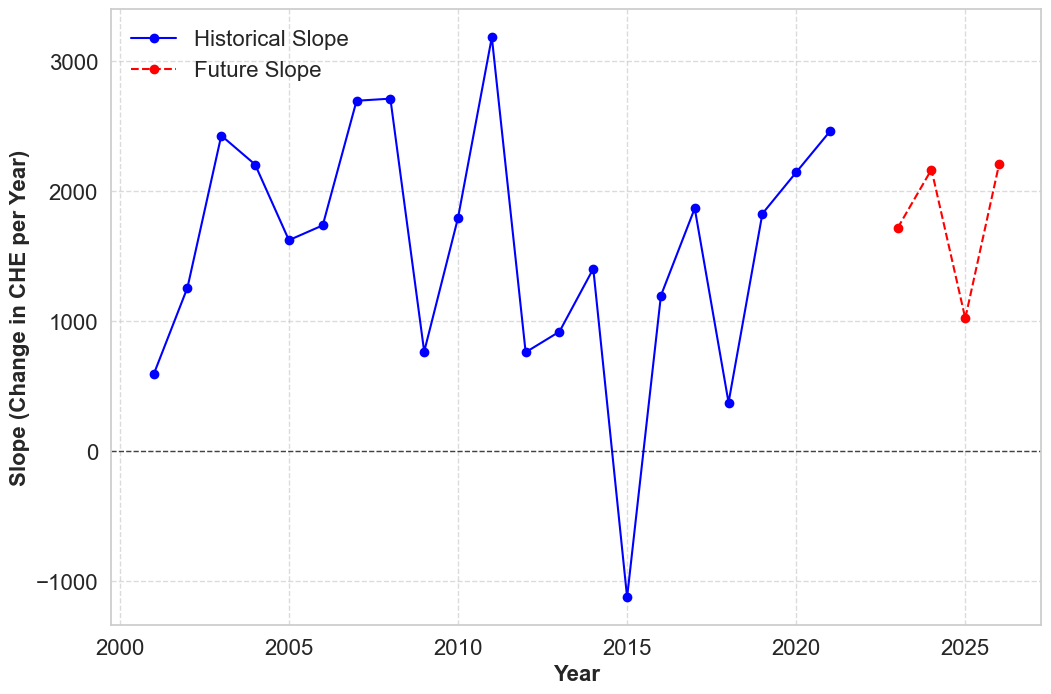

Historical Slopes:
    Year  Historical_Slope
1   2001        592.048373
2   2002       1259.779820
3   2003       2428.942497
4   2004       2206.275169
5   2005       1624.589798
6   2006       1738.508128
7   2007       2696.534296
8   2008       2712.819956
9   2009        767.327148
10  2010       1795.858397
11  2011       3184.922135
12  2012        762.404867
13  2013        921.274580
14  2014       1404.961476
15  2015      -1121.274718
16  2016       1198.327188
17  2017       1869.332584
18  2018        376.094057
19  2019       1828.089954
20  2020       2146.360183
21  2021       2461.653635

Future Slopes:
   Year  Future_Slope
1  2023   1717.943430
2  2024   2167.670220
3  2025   1023.460994
4  2026   2208.633327


In [72]:
historical_years = list(train_data.index) + list(test_data.index)
historical_values = list(train_data['che_usd']) + list(test_pred_inv[:, 0])

future_years = future_years 
future_values = future_forecast_inv

# Function to calculate slope
def calculate_slope(years, values):
    slopes = []
    for i in range(1, len(years)):
        slope = (values[i] - values[i - 1]) / (years[i] - years[i - 1])
        slopes.append(slope)
    return slopes


historical_slopes = calculate_slope(historical_years, historical_values)
future_slopes = calculate_slope(future_years, future_values)

historical_slopes = [np.nan] + historical_slopes
future_slopes = [np.nan] + future_slopes

all_years = historical_years + future_years
all_slopes = historical_slopes + future_slopes

# Ensure alignment
if len(all_years) != len(all_slopes):
    raise ValueError("Mismatch between combined years and slopes. Check data alignment.")

plt.figure(figsize=(12, 8))
plt.plot(historical_years, historical_slopes, label='Historical Slope', color='blue', marker='o')
plt.plot(future_years, future_slopes, label='Future Slope', color='red', linestyle='--', marker='o')
plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)
plt.xlabel('Year', fontsize=16, fontweight='bold')
plt.ylabel('Slope (Change in CHE per Year)', fontsize=16, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, loc='upper left', frameon=False)
plt.grid(linestyle='--', alpha=0.7)
plt.show()

historical_slope_df = pd.DataFrame({'Year': historical_years, 'Historical_Slope': historical_slopes})
future_slope_df = pd.DataFrame({'Year': future_years,'Future_Slope': future_slopes})

print("Historical Slopes:")
print(historical_slope_df.dropna())

print("\nFuture Slopes:")
print(future_slope_df.dropna())